In [1]:
import folium
import branca
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
# df_2005_2007 = pd.read_csv('modified_data_2006_2008.csv')
# df_2009_2011 = pd.read_csv('accidents_2009_to_2011.csv')
df_2012_2014 = pd.read_csv('accidents_2012_to_2014.csv')
df_combined = pd.concat([df_2012_2014], ignore_index=True)

In [3]:
filtered_df = df_combined[df_combined['LSOA_of_Accident_Location']=='E01004736']
print(filtered_df[['Longitude', 'Latitude']])
longitude_mean = filtered_df['Longitude'].mean()
longitude_range = [longitude_mean + 0.05 - 0.03, longitude_mean + 0.05 + 0.03]
print(longitude_range)
latitude_mean = filtered_df['Latitude'].mean()
latitude_range = [latitude_mean +0.02- 0.02, latitude_mean+ 0.02 + 0.02]
print(latitude_range)

        Longitude   Latitude
994     -0.127093  51.506075
995     -0.130856  51.505685
998     -0.128770  51.507361
1010    -0.126964  51.505713
1024    -0.144097  51.506076
...           ...        ...
321012  -0.133003  51.509587
321016  -0.149719  51.502478
321027  -0.133560  51.510045
321038  -0.122759  51.506366
336204  -0.123043  51.506460

[460 rows x 2 columns]
[-0.11280405217391305, -0.052804052173913055]
[51.506674697826085, 51.54667469782609]


In [4]:
df_E01004736 = df_combined[(df_combined['Longitude'] >= longitude_range[0])
                           &(df_combined['Longitude'] <= longitude_range[1])
                           &(df_combined['Latitude'] >= latitude_range[0])
                           &(df_combined['Latitude'] <= latitude_range[1])]

In [5]:
df_E01004736 = df_E01004736[(df_E01004736['Year']==2012) & (df_E01004736['Number_of_Casualties']>2)]
#location is the mean of every lat and long point to centre the map.
location = df_E01004736['Latitude'].mean(), df_E01004736['Longitude'].mean()

zoom_start = 12
#A basemap is then created using the location to centre on and the zoom level to start.
m = folium.Map(location=location,zoom_start=zoom_start)

#Each location in the DataFrame is then added as a marker to the basemap points are then added to the map
for i in range(0,len(df_E01004736)):
    folium.Marker([df_E01004736['Latitude'].iloc[i],df_E01004736['Longitude'].iloc[i]]).add_to(m)
        
m


In [6]:
# import folium.plugins as plugins

# data_heat = df_E01004736[['Latitude','Longitude','Number_of_Casualties']].values.tolist()
# m = folium.Map(location=location, zoom_start=zoom_start)
# #tiles='stamentoner'

# plugins.HeatMap(data_heat, min_opacity=0.6, radius=15, blur=10).add_to(m)

# m

## Geospatial info

In [7]:
from shapely.geometry import box, LineString
import networkx as nx 

# Get the bounds from df_E01004736
min_longitude = df_E01004736['Longitude'].min()
max_longitude = df_E01004736['Longitude'].max()
min_latitude = df_E01004736['Latitude'].min()
max_latitude = df_E01004736['Latitude'].max()

# Create a bounding box for the area of interest
bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# Check if bounding_box is valid
if not bounding_box.is_empty:
    # Create a GeoDataFrame with the bounding box
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]})
else:
    raise ValueError("The bounding box is empty!")

## road

In [8]:
shapefile_path_1 = f"greater-london-latest-free.shp/gis_osm_roads_a_free_1.shp"
df_roads = gpd.read_file(shapefile_path_1)
df_roads .head(10)
df_roads_filtered = df_roads [df_roads .intersects(bounding_box)]
df_roads_filtered.head()
print(df_roads_filtered.geometry.length)

242       0.000167
243       0.000114
245       0.000245
278       0.000659
287       0.001530
            ...   
483791    0.000128
483792    0.000091
483793    0.000064
483813    0.000340
483823    0.000444
Length: 16810, dtype: float64


In [9]:
# Set a minimum length threshold (in the same unit as your coordinate system, e.g., meters)
min_length = 0.001  # Example threshold

# Filter roads based on length
df_roads_filtered = df_roads_filtered[df_roads_filtered.geometry.length >= min_length]

print("Filtered roads with sufficient length:")
print(df_roads_filtered.head())  # Show the first few rows of the filtered roads


Filtered roads with sufficient length:
                                              geometry
287  LINESTRING (-0.08745 51.51167, -0.08773 51.512...
288  LINESTRING (-0.08514 51.5119, -0.08492 51.5118...
641  LINESTRING (-0.10593 51.53752, -0.10593 51.537...
642  LINESTRING (-0.10695 51.53751, -0.10685 51.537...
643  LINESTRING (-0.10768 51.54502, -0.1076 51.5450...


In [10]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot land use regions
# df_roads_filtered.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# # Set plot title and labels
# plt.title("Land Use in Greater London")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Show the plot
# plt.show()

In [11]:
# df_roads_filtered = df_roads [df_roads .intersects(bounding_box)]
# min_length = 0.001  # Example threshold
# df_roads_filtered = df_roads_filtered[df_roads_filtered.geometry.length >= min_length]
# fig, ax = plt.subplots(figsize=(10, 10))
# df_roads_filtered.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
# plt.title("Land Use in Greater London")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

## landuse

In [12]:

# Load the shapefile
shapefile_path = 'greater-london-latest-free.shp/gis_osm_landuse_a_free_1.shp'  # Replace with your actual path
landuse = gpd.read_file(shapefile_path)
unique_land_use_types = landuse['fclass'].unique()

# Inspect the first few rows to see the data
print(unique_land_use_types)
landuse.head()

['park' 'nature_reserve' 'forest' 'industrial' 'retail'
 'recreation_ground' 'meadow' 'residential' 'cemetery' 'grass' 'scrub'
 'allotments' 'quarry' 'commercial' 'military' 'heath' 'farmland'
 'farmyard' 'orchard']


osm_id  code fclass                name  \
0  2838058  7202   park                None   
1  2903046  7202   park                None   
2  2903368  7202   park  St Michael's Green   
3  2903369  7202   park                None   
4  2903398  7202   park      Bush Hill Park   

                                            geometry  
0  POLYGON ((-0.09186 51.66414, -0.09146 51.66418...  
1  POLYGON ((-0.08025 51.66596, -0.08005 51.6669,...  
2  POLYGON ((-0.08655 51.66212, -0.08653 51.66293...  
3  POLYGON ((-0.08272 51.66104, -0.08238 51.66179...  
4  POLYGON ((-0.07065 51.64713, -0.07058 51.64751...

In [13]:
df_landuse = landuse[landuse.intersects(bounding_box)]
print("Filtered landuse within Bounding Box:")
print(df_landuse.head())  # Show the first few rows of the filtered buildings

Filtered landuse within Bounding Box:
      osm_id  code             fclass                      name  \
275  4270744  7202               park  Barbican Wildlife Garden   
442  4406359  7202               park             London Fields   
496  4566319  7202               park             Sidney Square   
677  4969113  7202               park           Islington Green   
840  5070293  7211  recreation_ground       Stonebridge Gardens   

                                              geometry  
275  POLYGON ((-0.09675 51.52155, -0.0967 51.52157,...  
442  POLYGON ((-0.06305 51.54029, -0.06213 51.54046...  
496  POLYGON ((-0.05523 51.5163, -0.05519 51.51684,...  
677  POLYGON ((-0.10362 51.53582, -0.10334 51.53653...  
840  POLYGON ((-0.07541 51.53903, -0.0754 51.5392, ...  


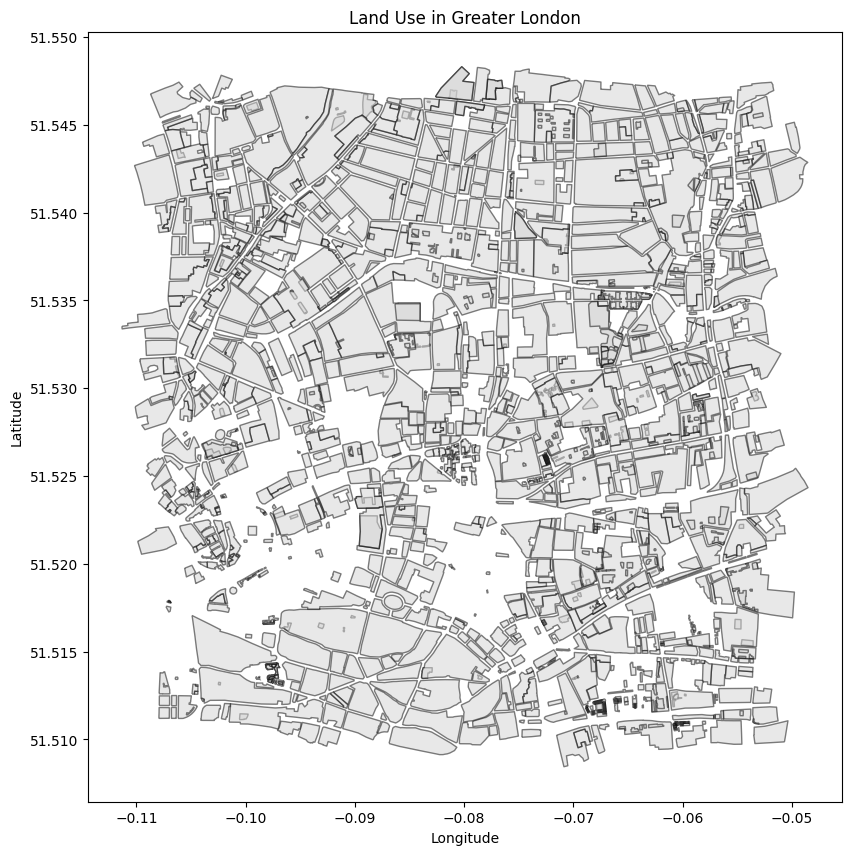

In [14]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot land use regions
df_landuse.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Set plot title and labels
plt.title("Land Use in Greater London")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


## railway

In [15]:
shapefile_path_1 = f"greater-london-latest-free.shp/gis_osm_railways_a_free_1.shp"
df_railway = gpd.read_file(shapefile_path_1)
df_railway.head(10)
df_railway_filtered = df_railway[df_railway.intersects(bounding_box)]
df_railway_filtered.head()
# # Plot the shapefile data
# fig, ax = plt.subplots(figsize=(10, 10))  # Set figure size
# df.plot(ax=ax, color='lightgrey')  # Plot the original shapefile data
# ax.set_aspect('equal')
# # Set title and labels if needed
# plt.title("Original Shapefile Data")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Show the plot
# plt.show()

geometry
30   LINESTRING (-0.06729 51.51106, -0.06687 51.511...
38   LINESTRING (-0.06634 51.51113, -0.06586 51.51117)
39   LINESTRING (-0.0643 51.52355, -0.06309 51.5236...
40   LINESTRING (-0.08193 51.51798, -0.08189 51.518...
205  LINESTRING (-0.05714 51.51173, -0.05768 51.511...

In [16]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, box

# Load the shapefile for buildings
shapefile_path = 'greater-london-latest-free.shp/gis_osm_buildings_a_free_1.shp'  # Replace with your actual path
building = gpd.read_file(shapefile_path)

# Define key locations to preserve
key_locations_to_preserve = {
    'train_station': 5,
    'university': 4,
    'government': 3,
    "museum": 2,
    'library': 2,
    'cathedral': 2,
    "church": 1,
    "monument": 1,
    "temple": 1,
    'historic': 1,
}

# Filter the GeoDataFrame to include only key locations
filtered_building = building[building['type'].isin(key_locations_to_preserve)]
# Check if the bounding box is valid
if not bounding_box.is_empty:
    # Filter filtered_building based on the bounding box
    df_building = filtered_building[filtered_building.intersects(bounding_box)]
    print("Filtered Buildings within Bounding Box:")
    print(df_building.head())  # Show the first few rows of the filtered buildings
else:
    raise ValueError("The bounding box is empty!")

Filtered Buildings within Bounding Box:
       osm_id  code    fclass                     name           type  \
12    4076420  1500  building                St Brides         church   
115   4959629  1500  building                     None  train_station   
138   4969133  1500  building      Saint Mary's Church         church   
874  22650557  1500  building  London Fenchurch Street  train_station   
908  22883967  1500  building          Garrod Building     university   

                                              geometry  
12   POLYGON ((-0.10572 51.51387, -0.10523 51.51388...  
115  POLYGON ((-0.08273 51.51774, -0.0827 51.51778,...  
138  POLYGON ((-0.10201 51.53848, -0.10157 51.53849...  
874  POLYGON ((-0.07928 51.5115, -0.07925 51.51155,...  
908  POLYGON ((-0.06097 51.51788, -0.06052 51.51798...  


In [17]:
print(df_landuse['fclass'].unique())  # This will print all unique land use types in the dataset


['park' 'recreation_ground' 'cemetery' 'residential' 'commercial' 'forest'
 'retail' 'industrial' 'military' 'farmyard' 'grass' 'scrub' 'allotments'
 'meadow' 'orchard' 'nature_reserve']


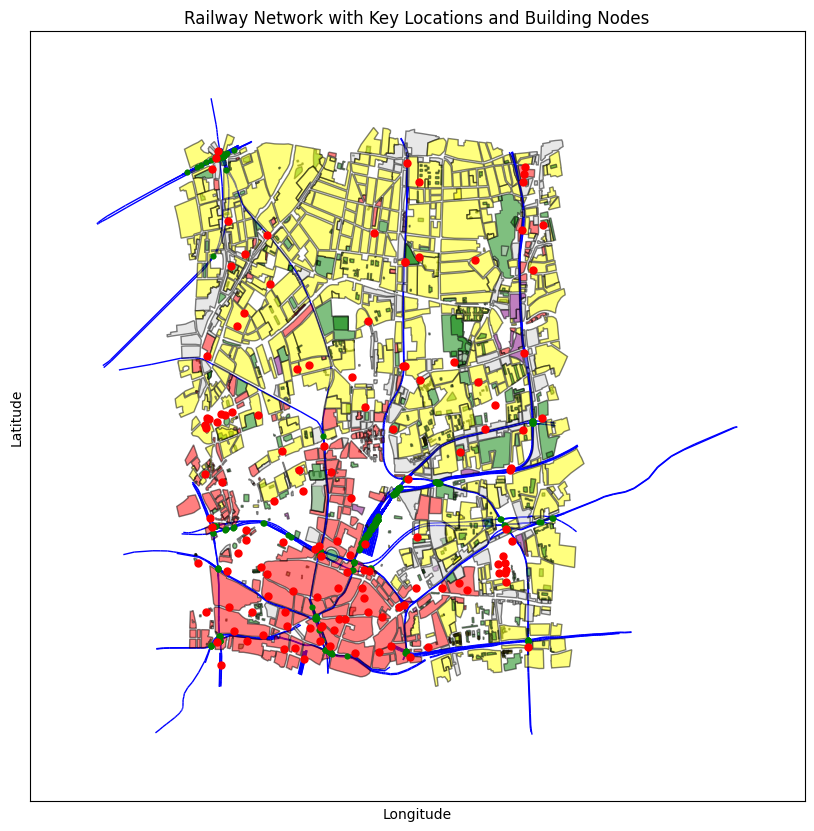

In [18]:
from shapely.geometry import Polygon  # Import the correct Polygon class
from matplotlib.patches import Polygon as MplPolygon
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, box

# Create a new graph for the railway network
G = nx.Graph()

# Add edges to the graph from the geometries in df (assumed to be railway data)
for _, row in df_railway_filtered.iterrows():
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], geometry=row.geometry)

# Create a simplified graph
simplified_graph = nx.Graph()

# Add simplified edges to the new graph
for edge in G.edges(data=True):
    start, end = edge[0], edge[1]
    simplified_line = LineString([start, end])
    simplified_graph.add_edge(start, end, geometry=simplified_line)

# Detect intersections
intersection_nodes = []
intersection_edges = []
for edge1 in simplified_graph.edges(data=True):
    for edge2 in simplified_graph.edges(data=True):
        if edge1 != edge2:
            line1 = edge1[2]['geometry']
            line2 = edge2[2]['geometry']
            if line1.intersects(line2):
                intersection_point = line1.intersection(line2)
                if not intersection_point.is_empty and isinstance(intersection_point, Point):
                    intersection_coords = (intersection_point.x, intersection_point.y)
                    if intersection_coords not in simplified_graph:
                        intersection_nodes.append(intersection_coords)
                        intersection_edges.append((edge1[0], intersection_coords))
                        intersection_edges.append((edge1[1], intersection_coords))
                        intersection_edges.append((edge2[0], intersection_coords))
                        intersection_edges.append((edge2[1], intersection_coords))

# Add intersection nodes and edges to the graph
for coords in intersection_nodes:
    simplified_graph.add_node(coords)

for start, end in intersection_edges:
    simplified_graph.add_edge(start, end)

# Add building nodes with weights
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    simplified_graph.add_node((centroid.x, centroid.y), weight=weight)  # Add node with weight

# Position for nodes (including intersections)
pos = {node: node for node in simplified_graph.nodes()}

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Set figure size

# Plot the network edges
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Plot intersection nodes in a different color
for coords in intersection_nodes:
    nx.draw_networkx_nodes(simplified_graph, pos, nodelist=[coords], node_color='green', node_size=10)

# Plot building nodes as red
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    ax.plot(centroid.x, centroid.y, 'ro', markersize=5)  # Plot as red nodes

# Define color mapping for each key location type
landuse_colors = {
    'commercial': 'red',
    'university': 'blue',
    'park': 'green',
    'forest': 'green',
    'recreation_ground': 'green',
    'grass': 'green',
    'residential': 'yellow',
    'industrial': 'purple',

}

# Assuming 'landuse_type' column exists in df_landuse, which corresponds to the keys in key_locations_to_preserve
for _, row in df_landuse.iterrows():
    if isinstance(row.geometry, Polygon):  # Check if it's a Polygon
        # Extract the polygon's exterior coordinates
        polygon_coords = row.geometry.exterior.coords
        
        # Get land use type from the row
        landuse_type = row['fclass']
        
        # Determine the face color based on the land use type
        facecolor = landuse_colors.get(landuse_type, 'lightgrey')  # Default color is light grey if not found
        
        # Create the polygon with the corresponding facecolor
        polygon = MplPolygon(polygon_coords, closed=True, edgecolor='black', facecolor=facecolor, alpha=0.5)
        ax.add_patch(polygon)  # Add the polygon to the plot

# Set plot title and labels
plt.title("Railway Network with Key Locations and Building Nodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


In [19]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from shapely.geometry import Point
# import numpy as np

# # Create a new graph for the landmark network
# landmark_graph = nx.Graph()

# # Assuming df_building contains building data and key_locations_to_preserve is defined
# # Add landmark nodes to the landmark graph
# for _, row in df_building.iterrows():
#     centroid = row.geometry.centroid
#     weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
#     landmark_graph.add_node((centroid.x, centroid.y), weight=weight)  # Add landmark node with weight

# # Now, let's create edges based on nearest landmark connections
# landmark_nodes = list(landmark_graph.nodes)  # Get list of landmark nodes

# # Connect each landmark node to its nearest neighbor (or as per your logic)
# for i, node1 in enumerate(landmark_nodes):
#     for j, node2 in enumerate(landmark_nodes):
#         if i != j:  # Avoid connecting the node to itself
#             # Calculate distance
#             distance = np.linalg.norm(np.array(node1) - np.array(node2))
#             # You can define a threshold distance to add an edge
#             if distance < 1.0:  # Adjust the threshold distance as needed
#                 landmark_graph.add_edge(node1, node2, weight=distance)

# # Create a position dictionary for plotting
# pos = {node: node for node in landmark_graph.nodes()}

# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))  # Set figure size

# # Plot landmark nodes
# nx.draw_networkx_nodes(landmark_graph, pos, node_color='orange', node_size=100)

# # Set plot title and labels
# plt.title("Landmark Graph with Key Locations")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Show the plot
# plt.show()


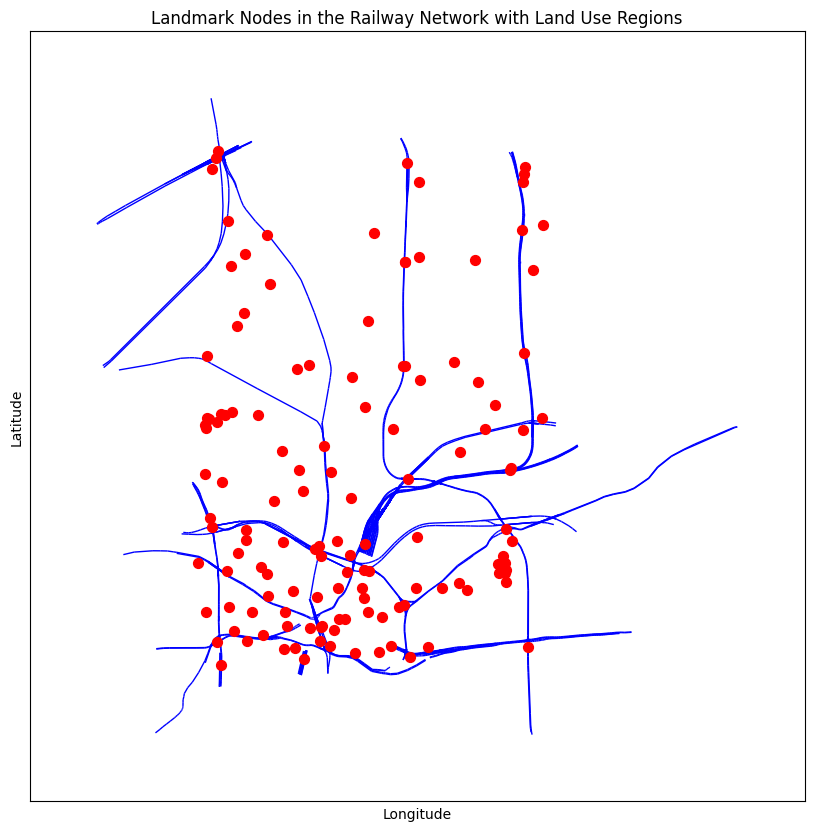

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np  # Ensure numpy is imported


# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)  # No need to loop again, landmark_nodes already has the coordinates

# Optional: Uncomment if you want to plot land use regions
# landuse_regions = []
# for _, row in df_landuse.iterrows():
#     if row.geometry is not None and row.geometry.type in ['Polygon', 'MultiPolygon']:
#         landuse_regions.append(row.geometry)

# # Plot the land use regions
# for region in landuse_regions:
#     if isinstance(region, Polygon):
#         x, y = region.exterior.xy
#         ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')
#     elif isinstance(region, MultiPolygon):
#         for poly in region.geoms:  # Use .geoms to access individual polygons
#             x, y = poly.exterior.xy
#             ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')

# Plot only the landmark nodes
nx.draw_networkx_nodes(simplified_graph, pos, nodelist=landmark_nodes, ax=ax, node_color='red', node_size=50)
# Plot the network edges
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Set plot title and labels
plt.title("Landmark Nodes in the Railway Network with Land Use Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


In [21]:
print(len(simplified_graph.edges))

4263


In [22]:
import networkx as nx

# Assuming `G` is your graph created from the edges you provided

# Calculate the degree of each node
degree_dict = dict(G.degree())

# Find endpoints (nodes with degree 1)
endpoints = [node for node, degree in degree_dict.items() if degree == 1]

# Print the endpoints
print("Endpoints (nodes with only one connection):")
print(endpoints)

# If you want to find the farthest endpoint from the centroid
centroid = (-0.0672891, 51.5110622)  # Replace with your actual centroid coordinates
farthest_endpoints = sorted(endpoints, key=lambda x: np.linalg.norm(np.array(x) - np.array(centroid)), reverse=True)

# Get the four farthest endpoints
farthest_four = farthest_endpoints[:4]

print("The four endpoints farthest from the centroid are:")
print(farthest_four)


Endpoints (nodes with only one connection):
[(-0.0819261, 51.517979), (-0.0779551, 51.5114471), (-0.0777298, 51.5098131), (-0.0597635, 51.546551), (-0.0592751, 51.5465821), (-0.0760926, 51.547567), (-0.1219198, 51.5414546), (-0.1005762, 51.5470325), (-0.0254192, 51.5269379), (-0.0431718, 51.5122192), (-0.0986439, 51.5472622), (-0.1032424, 51.5084355), (-0.0757532, 51.510326), (-0.0814969, 51.5178958), (-0.0824085, 51.5180724), (-0.081433, 51.5178834), (-0.081756, 51.517946), (-0.082344, 51.5180619), (-0.0821916, 51.5180304), (-0.0821511, 51.5180226), (-0.0807988, 51.517754), (-0.1055763, 51.5101285), (-0.0784406, 51.5095608), (-0.0906354, 51.5109536), (-0.0914396, 51.5093148), (-0.090264, 51.5110118), (-0.0911399, 51.5092521), (-0.0903772, 51.5110342), (-0.0912448, 51.5092739), (-0.0907626, 51.5109748), (-0.091553, 51.5093365), (-0.090412, 51.5110406), (-0.0912924, 51.5092843), (-0.1031381, 51.5468466), (-0.0564737, 51.5051814), (-0.0816816, 51.5179348), (-0.0913899, 51.509307), (-0.09

16


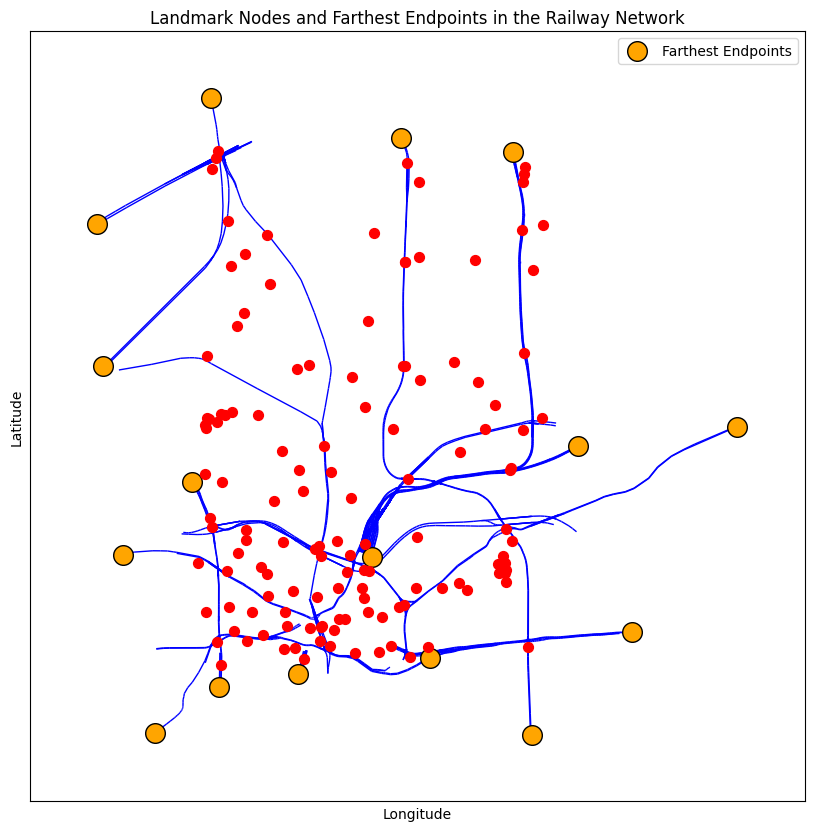

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)

# Plot the network edges
pos = {node: (node[0], node[1]) for node in simplified_graph.nodes()}  # Ensure pos is defined
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Calculate the degree of each node and find endpoints
degree_dict = dict(simplified_graph.degree())
endpoints = [node for node, degree in degree_dict.items() if degree == 1]

# Calculate the centroid of the landmark nodes for comparison
centroid = np.mean(landmark_coords, axis=0)  # Compute the centroid from landmark nodes

# Find the four farthest endpoints from the centroid
farthest_endpoints = sorted(endpoints, key=lambda x: np.linalg.norm(np.array(x) - centroid), reverse=True)

# Function to filter out overlapping points
def filter_overlapping_points(points, threshold):
    filtered_points = []
    for point in points:
        if all(np.linalg.norm(np.array(point) - np.array(existing_point)) > threshold for existing_point in filtered_points):
            filtered_points.append(point)
        if len(filtered_points) == 16:  # Stop once we have 4 points
            break
    return filtered_points

# Set a distance threshold (e.g., 0.0001 degrees for longitude/latitude)
distance_threshold = 0.01
filtered_endpoints = filter_overlapping_points(farthest_endpoints, distance_threshold)

# Plot the filtered endpoints
endpoint_coords = np.array(filtered_endpoints)
print(len(endpoint_coords))
ax.scatter(endpoint_coords[:, 0], endpoint_coords[:, 1], color='orange', s=200, label='Farthest Endpoints', edgecolor='black')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(simplified_graph, pos, nodelist=landmark_nodes, ax=ax, node_color='red', node_size=50)

# Set plot title and labels
plt.title("Landmark Nodes and Farthest Endpoints in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


In [24]:
landmark_nodes

[(-0.10547143691003925, 51.51378583350597),
 (-0.08148712130076995, 51.51860856046498),
 (-0.10170225931092795, 51.5384067777282),
 (-0.0775347437405314, 51.51132041588599),
 (-0.06065135305196608, 51.5177215864139),
 (-0.10256715465294979, 51.52780558523574),
 (-0.10320795981969214, 51.527890491295416),
 (-0.10211125675684211, 51.54167684781187),
 (-0.10450867261442078, 51.545326827918124),
 (-0.10660906431951017, 51.517268902812674),
 (-0.10223246664399493, 51.516676578222906),
 (-0.09946629804640776, 51.518922836094376),
 (-0.10359830875616209, 51.54663047786893),
 (-0.09381726696473786, 51.518714800941076),
 (-0.09575438883650518, 51.53715922528605),
 (-0.09765400037194773, 51.52778720369907),
 (-0.0940034, 51.525216),
 (-0.09960505533587923, 51.53928487425357),
 (-0.07380499596644939, 51.51546790389022),
 (-0.10562234014514855, 51.523575623279676),
 (-0.10074851064957079, 51.53413665543278),
 (-0.10534427083765845, 51.53198552919702),
 (-0.05615996220225827, 51.53817540010842),
 (

## k-Means clustering for landmark

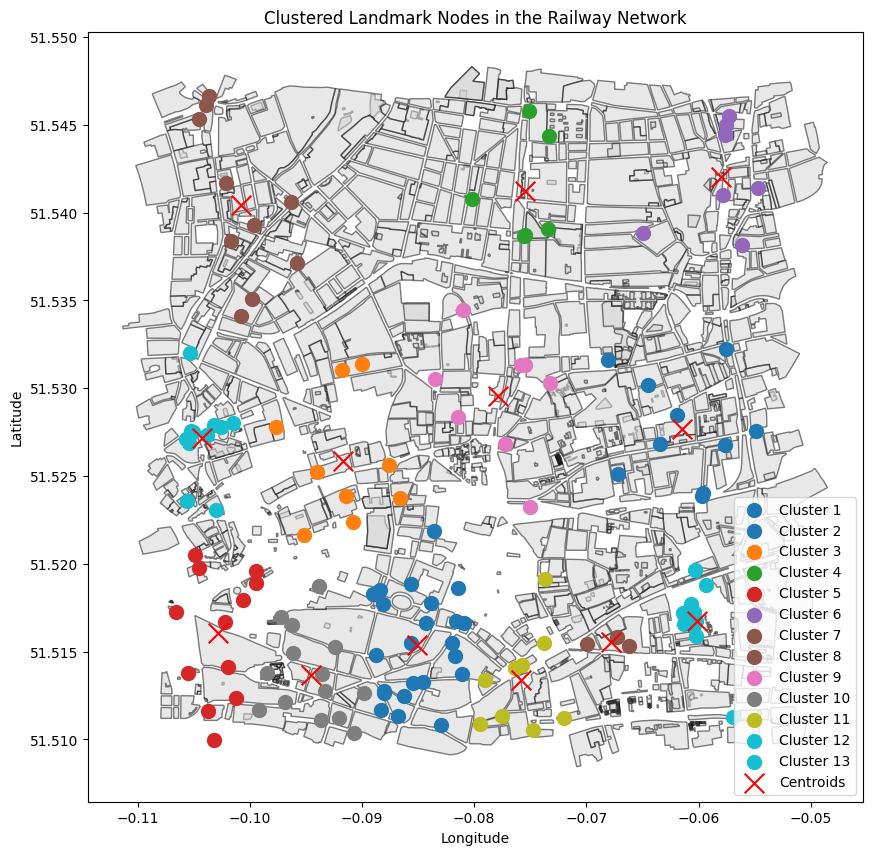

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
from sklearn.cluster import KMeans  # Import KMeans for clustering

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)

# Step 1: Cluster the landmark nodes into clusters
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(landmark_coords)

# Step 2: Get cluster labels
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Optional: Uncomment if you want to plot land use regions
landuse_regions = []
for _, row in df_landuse.iterrows():
    if row.geometry is not None and row.geometry.type in ['Polygon', 'MultiPolygon']:
        landuse_regions.append(row.geometry)

# Plot the land use regions
for region in landuse_regions:
    if isinstance(region, Polygon):
        x, y = region.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')
    elif isinstance(region, MultiPolygon):
        for poly in region.geoms:  # Use .geoms to access individual polygons
            x, y = poly.exterior.xy
            ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')

# Step 3: Plot the landmark nodes with colors based on cluster labels
colors = plt.cm.get_cmap('tab10', num_clusters)  # Get a colormap with as many colors as clusters
for cluster in range(num_clusters):
    cluster_nodes = landmark_coords[labels == cluster]
    ax.scatter(cluster_nodes[:, 0], cluster_nodes[:, 1], 
               color=colors(cluster), label=f'Cluster {cluster + 1}', s=100)
    
ax.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=200, label='Centroids')

# Construct the pos dictionary for the graph
pos = {node: (node[0], node[1]) for node in simplified_graph.nodes()}

# Set plot title and labels
plt.title("Clustered Landmark Nodes in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


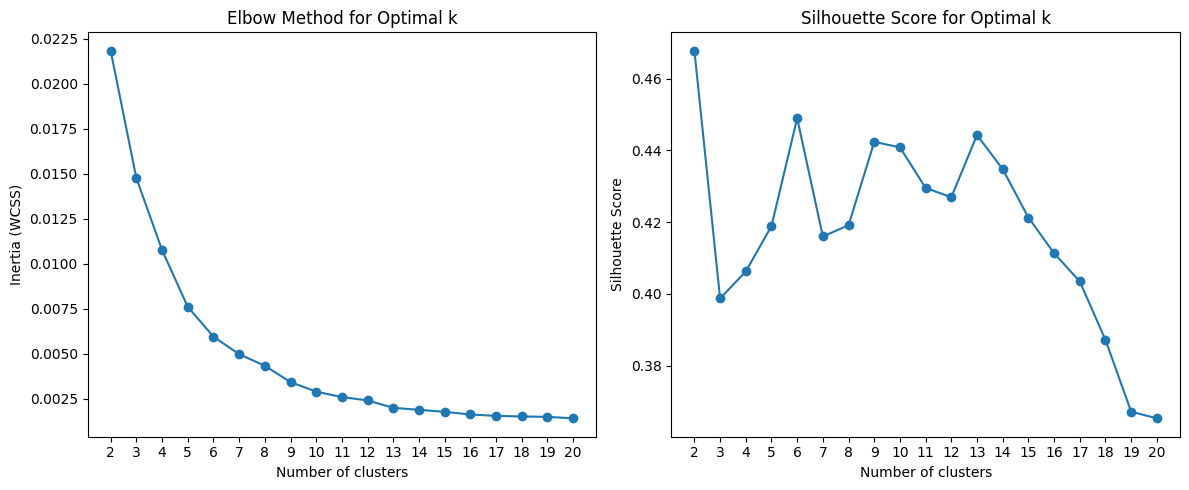

In [26]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming landmark_coords is your array of landmark coordinates
range_n_clusters = range(2, 21)  # Test cluster numbers from 2 to 10

# Initialize lists to hold the results
inertia = []
silhouette_scores = []

# Calculate inertia and silhouette scores
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(landmark_coords)
    
    inertia.append(kmeans.inertia_)  # WCSS
    silhouette_avg = silhouette_score(landmark_coords, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(12, 5))

# Subplot for Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.xticks(range_n_clusters)

# Subplot for Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)

plt.tight_layout()
plt.show()


### Mathematical Formulation for Optimization Score

The optimization score is calculated based on the following components:

1. **Total Distance of the Path:**

   The total distance \( D \) of the path is computed as the sum of the weights of all edges in the path. If we denote the path as \( P = (p_0, p_1, \ldots, p_n) \), then the total distance can be expressed as:

   \[
   D = \sum_{i=0}^{n-1} w(p_i, p_{i+1})
   \]

   where \( w(p_i, p_{i+1}) \) is the weight of the edge connecting nodes \( p_i \) and \( p_{i+1} \) in the graph.

2. **Number of Connected Nodes:**

   The number of unique nodes \( C \) in the path can be represented as:

   \[
   C = | \{ p_0, p_1, \ldots, p_n \} |
   \]

   where \( | \cdot | \) denotes the cardinality (the number of unique elements) of the set of nodes in the path.

3. **Average Distance to Centroids:**

   The average distance \( A \) from each node in the path to the nearest K-means centroid can be computed as:

   \[
   A = \frac{1}{n} \sum_{j=0}^{n} \min_{C_i \in C} \left( \| p_j - C_i \| \right)
   \]

   where \( C \) is the set of centroids, \( C_i \) represents each centroid, and \( \| p_j - C_i \| \) is the Euclidean distance between the node \( p_j \) and the centroid \( C_i \).

### Final Optimization Score Formula

Combining all the components, the overall optimization score \( S \) can be represented as:

\[
S = (1 - \beta) \cdot D + \beta \cdot C - A
\]

where \( \beta \) is a weight factor (ranging from 0 to 1) that determines the relative importance of the number of connected nodes compared to the total distance of the path.


Optimized Path: [(-0.0253973, 51.5269642), (-0.05490464539601196, 51.52756878205618), (-0.06447214999999826, 51.53019055000001), (-0.07323553216240178, 51.53028795485744), (-0.07581521437499834, 51.53131862775487), (-0.08351835786006821, 51.53053537766514), (-0.08998067030559856, 51.5313646592414), (-0.09575438883650518, 51.53715922528605), (-0.10211125675684211, 51.54167684781187), (-0.10450867261442078, 51.545326827918124), (-0.1219198, 51.5414546)]
Optimization Score: 0.8494216701685939


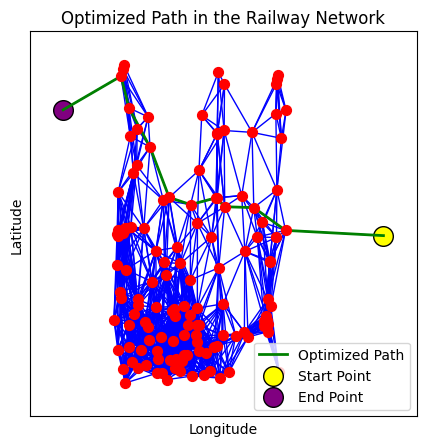

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create a graph from landmark nodes
landmark_graph = nx.Graph()

# Add landmark nodes to the graph as tuples
for landmark in landmark_nodes:
    landmark_graph.add_node(tuple(landmark))  # Convert to tuple

# Define a scaling factor for edge weights
scaling_factor = 10  # Adjust this value as needed to increase the weights

# Create edges between landmark nodes based on a distance threshold
distance_threshold = 0.01  # Adjust as necessary
for i, landmark1 in enumerate(landmark_nodes):
    for landmark2 in landmark_nodes[i + 1:]:
        distance = np.linalg.norm(np.array(landmark1) - np.array(landmark2))
        if distance <= distance_threshold:
            weighted_distance = distance * scaling_factor  # Scale the distance
            landmark_graph.add_edge(tuple(landmark1), tuple(landmark2), weight=weighted_distance)  # Convert to tuple

# Select start and end points maximizing distance
start_point, end_point = None, None
max_distance = 0

for i in range(len(filtered_endpoints)):
    for j in range(i + 1, len(filtered_endpoints)):
        distance = np.linalg.norm(np.array(filtered_endpoints[i]) - np.array(filtered_endpoints[j]))
        if distance > max_distance:
            max_distance = distance
            start_point, end_point = filtered_endpoints[i], filtered_endpoints[j]

# Add start and end points to the graph and connect to the nearest landmark nodes
def connect_nearest(landmark_graph, point):
    nearest_node = min(landmark_nodes, key=lambda node: np.linalg.norm(np.array(point) - np.array(node)))
    distance = np.linalg.norm(np.array(point) - np.array(nearest_node))
    weighted_distance = distance * scaling_factor  # Scale the distance
    landmark_graph.add_edge(tuple(point), tuple(nearest_node), weight=weighted_distance)  # Convert to tuple

connect_nearest(landmark_graph, tuple(start_point))
connect_nearest(landmark_graph, tuple(end_point))

# Find the shortest path using Dijkstra's algorithm
try:
    path = nx.dijkstra_path(landmark_graph, tuple(start_point), tuple(end_point))
except nx.NetworkXNoPath:
    print("No path found between the start and end points.")
    path = []

# Calculate optimization criteria
def optimization_score(path, start_point, end_point):
    if len(path) < 2:
        return 0  # No valid path found
    path_length = 0
    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        if edge in landmark_graph.edges:
            path_length += landmark_graph[edge[0]][edge[1]]['weight']
    connected_landmark_nodes = len(path) - 2  # Exclude start and end points
    distance = np.linalg.norm(np.array(start_point) - np.array(end_point))
    return (connected_landmark_nodes * distance) / path_length if path_length > 0 else 0

# Calculate score for the found path
score = optimization_score(path, start_point, end_point)

# Print results
print("Optimized Path:", path)
print("Optimization Score:", score)

# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figure size as needed

# Plot the network edges
pos = {node: (node[0], node[1]) for node in landmark_graph.nodes()}  # Ensure pos is defined
nx.draw_networkx_edges(landmark_graph, pos, ax=ax, edge_color='blue', width=1)

# Plot the optimized path if found
if path:
    path_coords = np.array(path)
    ax.plot(path_coords[:, 0], path_coords[:, 1], color='green', linewidth=2, label='Optimized Path')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='red', node_size=50)

# Highlight start and end points
ax.scatter(start_point[0], start_point[1], color='yellow', s=200, label='Start Point', edgecolor='black')
ax.scatter(end_point[0], end_point[1], color='purple', s=200, label='End Point', edgecolor='black')

# Set plot title and labels
plt.title("Optimized Path in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


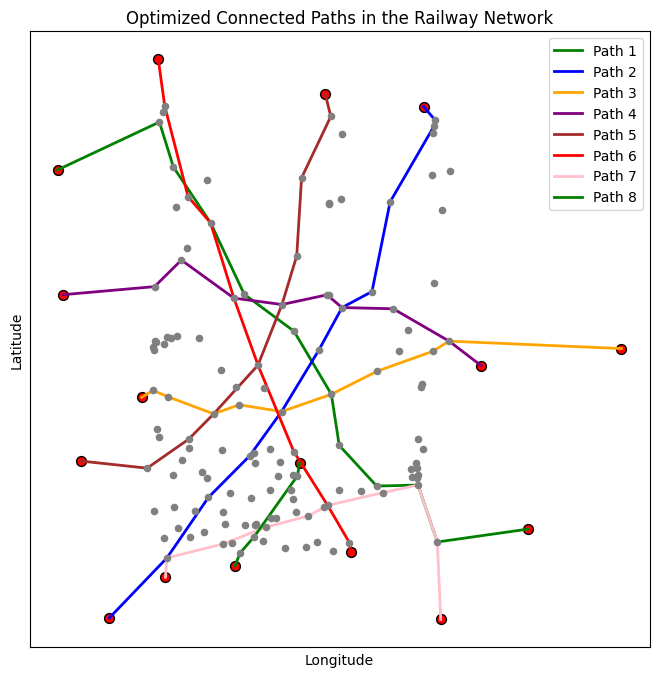

Connected Path 1: [(-0.0413418, 51.5123328), (-0.05691543642696273, 51.5112852598348), (-0.06023290028409142, 51.51589934999195), (-0.06730209565642328, 51.51582080236443), (-0.0737149643355573, 51.519113811700294), (-0.07506179231117928, 51.52325832870609), (-0.08145861079818892, 51.52836953774279), (-0.08998067030559856, 51.5313646592414), (-0.09575438883650518, 51.53715922528605), (-0.10211125675684211, 51.54167684781187), (-0.10450867261442078, 51.545326827918124), (-0.1219198, 51.5414546)]
Connected Path 2: [(-0.1130809, 51.5051308), (-0.1032306995708394, 51.509986889529046), (-0.09611804398572643, 51.51489855122484), (-0.08906496640856473, 51.51826190062941), (-0.08359186811972005, 51.52185419342645), (-0.07722520007997388, 51.52682258609768), (-0.07323553216240178, 51.53028795485744), (-0.06810773797355037, 51.5315828714587), (-0.06499567308553308, 51.53885566185226), (-0.05751748518150304, 51.54496919044617), (-0.0573163852568348, 51.545497212231844), (-0.0592751, 51.5465821)]


In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from itertools import combinations
from sklearn.cluster import KMeans
import random

# Function to calculate distance to the nearest K-means centroid
def distance_to_centroid(node, centroids):
    return np.min([np.linalg.norm(np.array(node) - np.array(centroid)) for centroid in centroids])

# Function to find optimized path between two points
def find_optimized_path(start_point, end_point, landmark_graph, centroids, used_edges):
    # Connect start and end points to the nearest landmark nodes
    connect_nearest(landmark_graph, tuple(start_point))
    connect_nearest(landmark_graph, tuple(end_point))
    
    # Find the shortest path using Dijkstra's algorithm
    try:
        path = nx.dijkstra_path(landmark_graph, tuple(start_point), tuple(end_point))
    except nx.NetworkXNoPath:
        return [], 0  # No path found

    # Calculate optimization score using the new criteria
    score = optimization_score(path, start_point, end_point, centroids, used_edges)
    return path, score

# Optimization score calculation
def optimization_score(path, start_point, end_point, centroids, used_edges, beta=0.5, alpha=1, delta=1):
    distance = 0
    overlap_penalty = 0

    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        reverse_edge = (path[i + 1], path[i])
        
        if edge in landmark_graph.edges:
            distance += landmark_graph.edges[edge]['weight']  # Access the weight directly

            # Check for overlap in both directions and apply penalty
            if edge in used_edges or reverse_edge in used_edges:
                overlap_penalty += 1  # Increment penalty for overlapping edge
        else:
            print(f"Edge not found: {edge}. Using default distance of infinity.")
            distance = float('inf')  # Handle missing edges appropriately
            break

    connected_nodes = len(set(path))  # Unique nodes in the path
    avg_distance_to_centroid = np.mean([distance_to_centroid(node, centroids) for node in path])
    
    # Return a score that includes the overlap penalty
    return (1 - beta) * distance + beta * connected_nodes - alpha * avg_distance_to_centroid - delta * overlap_penalty

# Initialize all points (filtered_endpoints) to connect
remaining_points = filtered_endpoints.copy()
connected_paths = []  # Store the paths that connect points
used_edges = set()  # To track used edges

# While there are still points left to connect
while len(remaining_points) > 1:
    best_path = None
    best_score = -np.inf  # Initialize to negative infinity for maximization
    
    # Check combinations of all remaining points
    for combination in combinations(remaining_points, 2):
        start_point, end_point = combination
        path, score = find_optimized_path(start_point, end_point, landmark_graph, centroids, used_edges)
        
        # Update the best path if the current one has a higher score
        if score > best_score:
            best_path = path
            best_score = score
            
    if best_path:  # If a valid best path was found
        connected_paths.append(best_path)
        # Add used edges and their reverse to the set
        for i in range(len(best_path) - 1):
            used_edges.add((best_path[i], best_path[i + 1]))
            used_edges.add((best_path[i + 1], best_path[i]))  # Include reverse edge
        
        # Remove the points that have been connected
        connected_set = set(best_path)
        remaining_points = [point for point in remaining_points if tuple(point) not in connected_set]

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

# Plot the network edges
pos = {node: (node[0], node[1]) for node in landmark_graph.nodes()}  # Ensure pos is defined

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red', 'pink'] 

# Plot the connected paths
for i, path in enumerate(connected_paths):
    path_coords = np.array(path)
    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(path_coords[:, 0], path_coords[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Optimized Connected Paths in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Print the connected paths
for i, path in enumerate(connected_paths):
    print(f"Connected Path {i + 1}: {path}")

# Function to connect nearest nodes (implement this as needed)
def connect_nearest(landmark_graph, point):
    # Find the nearest landmark node to connect
    nearest_node = min(landmark_graph.nodes, key=lambda node: np.linalg.norm(np.array(node) - np.array(point)))
    landmark_graph.add_edge(point, nearest_node, weight=np.linalg.norm(np.array(point) - np.array(nearest_node)))

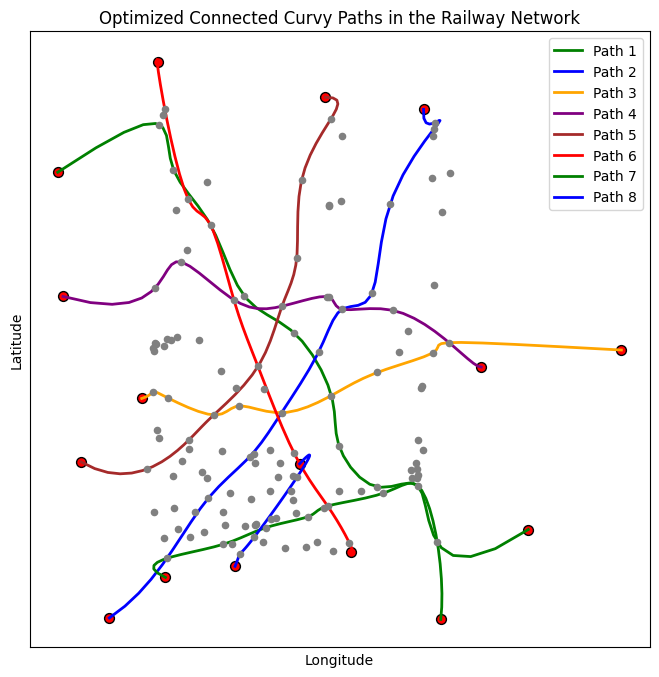

Smooth Paths List:
Path 1:
x: [-0.0413418  -0.0469938  -0.05120199 -0.05420553 -0.05624355 -0.05755522
 -0.05837967 -0.05895605 -0.05952352 -0.06032118 -0.06151294 -0.06303329
 -0.06477311 -0.06662327 -0.06847496 -0.07022341 -0.07176671 -0.07300299
 -0.07383072 -0.07423485 -0.0744035  -0.07455393 -0.07490338 -0.07565001
 -0.07681265 -0.07831183 -0.08006712 -0.08199801 -0.08401955 -0.08603862
 -0.08796127 -0.08969352 -0.09116142 -0.09243079 -0.09362691 -0.09487531
 -0.09629903 -0.09790105 -0.09951261 -0.10095175 -0.1020365  -0.10264452
 -0.10296695 -0.10329773 -0.10393081 -0.10516016 -0.10727977 -0.1105836
 -0.11536562 -0.1219198 ], y: [51.5123328  51.51077375 51.51013048 51.51022049 51.51086128 51.51187034
 51.51306518 51.5142633  51.51528219 51.51593939 51.51613713 51.51603594
 51.5158455  51.51577546 51.51602181 51.51660271 51.51741197 51.51834084
 51.51928074 51.52016728 51.52103984 51.52195267 51.52296005 51.5241063
 51.52534255 51.52656885 51.52768473 51.5285905  51.52926535 51.52

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
smooth_paths = []  # List to store smoothed paths

# Function to make path curvy using CubicSpline
def make_path_curvy(path):
    path_coords = np.array(path)
    x = path_coords[:, 0]
    y = path_coords[:, 1]

    # Fit a cubic spline
    t = np.linspace(0, 1, len(x))  # Parameterize the points between 0 and 1
    cs_x = CubicSpline(t, x)  # Spline for x coordinates
    cs_y = CubicSpline(t, y)  # Spline for y coordinates

    # Generate more points for a smoother curve
    t_fine = np.linspace(0, 1, 50)
    x_fine = cs_x(t_fine)
    y_fine = cs_y(t_fine)

    return x_fine, y_fine

# Plot the connected paths with curves
for i, path in enumerate(connected_paths):
    x_fine, y_fine = make_path_curvy(path)
    
    # Store the smoothed path in the list as a tuple
    smooth_paths.append((x_fine, y_fine))

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(x_fine, y_fine, color=color, linewidth=2, label=f'Path {i + 1}')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Optimized Connected Curvy Paths in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Output the list of smooth paths
print("Smooth Paths List:")
for idx, (x, y) in enumerate(smooth_paths):
    print(f'Path {idx + 1}:')
    print(f'x: {x}, y: {y}')


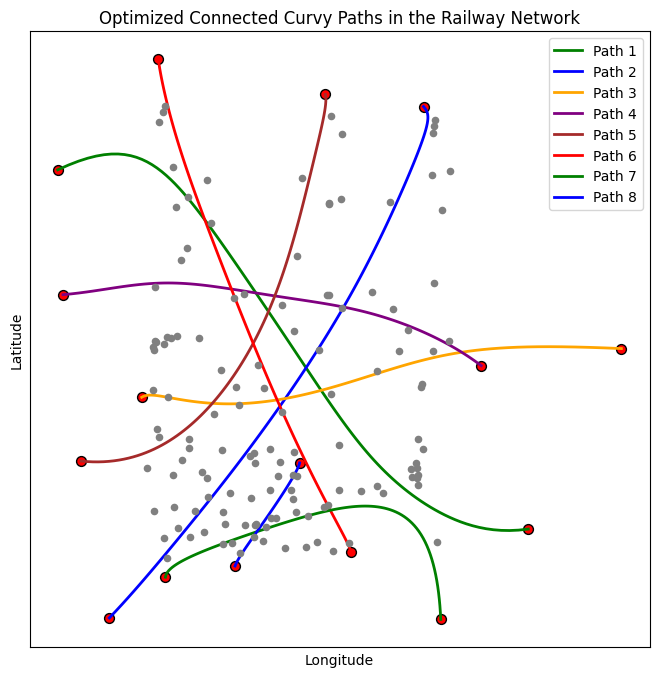

Smooth Paths List:
Path 1:
x: [-0.0413418  -0.04300608 -0.04454818 -0.04598207 -0.04732024 -0.04857386
 -0.04975286 -0.05086606 -0.05192123 -0.05292523 -0.05388407 -0.054803
 -0.05568659 -0.05653885 -0.0573632  -0.05816265 -0.05893978 -0.05969682
 -0.06043571 -0.06115813 -0.06186556 -0.06255929 -0.06324047 -0.06391015
 -0.06456927 -0.0652187  -0.06585929 -0.06649182 -0.06711704 -0.06773572
 -0.06834859 -0.06895638 -0.06955983 -0.07015966 -0.0707566  -0.07135138
 -0.07194472 -0.07253731 -0.07312985 -0.07372302 -0.07431746 -0.07491379
 -0.07551259 -0.0761144  -0.07671973 -0.07732902 -0.07794265 -0.07856098
 -0.07918428 -0.07981275 -0.08044656 -0.0810858  -0.08173047 -0.08238056
 -0.08303595 -0.0836965  -0.08436199 -0.08503216 -0.08570672 -0.08638532
 -0.08706759 -0.08775314 -0.08844158 -0.08913248 -0.08982545 -0.09052011
 -0.09121611 -0.09191312 -0.0926109  -0.09330925 -0.09400808 -0.09470736
 -0.09540722 -0.09610789 -0.09680975 -0.09751336 -0.09821945 -0.09892898
 -0.09964311 -0.1003632

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb

# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
smooth_paths = []  # List to store smoothed paths

# Plot the connected paths with Bézier curves
for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)
    
    # Store the smoothed path in the list as a tuple
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Optimized Connected Curvy Paths in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Output the list of smooth paths
print("Smooth Paths List:")
for idx, path in enumerate(smooth_paths):
    print(f'Path {idx + 1}:')
    print(f'x: {path[:, 0]}, y: {path[:, 1]}')


## landuse region

In [31]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.interpolate import CubicSpline
# from shapely.geometry import LineString, Polygon
# from shapely.ops import split
# import geopandas as gpd
# import matplotlib.cm as cm

# # Create a plot to visualize the connections
# fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

# colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
# smooth_paths = []  # List to store smoothed paths

# # Function to make path curvy using CubicSpline
# def make_path_curvy(path):
#     path_coords = np.array(path)
#     x = path_coords[:, 0]
#     y = path_coords[:, 1]

#     # Fit a cubic spline
#     t = np.linspace(0, 1, len(x))  # Parameterize the points between 0 and 1
#     cs_x = CubicSpline(t, x)  # Spline for x coordinates
#     cs_y = CubicSpline(t, y)  # Spline for y coordinates

#     # Generate more points for a smoother curve
#     t_fine = np.linspace(0, 1, 50)
#     x_fine = cs_x(t_fine)
#     y_fine = cs_y(t_fine)

#     return x_fine, y_fine

# # Plot the connected paths with curves
# for i, path in enumerate(connected_paths):
#     x_fine, y_fine = make_path_curvy(path)
    
#     # Store the smoothed path in the list as a tuple
#     smooth_paths.append((x_fine, y_fine))

#     color = colors[i % len(colors)]  # Use modulo to avoid index out of range
#     ax.plot(x_fine, y_fine, color=color, linewidth=2, label=f'Path {i + 1}')

# # Create a list to hold the LineString geometries of the smooth paths
# line_strings = [LineString(np.column_stack((x, y))) for x, y in smooth_paths]

# # Initialize a list for split regions
# split_regions = [bounding_box]

# # Split the bounding box by the smoothed paths
# for line in line_strings:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the smoothed path
#             result = split(region, line)
#             if result.geom_type == 'GeometryCollection':
#                 for geom in result.geoms:
#                     if isinstance(geom, Polygon):
#                         new_split_regions.append(geom)
#             else:
#                 new_split_regions.extend(result.geoms)  # Use geoms directly
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep the original region if splitting fails
#     split_regions = new_split_regions  # Update the list of regions

# # Create a GeoDataFrame for the final regions
# final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# # Plot the bounding box as a red line region
# bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]})
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5)

# # Assign a color to each region
# num_regions = len(final_regions_gdf)
# colors = cm.viridis(np.linspace(0, 1, num_regions))  # Use the viridis colormap

# # Plot the resulting split regions with distinct colors
# for i, region in enumerate(final_regions_gdf['geometry']):
#     final_regions_gdf.iloc[[i]].plot(ax=ax, color=colors[i], alpha=0.5, edgecolor='black')

# # Optional: Plot only the landmark nodes
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")
# # nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# # Highlight remaining points
# for point in filtered_endpoints:
#     ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# # Set plot title and labels
# plt.title("Regions Divided by Smoothed Paths with Colors")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.legend()

# # Show the plot
# plt.show()

# # Output the list of smooth paths
# print("Smooth Paths List:")
# for idx, (x, y) in enumerate(smooth_paths):
#     print(f'Path {idx + 1}:')
#     print(f'x: {x}, y: {y}')


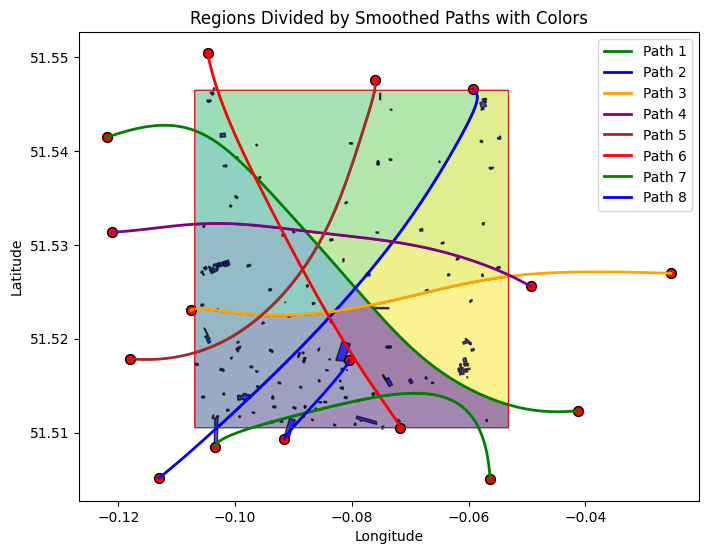

Smooth Paths List:
Path 1:
x: [-0.0413418  -0.04300608 -0.04454818 -0.04598207 -0.04732024 -0.04857386
 -0.04975286 -0.05086606 -0.05192123 -0.05292523 -0.05388407 -0.054803
 -0.05568659 -0.05653885 -0.0573632  -0.05816265 -0.05893978 -0.05969682
 -0.06043571 -0.06115813 -0.06186556 -0.06255929 -0.06324047 -0.06391015
 -0.06456927 -0.0652187  -0.06585929 -0.06649182 -0.06711704 -0.06773572
 -0.06834859 -0.06895638 -0.06955983 -0.07015966 -0.0707566  -0.07135138
 -0.07194472 -0.07253731 -0.07312985 -0.07372302 -0.07431746 -0.07491379
 -0.07551259 -0.0761144  -0.07671973 -0.07732902 -0.07794265 -0.07856098
 -0.07918428 -0.07981275 -0.08044656 -0.0810858  -0.08173047 -0.08238056
 -0.08303595 -0.0836965  -0.08436199 -0.08503216 -0.08570672 -0.08638532
 -0.08706759 -0.08775314 -0.08844158 -0.08913248 -0.08982545 -0.09052011
 -0.09121611 -0.09191312 -0.0926109  -0.09330925 -0.09400808 -0.09470736
 -0.09540722 -0.09610789 -0.09680975 -0.09751336 -0.09821945 -0.09892898
 -0.09964311 -0.1003632

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb
from shapely.geometry import LineString, Polygon
from shapely.ops import split
import geopandas as gpd
import matplotlib.cm as cm
random.seed(7)
# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
smooth_paths = []  # List to store smoothed paths

# Plot the connected paths with Bézier curves
for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)  # Use Bézier curve for smoothing
    
    # Store the smoothed path in the list
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Create a list to hold the LineString geometries of the smooth paths
line_strings = [LineString(curve) for curve in smooth_paths]

# Initialize a list for split regions
split_regions = [bounding_box]

# Split the bounding box by the smoothed paths
for line in line_strings:
    new_split_regions = []
    for region in split_regions:
        try:
            # Split the region by the smoothed path
            result = split(region, line)
            if result.geom_type == 'GeometryCollection':
                for geom in result.geoms:
                    if isinstance(geom, Polygon):
                        new_split_regions.append(geom)
            else:
                new_split_regions.extend(result.geoms)  # Use geoms directly
        except Exception as e:
            print(f"Error splitting region: {e}")
            new_split_regions.append(region)  # Keep the original region if splitting fails
    split_regions = new_split_regions  # Update the list of regions

# Create a GeoDataFrame for the final regions
final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# Plot the bounding box as a red line region
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]})
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5)

# Assign a color to each region
num_regions = len(final_regions_gdf)
colors = cm.viridis(np.linspace(0, 1, num_regions))  # Use the viridis colormap

# Plot the resulting split regions with distinct colors
for i, region in enumerate(final_regions_gdf['geometry']):
    final_regions_gdf.iloc[[i]].plot(ax=ax, color=colors[i], alpha=0.5, edgecolor='black')

# Optional: Plot only the landmark nodes
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")
# nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Regions Divided by Smoothed Paths with Colors")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Output the list of smooth paths
print("Smooth Paths List:")
for idx, path in enumerate(smooth_paths):
    print(f'Path {idx + 1}:')
    print(f'x: {path[:, 0]}, y: {path[:, 1]}')


In [33]:
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import LineString, Polygon, box
# from shapely.ops import split
# import geopandas as gpd
# import matplotlib.cm as cm

# # Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# # Get the bounds from df_E01004736
# min_longitude = df_E01004736['Longitude'].min()
# max_longitude = df_E01004736['Longitude'].max()
# min_latitude = df_E01004736['Latitude'].min()
# max_latitude = df_E01004736['Latitude'].max()

# # Create a bounding box for the area of interest
# bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# # Create a GeoDataFrame for the bounding box
# bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# # Create a plot to visualize the connections
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Plot the bounding box as a red line region
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Convert connected_paths to LineString objects for splitting
# line_strings = [LineString(np.array(path)) for path in connected_paths]

# # Initialize a list for split regions
# split_regions = [bounding_box]

# # Split the bounding box by the straight paths
# for line in line_strings:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the path
#             result = split(region, line)
#             if result.geom_type == 'GeometryCollection':
#                 for geom in result.geoms:
#                     if isinstance(geom, Polygon) and geom.is_valid:
#                         new_split_regions.append(geom)
#             else:
#                 new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep the original region if splitting fails
#     split_regions = new_split_regions  # Update the list of regions

# # Create a GeoDataFrame for the final regions
# final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# # Plot each region with different colors
# colors = cm.get_cmap('tab10', len(final_regions_gdf))  # Get a colormap

# for i, region in final_regions_gdf.iterrows():
#     # Plot the region
#     ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=colors(i), alpha=0.5, edgecolor='black'))

#     # Calculate the area and centroid for labeling IN
#     area = region.geometry.area * 111.32* 111.32
#     centroid = region.geometry.centroid
#     # Label the area at the centroid with 7 decimal places
#     ax.text(centroid.x, centroid.y, f'{area:.7f}', ha='center', va='center', fontsize=8, color='black')

# # Plot the connected paths
# for i, path in enumerate(connected_paths):
#     path_coords = np.array(path)
#     if path_coords.ndim == 2 and path_coords.shape[1] == 2:
#         ax.plot(path_coords[:, 0], path_coords[:, 1], color='black', linewidth=2, label=f'Path {i + 1}')

# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")
# # Show the plot with legend
# plt.legend()
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions with Area Labels and Connected Paths')
# plt.grid()
# plt.show()


Geometry     Function Plot Name  \
0   POLYGON ((-0.05327 51.51298, -0.05327 51.51055...  Residential    Plot 1   
1   POLYGON ((-0.05833 51.51055, -0.07175 51.51055...  Residential    Plot 2   
2   POLYGON ((-0.07175 51.51055, -0.09011 51.51055...  Road System    Plot 3   
3   POLYGON ((-0.09011 51.51055, -0.09694 51.51055...  Road System    Plot 4   
4   POLYGON ((-0.09694 51.51055, -0.10303 51.51055...  Residential    Plot 5   
5   POLYGON ((-0.08295 51.52292, -0.0827 51.52309,...  Road System    Plot 6   
6   POLYGON ((-0.10303 51.51055, -0.10698 51.51055...       Retail    Plot 7   
7   POLYGON ((-0.08435 51.5228, -0.0842 51.52281, ...  Road System    Plot 8   
8   POLYGON ((-0.10698 51.5185, -0.10698 51.52313,...  Road System    Plot 9   
9   POLYGON ((-0.10698 51.52313, -0.10698 51.5322,...  Residential   Plot 10   
10  POLYGON ((-0.09218 51.53179, -0.09202 51.53178...  Road System   Plot 11   
11  POLYGON ((-0.08584 51.52997, -0.08571 51.52988...  Road System   Plot 12   
12  POLYGON ((-0.08435 51.5228, -0.08491 51.52276,...  Road System   Plot 13   
13  POLYGON ((-0.10698 51.5322, -0.10698 51.54218,...  Residential   Plot 14   
14  POLYGON ((-0.09672 51.53739, -0.09611 51.53699...  Road System   Plot 15   
15  POLYGON ((-0.10698 51.54218, -0.10698 51.54653...  Road System   Plot 16   
16  POLYGON ((-0.10302 51.54653, -0.0761 51.54653,...  Residential   Plot 17   
17  POLYGON ((-0.0761 51.54653, -0.05918 51.54653,...       Retail   Plot 18   
18  POLYGON ((-0.07297 51.53033, -0.07339 51.52999...  Road System   Plot 19   
19  POLYGON ((-0.08584 51.52997, -0.08639 51.53035...  Road System   Plot 20   
20  POLYGON ((-0.05918 51.54653, -0.05327 51.54653...  Residential   Plot 21   
21  POLYGON ((-0.05327 51.52682, -0.05327 51.52663...  Residential   Plot 22   
22  POLYGON ((-0.05327 51.52663, -0.05327 51.51298...  Residential   Plot 23   

    Area (km²)  
0     1.616119  
1     0.556329  
2     0.486108  
3     0.068921  
4     1.665280  
5     0.081194  
6     1.744098  
7     0.004789  
8     0.385217  
9     1.847258  
10    0.168173  
11    0.403445  
12    0.316654  
13    1.153384  
14    0.142170  
15    0.432718  
16    3.196513  
17    3.071187  
18    0.483197  
19    0.027040  
20    2.629500  
21    1.128202  
22    2.339703

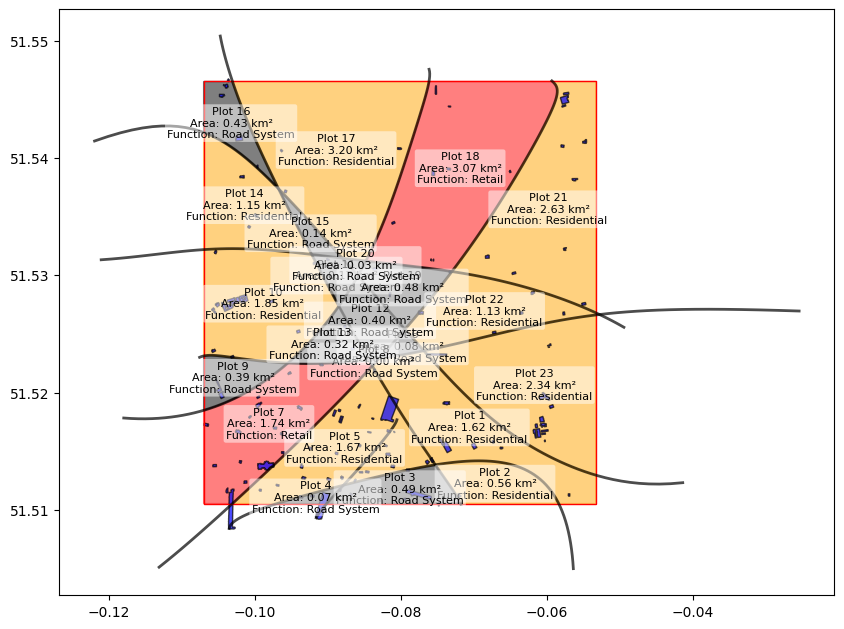

In [96]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon, box
from shapely.ops import split
import geopandas as gpd
import matplotlib.cm as cm
from scipy.special import comb

# Set the random seed for consistency
retail_plots = [6,17] 
# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# Get the bounds from df_E01004736
min_longitude = df_E01004736['Longitude'].min()
max_longitude = df_E01004736['Longitude'].max()
min_latitude = df_E01004736['Latitude'].min()
max_latitude = df_E01004736['Latitude'].max()

# Create a bounding box for the area of interest
bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# Create a GeoDataFrame for the bounding box
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the bounding box as a red line region
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# Create a list to hold the smoothed paths
smooth_paths = []

# Convert connected_paths to Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='black', linewidth=2, alpha=0.7)

# Initialize a list for split regions
split_regions = [bounding_box]

# Split the bounding box by the smoothed paths
for curve in smooth_paths:
    line = LineString(curve)
    new_split_regions = []
    for region in split_regions:
        try:
            # Split the region by the smoothed path
            result = split(region, line)
            if result.geom_type == 'GeometryCollection':
                for geom in result.geoms:
                    if isinstance(geom, Polygon) and geom.is_valid:
                        new_split_regions.append(geom)
            else:
                new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
        except Exception as e:
            print(f"Error splitting region: {e}")
            new_split_regions.append(region)  # Keep the original region if splitting fails
    split_regions = new_split_regions  # Update the list of regions

# Create a GeoDataFrame for the final regions
final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# Calculate areas and add them to the GeoDataFrame
final_regions_gdf['Area (km²)'] = final_regions_gdf.geometry.area * 111.32 * 111.32  # Calculate the area in km²

# Create lists for the functions, colors, and plot names
functions = []
colors = []
plot_names = []  # List to hold plot names

for i, region in final_regions_gdf.iterrows():
    # Determine the function based on area and specific plot indices
    area_km2 = region.geometry.area * 111.32 * 111.32  # Calculate the area in km²
    if area_km2 < 0.5:
        functions.append('Road System')
        colors.append('black')  # Color for roads
    elif i in retail_plots:  # If it's one of the specified plots for retail
        functions.append('Retail')
        colors.append('red')  # Color for retail
    else:
        functions.append('Residential')
        colors.append('orange')  # Color for commercial

    # Assign plot names based on indices
    plot_names.append(f'Plot {i + 1}')  # Plot names like 'Plot 1', 'Plot 2', etc.

# Add the functions, colors, and plot names to the GeoDataFrame
final_regions_gdf['Function'] = functions
final_regions_gdf['Color'] = colors
final_regions_gdf['Plot Name'] = plot_names

# Plot each region with its corresponding color
for i, region in final_regions_gdf.iterrows():
    # Plot the region
    ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.5, edgecolor='black'))

    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["Plot Name"]}\nArea: {region["Area (km²)"]:.2f} km²\nFunction: {region.Function}', 
            ha='center', va='center', fontsize=8, color='black', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# Create a DataFrame with geometry, function, plot name, and area
data = {
    'Geometry': final_regions_gdf['geometry'],
    'Function': final_regions_gdf['Function'],
    'Plot Name': final_regions_gdf['Plot Name'],
    'Area (km²)': final_regions_gdf['Area (km²)']
}
regions_df = pd.DataFrame(data)

# Display the DataFrame
regions_df




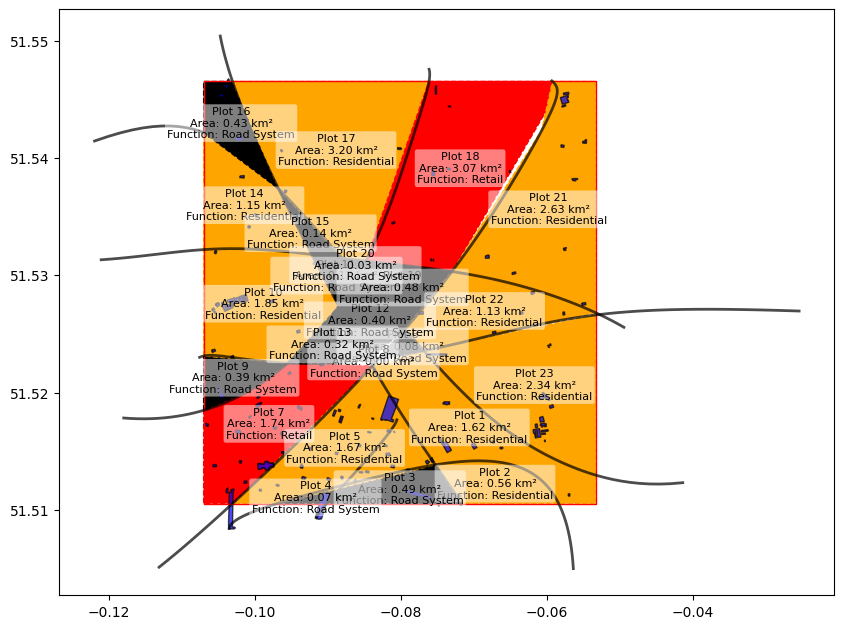

Plot 1 - Original Vertices: 107, Simplified Vertices: 9
Plot 2 - Original Vertices: 56, Simplified Vertices: 5
Plot 3 - Original Vertices: 62, Simplified Vertices: 5
Plot 4 - Original Vertices: 38, Simplified Vertices: 4
Plot 5 - Original Vertices: 88, Simplified Vertices: 5
Plot 6 - Original Vertices: 22, Simplified Vertices: 5
Plot 7 - Original Vertices: 70, Simplified Vertices: 6
Plot 8 - Original Vertices: 8, Simplified Vertices: 5
Plot 9 - Original Vertices: 50, Simplified Vertices: 5
Plot 10 - Original Vertices: 76, Simplified Vertices: 6
Plot 11 - Original Vertices: 30, Simplified Vertices: 5
Plot 12 - Original Vertices: 41, Simplified Vertices: 6
Plot 13 - Original Vertices: 46, Simplified Vertices: 5
Plot 14 - Original Vertices: 50, Simplified Vertices: 5
Plot 15 - Original Vertices: 34, Simplified Vertices: 5
Plot 16 - Original Vertices: 39, Simplified Vertices: 5
Plot 17 - Original Vertices: 81, Simplified Vertices: 6
Plot 18 - Original Vertices: 106, Simplified Vertices: 6


geometry  \
0   POLYGON ((-0.05327 51.51298, -0.05327 51.51055...   
1   POLYGON ((-0.05833 51.51055, -0.07175 51.51055...   
2   POLYGON ((-0.07175 51.51055, -0.09011 51.51055...   
3   POLYGON ((-0.09011 51.51055, -0.09694 51.51055...   
4   POLYGON ((-0.09694 51.51055, -0.10303 51.51055...   
5   POLYGON ((-0.08295 51.52292, -0.0827 51.52309,...   
6   POLYGON ((-0.10303 51.51055, -0.10698 51.51055...   
7   POLYGON ((-0.08435 51.5228, -0.0842 51.52281, ...   
8   POLYGON ((-0.10698 51.5185, -0.10698 51.52313,...   
9   POLYGON ((-0.10698 51.52313, -0.10698 51.5322,...   
10  POLYGON ((-0.09218 51.53179, -0.09202 51.53178...   
11  POLYGON ((-0.08584 51.52997, -0.08571 51.52988...   
12  POLYGON ((-0.08435 51.5228, -0.08491 51.52276,...   
13  POLYGON ((-0.10698 51.5322, -0.10698 51.54218,...   
14  POLYGON ((-0.09672 51.53739, -0.09611 51.53699...   
15  POLYGON ((-0.10698 51.54218, -0.10698 51.54653...   
16  POLYGON ((-0.10302 51.54653, -0.0761 51.54653,...   
17  POLYGON ((-0.0761 51.54653, -0.05918 51.54653,...   
18  POLYGON ((-0.07297 51.53033, -0.07339 51.52999...   
19  POLYGON ((-0.08584 51.52997, -0.08639 51.53035...   
20  POLYGON ((-0.05918 51.54653, -0.05327 51.54653...   
21  POLYGON ((-0.05327 51.52682, -0.05327 51.52663...   
22  POLYGON ((-0.05327 51.52663, -0.05327 51.51298...   

                                  simplified geometry     function Plot Name  \
0   POLYGON ((-0.05327 51.51298, -0.05327 51.51055...  Residential    Plot 1   
1   POLYGON ((-0.05833 51.51055, -0.07175 51.51055...  Residential    Plot 2   
2   POLYGON ((-0.07175 51.51055, -0.09011 51.51055...  Road System    Plot 3   
3   POLYGON ((-0.09011 51.51055, -0.09694 51.51055...  Road System    Plot 4   
4   POLYGON ((-0.09694 51.51055, -0.10303 51.51055...  Residential    Plot 5   
5   POLYGON ((-0.08295 51.52292, -0.0794 51.52541,...  Road System    Plot 6   
6   POLYGON ((-0.10303 51.51055, -0.10698 51.51055...       Retail    Plot 7   
7   POLYGON ((-0.08435 51.5228, -0.08348 51.52287,...  Road System    Plot 8   
8   POLYGON ((-0.10698 51.5185, -0.10698 51.52313,...  Road System    Plot 9   
9   POLYGON ((-0.10698 51.52313, -0.10698 51.5322,...  Residential   Plot 10   
10  POLYGON ((-0.09218 51.53179, -0.08798 51.53147...  Road System   Plot 11   
11  POLYGON ((-0.08584 51.52997, -0.08304 51.52799...  Road System   Plot 12   
12  POLYGON ((-0.08435 51.5228, -0.08972 51.52252,...  Road System   Plot 13   
13  POLYGON ((-0.10698 51.5322, -0.10698 51.54218,...  Residential   Plot 14   
14  POLYGON ((-0.09672 51.53739, -0.09331 51.53514...  Road System   Plot 15   
15  POLYGON ((-0.10698 51.54218, -0.10698 51.54653...  Road System   Plot 16   
16  POLYGON ((-0.10302 51.54653, -0.0761 51.54653,...  Residential   Plot 17   
17  POLYGON ((-0.0761 51.54653, -0.05918 51.54653,...       Retail   Plot 18   
18  POLYGON ((-0.07297 51.53033, -0.0794 51.52541,...  Road System   Plot 19   
19  POLYGON ((-0.08584 51.52997, -0.08707 51.53083...  Road System   Plot 20   
20  POLYGON ((-0.05918 51.54653, -0.05327 51.54653...  Residential   Plot 21   
21  POLYGON ((-0.05327 51.52682, -0.07681 51.52358...  Residential   Plot 22   
22  POLYGON ((-0.05327 51.52663, -0.05327 51.51298...  Residential   Plot 23   

    Area (km²)  original vertices  simplified vertices  
0     1.616119                107                    9  
1     0.556329                 56                    5  
2     0.486108                 62                    5  
3     0.068921                 38                    4  
4     1.665280                 88                    5  
5     0.081194                 22                    5  
6     1.744098                 70                    6  
7     0.004789                  8                    5  
8     0.385217                 50                    5  
9     1.847258                 76                    6  
10    0.168173                 30                    5  
11    0.403445                 41                    6  
12    0.316654

In [97]:
import random
from shapely.geometry import LineString, Polygon, box
from shapely.ops import split
import matplotlib.cm as cm
from scipy.special import comb

# Set the random seed for consistency
random.seed(7)

# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# Get the bounds from df_E01004736
min_longitude = df_E01004736['Longitude'].min()
max_longitude = df_E01004736['Longitude'].max()
min_latitude = df_E01004736['Latitude'].min()
max_latitude = df_E01004736['Latitude'].max()

# Create a bounding box for the area of interest
bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# Create a GeoDataFrame for the bounding box
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the bounding box as a red line region
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# Create a list to hold the smoothed paths
smooth_paths = []

# Convert connected_paths to Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='black', linewidth=2, alpha=0.7, label='Original Curvy Path')

# Initialize a list for split regions
split_regions = [bounding_box]

# Split the bounding box by the smoothed paths
for curve in smooth_paths:
    line = LineString(curve)
    new_split_regions = []
    for region in split_regions:
        try:
            # Split the region by the smoothed path
            result = split(region, line)
            if result.geom_type == 'GeometryCollection':
                for geom in result.geoms:
                    if isinstance(geom, Polygon) and geom.is_valid:
                        new_split_regions.append(geom)
            else:
                new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
        except Exception as e:
            print(f"Error splitting region: {e}")
            new_split_regions.append(region)  # Keep the original region if splitting fails
    split_regions = new_split_regions  # Update the list of regions

# Create a GeoDataFrame for the final regions
final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# Calculate areas and add them to the GeoDataFrame
final_regions_gdf['Area (km²)'] = final_regions_gdf.geometry.area * 111.32 * 111.32  # Calculate the area in km²

# Function to simplify geometries
def simplify_geometry(geometry, tolerance=0.001):
    return geometry.simplify(tolerance, preserve_topology=True)

# Simplify the geometries in the final regions GeoDataFrame
final_regions_gdf['simplified_geometry'] = final_regions_gdf['geometry'].apply(simplify_geometry)

# Create lists for the functions, colors, and plot names
functions = []
colors = []
plot_names = []  # List to hold plot names

for i, region in final_regions_gdf.iterrows():
    # Determine the function based on area and specific plot indices
    area_km2 = region.geometry.area * 111.32 * 111.32  # Calculate the area in km²
    if area_km2 < 0.5:
        functions.append('Road System')
        colors.append('black')  # Color for roads
    elif i in retail_plots:  # If it's one of the specified plots for retail
        functions.append('Retail')
        colors.append('red')  # Color for retail
    else:
        functions.append('Residential')
        colors.append('orange')  # Color for commercial

    # Assign plot names based on indices
    plot_names.append(f'Plot {i + 1}')  # Plot names like 'Plot 1', 'Plot 2', etc.

# Add the functions, colors, and plot names to the GeoDataFrame
final_regions_gdf['Function'] = functions
final_regions_gdf['Color'] = colors
final_regions_gdf['Plot Name'] = plot_names

# Plot each simplified region with its corresponding color and original geometry
for i, region in final_regions_gdf.iterrows():
    # Plot the original region
   #  ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.7, edgecolor='blue', label='Original Geometry' if i == 0 else ""))

    # Plot the simplified region with a different style
    ax.add_patch(plt.Polygon(np.array(region.simplified_geometry.exterior.coords), color=region.Color, alpha=1, edgecolor='black', linestyle='--', label='Simplified Geometry' if i == 0 else ""))

    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["Plot Name"]}\nArea: {region["Area (km²)"]:.2f} km²\nFunction: {region.Function}', 
            ha='center', va='center', fontsize=8, color='black', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# Display the plot
plt.show()

# Print the number of vertices for each simplified geometry
for i, region in final_regions_gdf.iterrows():
    original_vertices = len(region.geometry.exterior.coords)
    simplified_vertices = len(region.simplified_geometry.exterior.coords)
    print(f'Plot {i + 1} - Original Vertices: {original_vertices}, Simplified Vertices: {simplified_vertices}')

# Create a DataFrame with geometry, function, plot name, area, and vertices
data = {
    'geometry': final_regions_gdf['geometry'],
    'simplified geometry': final_regions_gdf['simplified_geometry'],
    'function': final_regions_gdf['Function'],
    'Plot Name': final_regions_gdf['Plot Name'],
    'Area (km²)': final_regions_gdf['Area (km²)'],
    'original vertices': final_regions_gdf['geometry'].apply(lambda geom: len(geom.exterior.coords)),
    'simplified vertices': final_regions_gdf['simplified_geometry'].apply(lambda geom: len(geom.exterior.coords))
}
regions_df = pd.DataFrame(data)

# Display the DataFrame
regions_df


Plot 1 - Longest Edge Length: 0.01, Midpoint: [-0.07101348274076572, 51.52013225842008]
Plot 2 - Longest Edge Length: 0.01, Midpoint: [-0.06504365204662894, 51.51055]
Plot 3 - Longest Edge Length: 0.02, Midpoint: [-0.08093222192208446, 51.51055]
Plot 4 - Longest Edge Length: 0.01, Midpoint: [-0.09237714251970167, 51.51133428973495]
Plot 5 - Longest Edge Length: 0.02, Midpoint: [-0.0934527465277249, 51.51641958761214]
Plot 6 - Longest Edge Length: 0.00, Midpoint: [-0.08117370122351195, 51.524161599984794]
Plot 7 - Longest Edge Length: 0.02, Midpoint: [-0.0934527465277249, 51.51641958761214]
Plot 8 - Longest Edge Length: 0.00, Midpoint: [-0.0834095738998655, 51.522602987722124]
Plot 9 - Longest Edge Length: 0.01, Midpoint: [-0.101210412612842, 51.52282950534966]
Plot 10 - Longest Edge Length: 0.01, Midpoint: [-0.0995775262137511, 51.53199316389034]
Plot 11 - Longest Edge Length: 0.01, Midpoint: [-0.0903137068519686, 51.529586031442705]
Plot 12 - Longest Edge Length: 0.01, Midpoint: [-0.0

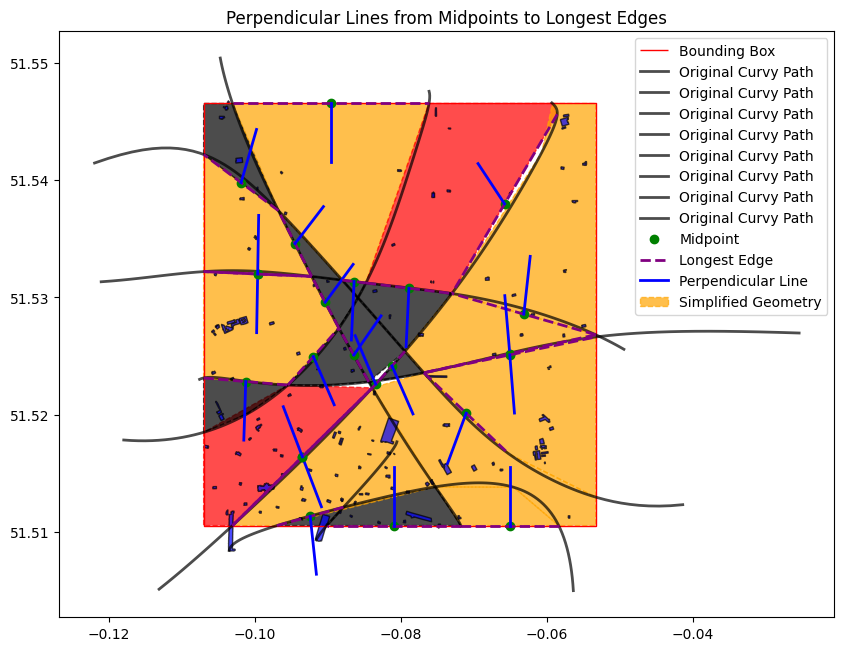

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import matplotlib.patches as patches

# Function to find the longest edge and its midpoint
def find_longest_edge(geometry):
    coords = list(geometry.exterior.coords)
    longest_edge = None
    max_length = 0
    mid_point = None

    for i in range(len(coords) - 1):  # Iterate through the edges (lines between consecutive points)
        p1, p2 = coords[i], coords[i + 1]
        edge_length = np.linalg.norm(np.array(p1) - np.array(p2))  # Compute the Euclidean distance

        if edge_length > max_length:
            max_length = edge_length
            longest_edge = (p1, p2)
            # Calculate the midpoint of the longest edge
            mid_point = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    return longest_edge, mid_point, max_length

# Function to find the longest edge and its midpoint
def find_shortest_edge(geometry):
    coords = list(geometry.exterior.coords)
    shortest_edge = None
    min_length = 10000
    mid_point = None

    for i in range(len(coords) - 1):  # Iterate through the edges (lines between consecutive points)
        p1, p2 = coords[i], coords[i + 1]
        edge_length = np.linalg.norm(np.array(p1) - np.array(p2))  # Compute the Euclidean distance

        if edge_length < min_length:
            min_length = edge_length
            shortest_edge = (p1, p2)
            # Calculate the midpoint of the longest edge
            mid_point = [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]

    return shortest_edge, mid_point, min_length

# Function to calculate the perpendicular vector
def perpendicular_vector(p1, p2):
    # Compute the direction vector of the longest edge
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    # Rotate by 90 degrees to get the perpendicular vector
    perp_vector = np.array([-dy, dx])
    # Normalize the vector to have a consistent length
    norm = np.linalg.norm(perp_vector)
    return perp_vector / norm if norm != 0 else perp_vector

# Function to ensure the perpendicular line points inside the geometry
def ensure_direction_to_interior(mid_point, perp_vector, geometry):
    # Create a point slightly along the perpendicular direction
    test_point = Point(mid_point + 0.01 * perp_vector)
    # If the test point is outside the geometry, reverse the vector
    if not geometry.contains(test_point):
        perp_vector = -perp_vector
    return perp_vector

# Initialize lists to hold the midpoints and smoothed paths
mid_points = []
smooth_paths = []

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the bounding box again
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='black', linewidth=2, alpha=0.7, label='Original Curvy Path')

# Iterate over each region and find the longest edge of the simplified geometry
for i, region in final_regions_gdf.iterrows():
    longest_edge, mid_point, edge_length = find_longest_edge(region['simplified_geometry'])
    
    if mid_point:
        # Store the midpoint for later use
        mid_points.append(mid_point)
        print(f"Plot {i + 1} - Longest Edge Length: {edge_length:.2f}, Midpoint: {mid_point}")

        # Plot the midpoint
        ax.plot(mid_point[0], mid_point[1], 'o', color='green', label='Midpoint' if i == 0 else "")

        # Plot the longest edge
        ax.plot([longest_edge[0][0], longest_edge[1][0]], [longest_edge[0][1], longest_edge[1][1]],
                color='purple', linestyle='--', linewidth=2, label='Longest Edge' if i == 0 else "")

        # Get the perpendicular vector and ensure it points to the interior of the geometry
        perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
        perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, region['simplified_geometry'])

        # Define the length of the perpendicular line
        perp_length = 0.005  # Adjust this value to control the length of the perpendicular line

        # Calculate the end point of the perpendicular line
        end_point = np.array(mid_point) + perp_length * perp_vector

        # Plot the perpendicular line
        ax.plot([mid_point[0], end_point[0]], [mid_point[1], end_point[1]], color='blue', linewidth=2, label='Perpendicular Line' if i == 0 else "")

# Plot the simplified geometries
for i, region in final_regions_gdf.iterrows():
    ax.add_patch(plt.Polygon(np.array(region.simplified_geometry.exterior.coords), color=region.Color, alpha=0.7, edgecolor='black', linestyle='--', label='Simplified Geometry' if i == 0 else ""))

# Re-plot buildings for visibility
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# Final adjustments to the plot
ax.set_title("Perpendicular Lines from Midpoints to Longest Edges")
ax.legend()

# Show the plot with midpoints, longest edges, and perpendicular lines
plt.show()


Plot 1 - Longest Edge Length: 0.01, Midpoint: [-0.07101348274076572, 51.52013225842008]
Combined line intersects region 1.
Plot 2 - Longest Edge Length: 0.01, Midpoint: [-0.06504365204662894, 51.51055]
Combined line intersects region 2.
Plot 3 is a road system, skipping the split but storing the geometry.
Plot 4 is a road system, skipping the split but storing the geometry.
Plot 5 - Longest Edge Length: 0.02, Midpoint: [-0.0934527465277249, 51.51641958761214]
Combined line intersects region 5.
Plot 6 is a road system, skipping the split but storing the geometry.
Plot 7 - Longest Edge Length: 0.02, Midpoint: [-0.0934527465277249, 51.51641958761214]
Combined line intersects region 7.
Plot 8 is a road system, skipping the split but storing the geometry.
Plot 9 is a road system, skipping the split but storing the geometry.
Plot 10 - Longest Edge Length: 0.01, Midpoint: [-0.0995775262137511, 51.53199316389034]
Combined line intersects region 10.
Plot 11 is a road system, skipping the split 

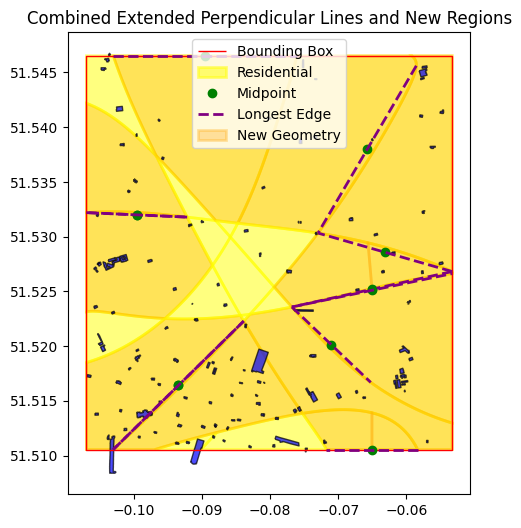

geometry  plot_name     function  \
0   POLYGON ((-0.053266 51.51298062597145, -0.0532...   Region 1  Residential   
1   POLYGON ((-0.053266 51.51298062597145, -0.0532...   Region 1  Residential   
2   POLYGON ((-0.05833402184803 51.51055, -0.07175...   Region 2  Residential   
3   POLYGON ((-0.05833402184803 51.51055, -0.06504...   Region 2  Residential   
4   POLYGON ((-0.0650436520466289 51.51055, -0.071...   Region 2  Residential   
5   POLYGON ((-0.0717532822452279 51.51055, -0.090...   Region 3  Road System   
6   POLYGON ((-0.090111161598941 51.51055, -0.0969...   Region 4  Road System   
7   POLYGON ((-0.0969358601327255 51.51055, -0.103...   Region 5  Residential   
8   POLYGON ((-0.0969358601327255 51.51055, -0.103...   Region 5  Residential   
9   POLYGON ((-0.08294818504795 51.522916800219974...   Region 6  Road System   
10  POLYGON ((-0.1030345303036688 51.51055, -0.106...   Region 7       Retail   
11  POLYGON ((-0.1030345303036688 51.51055, -0.106...   Region 7       Retail   
12  POLYGON ((-0.0843504536366519 51.5228031002326...   Region 8  Road System   
13  POLYGON ((-0.106978 51.51850007804783, -0.1069...   Region 9  Road System   
14  POLYGON ((-0.106978 51.523133326988045, -0.106...  Region 10  Residential   
15  POLYGON ((-0.106978 51.523133326988045, -0.106...  Region 10  Residential   
16  POLYGON ((-0.0921770524275022 51.5317878466875...  Region 11  Road System   
17  POLYGON ((-0.0858367968991986 51.5299684002913...  Region 12  Road System   
18  POLYGON ((-0.0843504536366519 51.5228031002326...  Region 13  Road System   
19  POLYGON ((-0.106978 51.532198481093175, -0.106...  Region 14  Residential   
20  POLYGON ((-0.106978 51.532198481093175, -0.106...  Region 14  Residential   
21  POLYGON ((-0.0967228408172771 51.5373890115313...  Region 15  Road System   
22  POLYGON ((-0.106978 51.5421815976164, -0.10697...  Region 16  Road System   
23  POLYGON ((-0.1030238136653185 51.546528, -0.07...  Region 17  Residential   
24  POLYGON ((-0.1030238136653185 51.546528, -0.08...  Region 17  Residential   
25  POLYGON ((-0.0761042176645665 51.546528, -0.05...  Region 18       Retail   
26  POLYGON ((-0.0761042176645665 51.546528, -0.05...  Region 18       Retail   
27  POLYGON ((-0.0729654676245192 51.5303295560001...  Region 19  Road System   
28  POLYGON ((-0.0858367968991986 51.5299684002913...  Region 20  Road System   
29  POLYGON ((-0.0591815881868048 51.546528, -0.05...  Region 21  Residential   
30  POLYGON ((-0.0591815881868048 51.546528, -0.05...  Region 21  Residential   
31  POLYGON ((-0.053266 51.52681787320807, -0.0532...  Region 22  Residential   
32  POLYGON ((-0.053266 51.52681787320807, -0.0532...  Region 22  Residential   
33  POLYGON ((-0.0650457723983826 51.5252599393549...  Region 22  Residential   
34  POLYGON ((-0.053266 51.52662610711142, -0.0532...  Region 23  Residential   
35  POLYGON ((-0.053266 51.52662610711142, -0.0532...  Region 23  Residential   

            area  original_plot_number  
0   1.304148e-04                     1  
1   1.304148e-04                     1  
2   4.489366e-05                     2  
3   1.486024e-05                     2  
4   3.003342e-05                     2  
5   3.922711e-05                     3  
6   5.561631e-06                     4  
7   1.343819e-04                     5  
8   1.343819e-04                     5  
9   6.552084e-06                     6  
10  1.407423e-04                     7  
11  1.407423e-04                     7  
12  3.864785e-07                     8  
13  3.108560e-05                     9  
14  1.490668e-04                    10  
15  1.490668e-04                    10  
16  1.357093e-05                    11  
17  3.255652e-05                    12  
18  2.555282e-05                    13  
19  9.307379e-05                    14  
20  9.307379e-05                    14  
21  1.147260e-05                    15  
22  3.491873e-05                    16  
23  2.579468e-04                    17  
24  2.579468e-04      

In [99]:
# Initialize a list to store new geometries' information
new_geometries_data = []

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size as needed

# Plot the bounding box again
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# Iterate over each region and find the longest edge of the simplified geometry
for i, region in final_regions_gdf.iterrows():
    
    # Always store the original geometry with its original function
    new_geometries_data.append({
        'geometry': region['geometry'],
        'plot_name': f"Region {i + 1}",
        'function': region['Function'],  # Store the original function (e.g., residential, retail)
        'area': region['geometry'].area,
        'original_plot_number': i + 1  # Store the original plot number
    })

    # Plot the original region geometry
    ax.add_patch(plt.Polygon(np.array(region['geometry'].exterior.coords), color='yellow', alpha=0.5, edgecolor='black', linewidth=2, label=region['Function'] if i == 0 else ""))

    # Skip splitting for road systems
    if region['Function'] == 'Road System':
        print(f"Plot {i + 1} is a road system, skipping the split but storing the geometry.")
        continue  # Skip the splitting process for road systems

    # Now process the splitting for non-road geometries
    longest_edge, mid_point, edge_length = find_longest_edge(region['simplified_geometry'])

    if mid_point:
        mid_points.append(mid_point)
        print(f"Plot {i + 1} - Longest Edge Length: {edge_length:.2f}, Midpoint: {mid_point}")

        ax.plot(mid_point[0], mid_point[1], 'o', color='green', label='Midpoint' if i == 0 else "")
        ax.plot([longest_edge[0][0], longest_edge[1][0]], [longest_edge[0][1], longest_edge[1][1]],
                color='purple', linestyle='--', linewidth=2, label='Longest Edge' if i == 0 else "")

        perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
        perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, region['simplified_geometry'])

        # Define lengths for extending the perpendicular lines (increased length for visibility)
        perp_length_exterior = 0.001  # Increased length
        perp_length_interior = 0.01

        # Calculate end points of the extended perpendicular line
        end_point_interior = np.array(mid_point) + perp_length * perp_vector
        end_point_exterior = np.array(mid_point) - perp_length * perp_vector

        # Create a line representing the perpendicular
        combined_line = LineString([end_point_exterior, end_point_interior])

        # Check if the combined line intersects the geometry
        if region['simplified_geometry'].intersects(combined_line):
            print(f"Combined line intersects region {i + 1}.")
            # Use shapely's split function to split the geometry
            new_geometries = split(region['geometry'], combined_line)

            # Check if the result is a GeometryCollection
            if new_geometries.geom_type == 'GeometryCollection':
                for geom in new_geometries.geoms:  # Iterate through geometries in the collection
                    if isinstance(geom, Polygon):
                        # Add split geometry information, including the original function
                        new_geometries_data.append({
                            'geometry': geom,
                            'plot_name': f"Region {i + 1}",
                            'function': region['Function'],  # Keep the original function (e.g., residential, retail)
                            'area': geom.area,
                            'original_plot_number': i + 1  # Store the original plot number
                        })
                        ax.add_patch(plt.Polygon(np.array(geom.exterior.coords), color='orange', alpha=0.3, edgecolor='white', linewidth=2, label='New Geometry' if i == 0 else ""))
        else:
            print(f"Combined line does NOT intersect region {i + 1}.")

# Re-plot buildings for visibility
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# Final adjustments to the plot
ax.set_title("Combined Extended Perpendicular Lines and New Regions")
plt.legend()
plt.show()

# Create a DataFrame for the new geometries
new_geometries_df = pd.DataFrame(new_geometries_data)

# Display the new geometries DataFrame
new_geometries_df


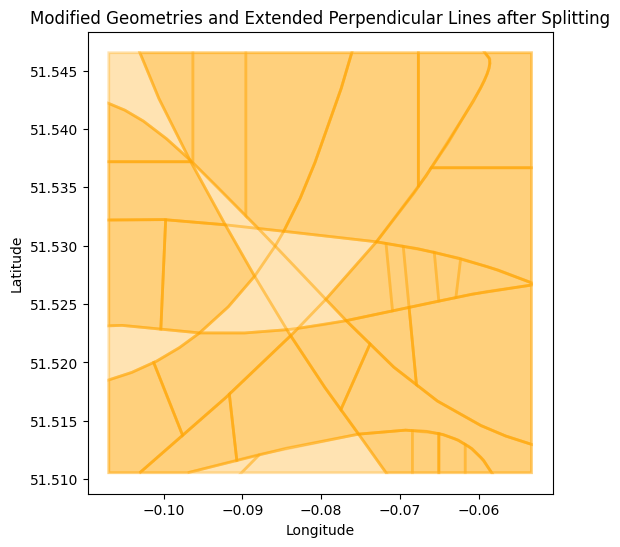

geometry  plot_name     function  \
0   POLYGON ((-0.053266 51.51298062597145, -0.0532...   Region 1  Residential   
1   POLYGON ((-0.0774898840167497 51.5159552773605...   Region 1  Residential   
2   POLYGON ((-0.053266 51.51298062597145, -0.0532...   Region 1  Residential   
3   POLYGON ((-0.0774898840167497 51.5159552773605...   Region 1  Residential   
4   POLYGON ((-0.05833402184803 51.51055, -0.06504...   Region 2  Residential   
5   POLYGON ((-0.0650436520466289 51.51055, -0.071...   Region 2  Residential   
6   POLYGON ((-0.05833402184803 51.51055, -0.06168...   Region 2  Residential   
7   POLYGON ((-0.0616888369473295 51.51055, -0.065...   Region 2  Residential   
8   POLYGON ((-0.0650436520466289 51.51055, -0.068...   Region 2  Residential   
9   POLYGON ((-0.0683984671459284 51.51055, -0.071...   Region 2  Residential   
10  POLYGON ((-0.0717532822452279 51.51055, -0.090...   Region 3  Road System   
11  POLYGON ((-0.090111161598941 51.51055, -0.0969...   Region 4  Road System   
12  POLYGON ((-0.0969358601327255 51.51055, -0.103...   Region 5  Residential   
13  POLYGON ((-0.0916623738061538 51.5172791709989...   Region 5  Residential   
14  POLYGON ((-0.0969358601327255 51.51055, -0.103...   Region 5  Residential   
15  POLYGON ((-0.0916623738061538 51.5172791709989...   Region 5  Residential   
16  POLYGON ((-0.08294818504795 51.522916800219974...   Region 6  Road System   
17  POLYGON ((-0.1030345303036688 51.51055, -0.106...   Region 7       Retail   
18  POLYGON ((-0.1012735997116829 51.519993968927,...   Region 7       Retail   
19  POLYGON ((-0.1030345303036688 51.51055, -0.106...   Region 7       Retail   
20  POLYGON ((-0.1012735997116829 51.519993968927,...   Region 7       Retail   
21  POLYGON ((-0.0843504536366519 51.5228031002326...   Region 8  Road System   
22  POLYGON ((-0.106978 51.51850007804783, -0.1069...   Region 9  Road System   
23  POLYGON ((-0.106978 51.523133326988045, -0.106...  Region 10  Residential   
24  POLYGON ((-0.0997506098421102 51.5322202979912...  Region 10  Residential   
25  POLYGON ((-0.106978 51.523133326988045, -0.106...  Region 10  Residential   
26  POLYGON ((-0.0997506098421102 51.5322202979912...  Region 10  Residential   
27  POLYGON ((-0.0921770524275022 51.5317878466875...  Region 11  Road System   
28  POLYGON ((-0.0858367968991986 51.5299684002913...  Region 12  Road System   
29  POLYGON ((-0.0843504536366519 51.5228031002326...  Region 13  Road System   
30  POLYGON ((-0.106978 51.532198481093175, -0.106...  Region 14  Residential   
31  POLYGON ((-0.106978 51.53719003935478, -0.1069...  Region 14  Residential   
32  POLYGON ((-0.106978 51.532198481093175, -0.106...  Region 14  Residential   
33  POLYGON ((-0.106978 51.53719003935478, -0.1069...  Region 14  Residential   
34  POLYGON ((-0.0967228408172771 51.5373890115313...  Region 15  Road System   
35  POLYGON ((-0.106978 51.5421815976164, -0.10697...  Region 16  Road System   
36  POLYGON ((-0.1030238136653185 51.546528, -0.08...  Region 17  Residential   
37  POLYGON ((-0.0895640156649425 51.546528, -0.07...  Region 17  Residential   
38  POLYGON ((-0.1030238136653185 51.546528, -0.09...  Region 17  Residential   
39  POLYGON ((-0.0962939146651305 51.546528, -0.08...  Region 17  Residential   
40  POLYGON ((-0.0761042176645665 51.546528, -0.06...  Region 18       Retail   
41  POLYGON ((-0.0676429029256857 51.546528, -0.05...  Region 18       Retail   
42  POLYGON ((-0.0761042176645665 51.546528, -0.06...  Region 18       Retail   
43  POLYGON ((-0.0676429029256857 51.546528, -0.05...  Region 18       Retail   
44  POLYGON ((-0.0729654676245192 51.5303295560001...  Region 19  Road System   
45  POLYGON ((-0.0858367968991986 51.5299684002913...  Region 20  Road System   
46  POLYGON ((-0.0591815881868048 51.546528, -0.05...  Region 21  Residential   
47  POLYGON ((-0.053266 51.536672936604035, -0.053...  Region 21  Residential   
48  POLYGON ((-0.0591815881868048 51.546528, -0.05...  Region 21  Residentia

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point

# Function to simplify geometry and print the number of vertices
def simplify_geometry(geometry, tolerance=0.0001):
    simplified_geom = geometry.simplify(tolerance, preserve_topology=True)
    return simplified_geom

# Initialize a new list to store further modified geometries after the new splitting logic
modified_geometries_data = []
perpendicular_lines = []  # Store perpendicular lines for plotting

# Function to process and split geometries based on longest edge conditions
def process_geometry_based_on_function(geometry, function, plot_name, original_plot_number):
    # Simplify the geometry first
    geometry = simplify_geometry(geometry)

    # Calculate the longest edge, midpoint, and edge length for the geometry
    longest_edge, mid_point, edge_length = find_longest_edge(geometry)

    # Determine the splitting criteria based on the function
    if function == 'Retail' and edge_length > 0.0025:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number)
    elif function == 'Residential' and edge_length > 0.005:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number)
    else:
        # If no splitting is required, store the geometry as is
        return [{
            'geometry': geometry,
            'plot_name': plot_name,
            'function': function,
            'area': geometry.area,
            'original_plot_number': original_plot_number
        }]

# Function to perform the actual geometry splitting and store the results
def split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number):
    split_results = []

    # Perform the splitting only if the midpoint exists
    if mid_point:
        perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
        perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, geometry)

        # Set lengths for extending the perpendicular lines
        extension_length = 0.0001  # Length to extend the line outside the boundary
        perp_length = 0.1  # Length of the perpendicular line itself (adjust if necessary)

        # Calculate end points of the perpendicular line
        end_point_interior = np.array(mid_point) + perp_length * perp_vector
        end_point_exterior = np.array(mid_point) - perp_length * perp_vector

        # Create the initial combined line
        combined_line = LineString([end_point_exterior, end_point_interior])

        # Check if the combined line intersects with the geometry
        if geometry.intersects(combined_line):
            # Adjust the line to fit within the geometry's boundaries
            intersection = geometry.intersection(combined_line)

            if intersection.is_empty:
                # If there is no intersection, adjust the end points to be on the boundary of the geometry
                end_point_exterior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_exterior)))
                end_point_interior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_interior)))
                combined_line = LineString([end_point_exterior, end_point_interior])
            else:
                # If there is an intersection, we can use that as our new line
                combined_line = intersection

            # Extend the perpendicular line at both ends by 0.0001
            perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize the vector

            extended_line = LineString([
                Point(end_point_exterior[0] - extension_length * perp_vector[0], 
                      end_point_exterior[1] - extension_length * perp_vector[1]),
                Point(end_point_interior[0] + extension_length * perp_vector[0], 
                      end_point_interior[1] + extension_length * perp_vector[1])
            ])

            # Ensure the extended line is within the geometry's boundary
            if geometry.intersects(extended_line):
                # Store the extended line for plotting
                perpendicular_lines.append(extended_line)  # Add line for plotting

                # Split the geometry
                new_geometries = split(geometry, extended_line)

                if new_geometries.geom_type == 'GeometryCollection':
                    for geom in new_geometries.geoms:
                        if isinstance(geom, Polygon):
                            split_results.append({
                                'geometry': geom,
                                'plot_name': plot_name,
                                'function': function,
                                'area': geom.area,
                                'original_plot_number': original_plot_number
                            })

    return split_results

# Iterate over the new_geometries_df and apply the splitting logic
for i, row in new_geometries_df.iterrows():
    geometry = row['geometry']
    function = row['function']
    plot_name = row['plot_name']
    original_plot_number = row['original_plot_number']

    # Apply the splitting logic for retail and residential plots
    new_geometries = process_geometry_based_on_function(geometry, function, plot_name, original_plot_number)

    # Append the results to the modified_geometries_data
    modified_geometries_data.extend(new_geometries)

# Convert the modified geometries into a new DataFrame
modified_geometries_df = pd.DataFrame(modified_geometries_data)

# Initialize a new plot
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the modified geometries and plot them
for i, region in modified_geometries_df.iterrows():
    geometry = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        ax.add_patch(plt.Polygon(exterior_coords, color='orange', alpha=0.3, edgecolor='black', linewidth=2))

# Plot the perpendicular lines on top of the geometries
# for line in perpendicular_lines:
#     line_coords = np.array(line.coords)
#     ax.plot(line_coords[:, 0], line_coords[:, 1], color='blue', linewidth=1.5, linestyle='--', label='Perpendicular Line')

# Optionally, set axis limits if the geometries are small or spread out
ax.autoscale()
plt.title("Modified Geometries and Extended Perpendicular Lines after Splitting")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Initialize a list to store second geometries' information
second_geometries_data = []

# Iterate through the modified geometries and gather the required data
for region in modified_geometries_data:
    second_geometries_data.append({
        'geometry': region['geometry'],
        'plot_name': region['plot_name'],
        'function': region['function'],
        'area': region['area'],
        'original_plot_number': region['original_plot_number']
    })

# Create a DataFrame for the second geometries
second_geometries_df = pd.DataFrame(second_geometries_data)

# Display the second_geometries DataFrame
second_geometries_df


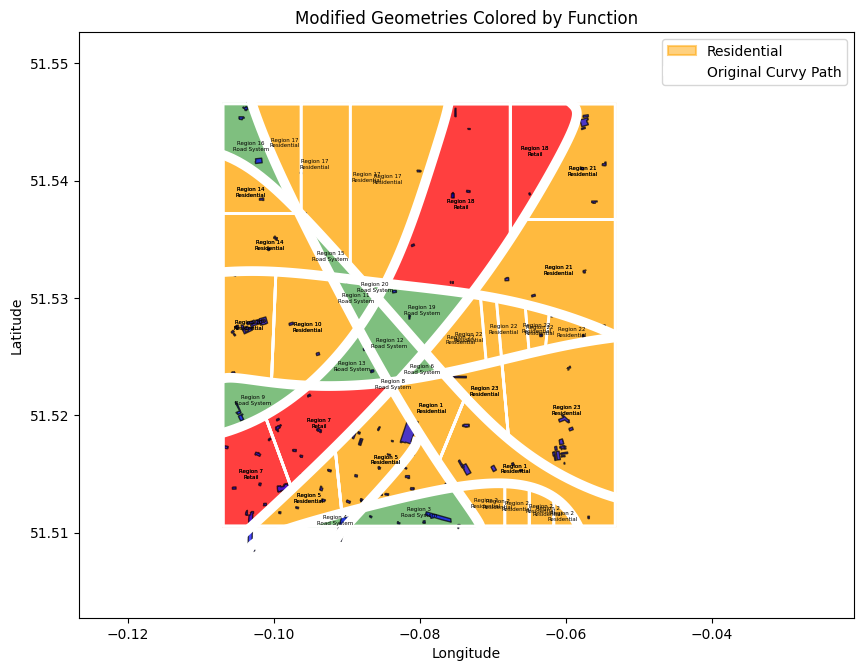

In [101]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Define a color mapping for functions
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'Other': 'green'  # Add more as needed for other functions
}

for i, region in second_geometries_df.iterrows():
    # Plot the original region
   #  ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.7, edgecolor='blue', label='Original Geometry' if i == 0 else ""))


    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
            ha='center', va='center', fontsize=4, color='black', 
            bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the second geometries and plot them
for i, region in second_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=0.5, edgecolor='white', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
        centroid = region.geometry.centroid

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='white', linewidth=7, alpha=1, label='Original Curvy Path')

# Optionally, set axis limits if the geometries are small or spread out
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


                                             geometry     function  \
0   POLYGON ((-0.0768858353201662 51.5232645060904...  Residential   
1   POLYGON ((-0.074528302544786 51.51362212686652...  Residential   
2   POLYGON ((-0.0891554823183994 51.5108500000000...  Road System   
3   POLYGON ((-0.0936306126230645 51.5108500000000...  Road System   
4   POLYGON ((-0.1019044949529248 51.5108500000000...  Residential   
5   POLYGON ((-0.0818344613780795 51.5233191019756...  Road System   
6   POLYGON ((-0.106678 51.518249787931616, -0.095...       Retail   
7   POLYGON ((-0.106678 51.51886121460137, -0.1066...  Road System   
8   POLYGON ((-0.106678 51.52346759133216, -0.1066...  Residential   
9   POLYGON ((-0.0914948983971818 51.5314365678097...  Road System   
10  POLYGON ((-0.0880294654786492 51.5273567595375...  Road System   
11  POLYGON ((-0.0943352610515466 51.5227993353325...  Road System   
12  POLYGON ((-0.106678 51.532510049975116, -0.106...  Residential   
13  POLYGON ((-0.095

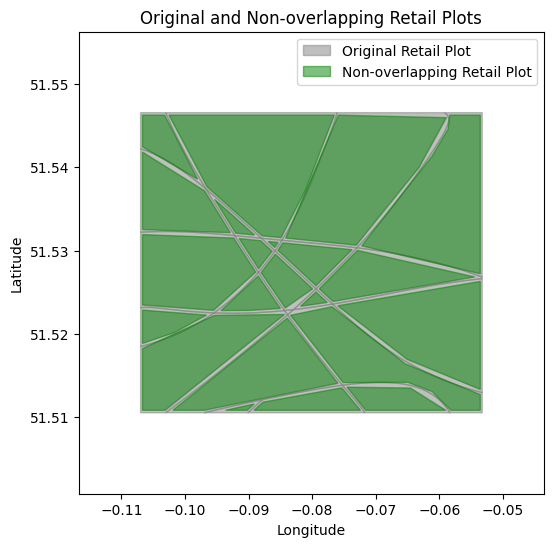

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Simplification tolerance
simplification_tolerance = 0.0005  # Adjust this value to control the degree of simplification

# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `second_geometries_df` is your DataFrame with geometries and function types
# Extract all retail plots
retail_polygons = regions_df

# List to hold valid polygons
valid_polygons = []

# Loop through each retail polygon
for i, region in retail_polygons.iterrows():
    retail_polygon = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(retail_polygon, Polygon):
        exterior_coords = np.array(retail_polygon.exterior.coords)

        # Create a closed curve if necessary (Polygon is already closed, but we can enforce it)
        if not np.array_equal(exterior_coords[0], exterior_coords[-1]):
            exterior_coords = np.vstack([exterior_coords, exterior_coords[0]])  # Close the loop

        # Create a new polygon from these exterior coordinates
        closed_curve = Polygon(exterior_coords)

        # Offset inward by 0.0003 units
        offset_curve_2 = closed_curve.buffer(-0.0003)

        # Simplify the second offset polygon
        simplified_offset_curve_2 = offset_curve_2.simplify(simplification_tolerance)

        # Keep only valid and non-empty offset polygons
        if simplified_offset_curve_2.is_valid and not simplified_offset_curve_2.is_empty:
            valid_polygons.append((simplified_offset_curve_2, region['function'], region['Plot Name']))

# Now remove overlapping polygons, keeping the smaller one
final_polygons = []
for i in range(len(valid_polygons)):
    keep_polygon = True
    for j in range(len(valid_polygons)):
        if i != j and valid_polygons[i][0].intersects(valid_polygons[j][0]):
            # Keep the smaller polygon
            if valid_polygons[i][0].area > valid_polygons[j][0].area:
                keep_polygon = False
                break
    if keep_polygon:
        final_polygons.append(valid_polygons[i])

# Create a DataFrame to store new region info
new_region_data = {
    'geometry': [],
    'function': [],
    'original_plot_name': [],
    'area': [],
    'plot_name': []
}

# Populate the DataFrame with the final polygons and their properties
for poly, function, original_plot_name in final_polygons:
    new_region_data['geometry'].append(poly)
    new_region_data['function'].append(function)
    new_region_data['original_plot_name'].append(original_plot_name)
    new_region_data['area'].append(poly.area)
    new_region_data['plot_name'].append(original_plot_name)  # You can adjust how you generate new plot names if needed

# Convert the dictionary to a DataFrame
offset_regions_df = pd.DataFrame(new_region_data)

# Print the new DataFrame to check the results
print(offset_regions_df)

# Plot the original polygons in light blue
for i, region in retail_polygons.iterrows():
    retail_polygon = region['geometry']
    if isinstance(retail_polygon, Polygon):
        ax.add_patch(plt.Polygon(np.array(retail_polygon.exterior.coords), color='grey', alpha=0.5, edgecolor='blue', label='Original Retail Plot' if i == 0 else ""))

# Plot the remaining non-overlapping polygons
for poly, _, _ in final_polygons:
    ax.add_patch(plt.Polygon(np.array(poly.exterior.coords), color='green', alpha=0.5, edgecolor='black', label='Non-overlapping Retail Plot' if poly not in final_polygons[0] else ""))

# Adjust axis limits to fit the polygons
if final_polygons:
    all_bounds = np.array([poly[0].bounds for poly in final_polygons])  # Changed to final_polygons
    minx, miny = np.min(all_bounds[:, [0, 1]], axis=0)
    maxx, maxy = np.max(all_bounds[:, [2, 3]], axis=0)
    ax.set_xlim(minx - 0.01, maxx + 0.01)
    ax.set_ylim(miny - 0.01, maxy + 0.01)

# Set axis labels and plot details
plt.title("Original and Non-overlapping Retail Plots")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


Simplification failed for Plot 8, using original.
                                             geometry     function  \
0   POLYGON ((-0.0769115276807572 51.5231605375742...  Residential   
1   POLYGON ((-0.0742901517590928 51.5135434783172...  Residential   
2   POLYGON ((-0.0888317439933246 51.51095, -0.087...  Road System   
3   POLYGON ((-0.0924632589829851 51.51095, -0.091...  Road System   
4   POLYGON ((-0.1015288514636615 51.51095, -0.083...  Residential   
5   POLYGON ((-0.0814635531557693 51.5234552043635...  Road System   
6   POLYGON ((-0.106578 51.51816749256369, -0.0953...       Retail   
7   POLYGON ((-0.0843504536366519 51.5228031002326...  Road System   
8   POLYGON ((-0.106578 51.518982728123355, -0.106...  Road System   
9   POLYGON ((-0.106578 51.523574021336415, -0.106...  Residential   
10  POLYGON ((-0.0912668883553808 51.5313192915876...  Road System   
11  POLYGON ((-0.0878900541375704 51.5273488814407...  Road System   
12  POLYGON ((-0.0939737810720042 51.522

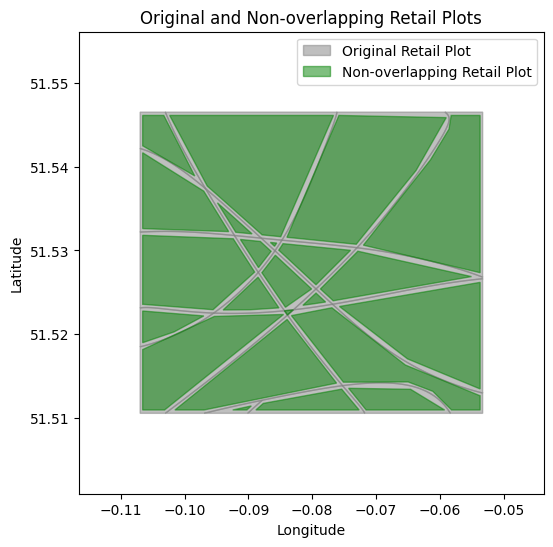

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Simplification tolerance
simplification_tolerance = 0.0005  # Higher tolerance for simplification

# Initialize the plot
fig, ax = plt.subplots(figsize=(6, 6))

# Assuming `regions_df` is your DataFrame with geometries and function types
# Extract all retail plots
retail_polygons = regions_df  # This should be defined in your context

# List to hold valid polygons
valid_polygons = []

# Loop through each retail polygon
for i, region in retail_polygons.iterrows():
    retail_polygon = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(retail_polygon, Polygon):
        exterior_coords = np.array(retail_polygon.exterior.coords)

        # Create a closed curve if necessary
        if not np.array_equal(exterior_coords[0], exterior_coords[-1]):
            exterior_coords = np.vstack([exterior_coords, exterior_coords[0]])  # Close the loop

        # Create a new polygon from these exterior coordinates
        closed_curve = Polygon(exterior_coords)

        # Offset inward by 0.0003 units
        offset_curve_2 = closed_curve.buffer(-0.0004)

        # Simplify the second offset polygon
        simplified_offset_curve_2 = offset_curve_2.simplify(simplification_tolerance)

        # Check for validity and emptiness
        if simplified_offset_curve_2.is_valid and not simplified_offset_curve_2.is_empty:
            valid_polygons.append((simplified_offset_curve_2, region['function'], region['Plot Name']))
        else:
            # If simplification fails, use the original polygon
            print(f"Simplification failed for {region['Plot Name']}, using original.")
            valid_polygons.append((retail_polygon, region['function'], region['Plot Name']))

# Now remove overlapping polygons, keeping the smaller one
final_polygons = []
for i in range(len(valid_polygons)):
    keep_polygon = True
    for j in range(len(valid_polygons)):
        if i != j and valid_polygons[i][0].intersects(valid_polygons[j][0]):
            print(f"Overlapping detected between: {valid_polygons[i][2]} and {valid_polygons[j][2]}")
            # Keep the smaller polygon
            if valid_polygons[i][0].area > valid_polygons[j][0].area:
                print(f"Discarding {valid_polygons[i][2]} in favor of {valid_polygons[j][2]}")
                keep_polygon = False
                break
    if keep_polygon:
        final_polygons.append(valid_polygons[i])

# Create a DataFrame to store new region info
new_region_data = {
    'geometry': [],
    'function': [],
    'original_plot_name': [],
    'area': [],
    'plot_name': []
}

# Populate the DataFrame with the final polygons and their properties
for poly, function, original_plot_name in final_polygons:
    new_region_data['geometry'].append(poly)
    new_region_data['function'].append(function)
    new_region_data['original_plot_name'].append(original_plot_name)
    new_region_data['area'].append(poly.area)
    new_region_data['plot_name'].append(original_plot_name)

# Convert the dictionary to a DataFrame
offset_regions_df = pd.DataFrame(new_region_data)

# Print the new DataFrame to check the results
print(offset_regions_df)

# Plot the original polygons in light blue and simplified polygons in green
for i, region in retail_polygons.iterrows():
    retail_polygon = region['geometry']
    if isinstance(retail_polygon, Polygon):
        ax.add_patch(plt.Polygon(np.array(retail_polygon.exterior.coords), color='grey', alpha=0.5, edgecolor='blue', label='Original Retail Plot' if i == 0 else ""))

# Plot the remaining non-overlapping polygons
for poly, _, _ in final_polygons:
    ax.add_patch(plt.Polygon(np.array(poly.exterior.coords), color='green', alpha=0.5, edgecolor='black', label='Non-overlapping Retail Plot' if poly not in final_polygons[0] else ""))

# Adjust axis limits to fit the polygons
if final_polygons:
    all_bounds = np.array([poly[0].bounds for poly in final_polygons])
    minx, miny = np.min(all_bounds[:, [0, 1]], axis=0)
    maxx, maxy = np.max(all_bounds[:, [2, 3]], axis=0)
    ax.set_xlim(minx - 0.01, maxx + 0.01)
    ax.set_ylim(miny - 0.01, maxy + 0.01)

# Set axis labels and plot details
plt.title("Original and Non-overlapping Retail Plots")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Show the plot
plt.show()


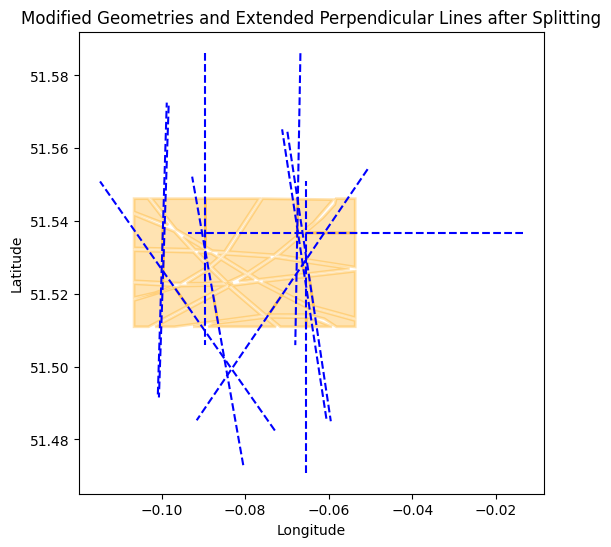

geometry plot_name     function  \
0   POLYGON ((-0.0769115276807572 51.5231605375742...    Plot 1  Residential   
1   POLYGON ((-0.07114811181968 51.519742324226854...    Plot 1  Residential   
2   POLYGON ((-0.0742901517590928 51.5135434783172...    Plot 2  Residential   
3   POLYGON ((-0.0653868020586674 51.5134331140552...    Plot 2  Residential   
4   POLYGON ((-0.0888317439933246 51.51095, -0.087...    Plot 3  Road System   
5   POLYGON ((-0.0924632589829851 51.51095, -0.091...    Plot 4  Road System   
6   POLYGON ((-0.1015288514636615 51.51095, -0.087...    Plot 5  Residential   
7   POLYGON ((-0.0876435144400656 51.5194845447710...    Plot 5  Residential   
8   POLYGON ((-0.0814635531557693 51.5234552043635...    Plot 6  Road System   
9   POLYGON ((-0.106578 51.51816749256369, -0.0968...    Plot 7       Retail   
10  POLYGON ((-0.0968354692161018 51.5215988625726...    Plot 7       Retail   
11  POLYGON ((-0.0843504536366519 51.5228031002326...    Plot 8  Road System   
12  POLYGON ((-0.106578 51.518982728123355, -0.106...    Plot 9  Road System   
13  POLYGON ((-0.106578 51.523574021336415, -0.106...   Plot 10  Residential   
14  POLYGON ((-0.0994770959948172 51.5316073287110...   Plot 10  Residential   
15  POLYGON ((-0.0912668883553808 51.5313192915876...   Plot 11  Road System   
16  POLYGON ((-0.0878900541375704 51.5273488814407...   Plot 12  Road System   
17  POLYGON ((-0.0939737810720042 51.5228933647984...   Plot 13  Road System   
18  POLYGON ((-0.106578 51.5326139062691, -0.10657...   Plot 14  Residential   
19  POLYGON ((-0.0996720332374754 51.5383696509736...   Plot 14  Residential   
20  POLYGON ((-0.0948589288893645 51.5356961002646...   Plot 15  Road System   
21  POLYGON ((-0.106578 51.542501308760365, -0.106...   Plot 16  Road System   
22  POLYGON ((-0.1023475839979907 51.546128, -0.08...   Plot 17  Residential   
23  POLYGON ((-0.0895035403839115 51.546128, -0.07...   Plot 17  Residential   
24  POLYGON ((-0.0839612206275756 51.5315756613499...   Plot 18       Retail   
25  POLYGON ((-0.0673929782569941 51.5459990191219...   Plot 18       Retail   
26  POLYGON ((-0.0852386094024488 51.5300367237248...   Plot 19  Road System   
27  POLYGON ((-0.086559651483497 51.53096412434623...   Plot 20  Road System   
28  POLYGON ((-0.0719700097818576 51.5306342992489...   Plot 21  Residential   
29  POLYGON ((-0.0656744007297601 51.5367371719952...   Plot 21  Residential   
30  POLYGON ((-0.0787122495195787 51.5254091949708...   Plot 22  Residential   
31  POLYGON ((-0.066309817641866 51.52880473836727...   Plot 22  Residential   
32  POLYGON ((-0.075727907229174 51.52331200447471...   Plot 23  Residential   
33  POLYGON ((-0.0646969536145875 51.5247531058747...   Plot 23  Residential   

            area original_plot_name  
0   5.352362e-05             Plot 1  
1   5.635914e-05             Plot 1  
2   1.903436e-05             Plot 2  
3   8.628898e-06             Plot 2  
4   2.402059e-05             Plot 3  
5   5.456235e-07             Plot 4  
6   5.632715e-05             Plot 5  
7   5.987278e-05             Plot 5  
8   2.222803e-06             Plot 6  
9   8.514676e-05             Plot 7  
10  3.435517e-05             Plot 7  
11  3.860544e-07             Plot 8  
12  1.986903e-05             Plot 9  
13  5.821478e-05            Plot 10  
14  6.861998e-05            Plot 10  
15  7.754233e-06            Plot 11  
16  2.272984e-05            Plot 12  
17  1.692297e-05            Plot 13  
18  5.132748e-05            Plot 14  
19  2.400356e-05            Plot 14  
20  4.283355e-06            Plot 15  
21  2.680657e-05            Plot 16  
22  9.984208e-05            Plot 17  
23  1.245313e-04            Plot 17  
24  1.745125e-04            Plot 18  
25  4.591274e-05            Plot 18  
26  2.765496e-05            Plot 19  
27  2.080706e-07            Plot 20  
28  1.225878e-04            Plot 21  
29  7.142487e-05            Plot 21  
30  4.874837e-05            Plot 22  
31  1.857945e-05            

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point

# Function to simplify geometry and print the number of vertices
def simplify_geometry(geometry, tolerance=0.0001):
    simplified_geom = geometry.simplify(tolerance, preserve_topology=True)
    return simplified_geom

# Initialize a new list to store further modified geometries after the new splitting logic
modified_geometries_data = []
perpendicular_lines = []  # Store perpendicular lines for plotting

# Function to process and split geometries based on longest edge conditions
def process_geometry_based_on_function(geometry, function, plot_name, original_plot_number):
    # Simplify the geometry first
    geometry = simplify_geometry(geometry)

    # Calculate the longest edge, midpoint, and edge length for the geometry
    longest_edge, mid_point, edge_length = find_longest_edge(geometry)

    # Determine the splitting criteria based on the function
    if function == 'Retail' and edge_length > 0.0001:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name)
    elif function == 'Residential' and edge_length > 0.0001:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name)
    else:
        # If no splitting is required, store the geometry as is
        return [{
            'geometry': geometry,
            'plot_name': plot_name,
            'function': function,
            'area': geometry.area,
            'original_plot_name': original_plot_name
        }]

# Function to perform the actual geometry splitting and store the results
def split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name):
    split_results = []

    # Perform the splitting only if the midpoint exists
    if mid_point:
        perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
        perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, geometry)

        # Set lengths for extending the perpendicular lines
        extension_length = 0.0001  # Length to extend the line outside the boundary
        perp_length = 0.04  # Length of the perpendicular line itself (adjust if necessary)

        # Calculate end points of the perpendicular line
        end_point_interior = np.array(mid_point) + perp_length * perp_vector
        end_point_exterior = np.array(mid_point) - perp_length * perp_vector

        # Create the initial combined line
        combined_line = LineString([end_point_exterior, end_point_interior])

        # Check if the combined line intersects with the geometry
        if geometry.intersects(combined_line):
            # Adjust the line to fit within the geometry's boundaries
            intersection = geometry.intersection(combined_line)

            if intersection.is_empty:
                # If there is no intersection, adjust the end points to be on the boundary of the geometry
                end_point_exterior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_exterior)))
                end_point_interior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_interior)))
                combined_line = LineString([end_point_exterior, end_point_interior])
            else:
                # If there is an intersection, we can use that as our new line
                combined_line = intersection

            # Extend the perpendicular line at both ends by 0.0001
            perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize the vector

            extended_line = LineString([
                Point(end_point_exterior[0] - extension_length * perp_vector[0], 
                      end_point_exterior[1] - extension_length * perp_vector[1]),
                Point(end_point_interior[0] + extension_length * perp_vector[0], 
                      end_point_interior[1] + extension_length * perp_vector[1])
            ])

            # Ensure the extended line is within the geometry's boundary
            if geometry.intersects(extended_line):
                # Store the extended line for plotting
                perpendicular_lines.append(extended_line)  # Add line for plotting

                # Split the geometry
                new_geometries = split(geometry, extended_line)

                if new_geometries.geom_type == 'GeometryCollection':
                    for geom in new_geometries.geoms:
                        if isinstance(geom, Polygon):
                            split_results.append({
                                'geometry': geom,
                                'plot_name': plot_name,
                                'function': function,
                                'area': geom.area,
                                'original_plot_name': original_plot_name
                            })

    return split_results

# Iterate over the new_geometries_df and apply the splitting logic
for i, row in offset_regions_df.iterrows():
    geometry = row['geometry']
    function = row['function']
    plot_name = row['plot_name']
    original_plot_name = row['original_plot_name']

    # Apply the splitting logic for retail and residential plots
    new_geometries = process_geometry_based_on_function(geometry, function, plot_name, original_plot_name)

    # Append the results to the modified_geometries_data
    modified_geometries_data.extend(new_geometries)

# Convert the modified geometries into a new DataFrame
modified_geometries_df = pd.DataFrame(modified_geometries_data)

# Initialize a new plot
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the modified geometries and plot them
for i, region in modified_geometries_df.iterrows():
    geometry = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        ax.add_patch(plt.Polygon(exterior_coords, color='orange', alpha=0.3, edgecolor='black', linewidth=2))

# Plot the perpendicular lines on top of the geometries
for line in perpendicular_lines:
    line_coords = np.array(line.coords)
    ax.plot(line_coords[:, 0], line_coords[:, 1], color='blue', linewidth=1.5, linestyle='--', label='Perpendicular Line')

# Optionally, set axis limits if the geometries are small or spread out
ax.autoscale()
plt.title("Modified Geometries and Extended Perpendicular Lines after Splitting")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Initialize a list to store second geometries' information
second_geometries_data = []

# Iterate through the modified geometries and gather the required data
for region in modified_geometries_data:
    second_geometries_data.append({
        'geometry': region['geometry'],
        'plot_name': region['plot_name'],
        'function': region['function'],
        'area': region['area'],
        'original_plot_name': region['original_plot_name']
    })

# Create a DataFrame for the second geometries
second_offset_geometries_df = pd.DataFrame(second_geometries_data)

# Display the second_geometries DataFrame
second_offset_geometries_df


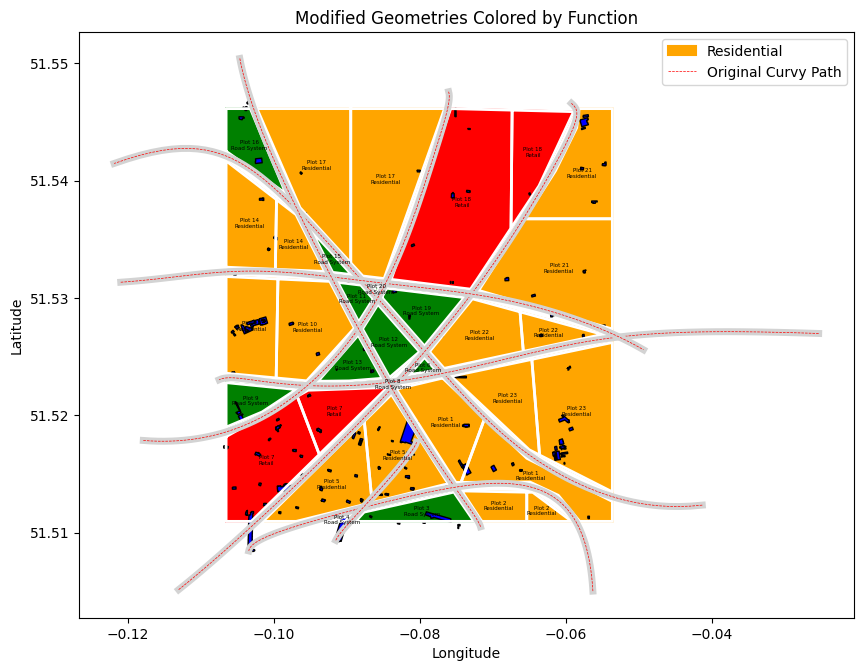

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Define a color mapping for functions
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'Other': 'green'  # Add more as needed for other functions
}

# Create a background polygon (bounding box or specific area)
# Assuming bounding_box is already defined as a Polygon
# Fill the bounding box with a light color
bounding_box_color = 'lightblue'  # Choose your desired fill color
# ax.add_patch(plt.Polygon(list(bounding_box.exterior.coords), 
#                           color=bounding_box_color, alpha=1, edgecolor='red', linewidth=0.01))

# Plot the original region (optional if needed)
for i, region in second_offset_geometries_df.iterrows():
    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
            ha='center', va='center', fontsize=4, color='black', 
            bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the second geometries and plot them
for i, region in second_offset_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=1, edgecolor='lightgrey', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
        centroid = region.geometry.centroid

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='lightgrey', linewidth=5, alpha=1, label='Original Curvy Path')
        ax.plot(x, y, color='red', linewidth=0.5, alpha=1, linestyle = '--', label='Original Curvy Path')
    
    

# Plot df_building at the top
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=1, label="Landmark Buildings")

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


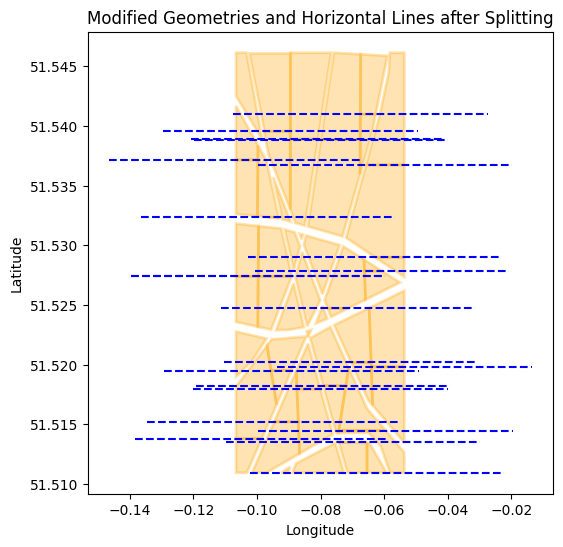

geometry plot_name     function  \
0   POLYGON ((-0.0769115276807572 51.5231605375742...    Plot 1  Residential   
1   POLYGON ((-0.0720355228516256 51.5182460692254...    Plot 1  Residential   
2   POLYGON ((-0.07114811181968 51.519742324226854...    Plot 1  Residential   
3   POLYGON ((-0.0595253479792998 51.5144861932725...    Plot 1  Residential   
4   POLYGON ((-0.0742901517590928 51.5135434783172...    Plot 2  Residential   
5   POLYGON ((-0.0698384769091667 51.5134882961862...    Plot 2  Residential   
6   POLYGON ((-0.0653868020586674 51.5134331140552...    Plot 2  Residential   
7   POLYGON ((-0.0888317439933246 51.51095, -0.087...    Plot 3  Road System   
8   POLYGON ((-0.0924632589829851 51.51095, -0.091...    Plot 4  Road System   
9   POLYGON ((-0.1015288514636615 51.51095, -0.094...    Plot 5  Residential   
10  POLYGON ((-0.0945861829518636 51.5152172723855...    Plot 5  Residential   
11  POLYGON ((-0.0876435144400656 51.5194845447710...    Plot 5  Residential   
12  POLYGON ((-0.0800514775126413 51.5179637983563...    Plot 5  Residential   
13  POLYGON ((-0.0814635531557693 51.5234552043635...    Plot 6  Road System   
14  POLYGON ((-0.106578 51.51816749256369, -0.0968...    Plot 7       Retail   
15  POLYGON ((-0.098476233714863 51.51380224251818...    Plot 7       Retail   
16  POLYGON ((-0.0968354692161018 51.5215988625726...    Plot 7       Retail   
17  POLYGON ((-0.0891476630608814 51.5195067275545...    Plot 7       Retail   
18  POLYGON ((-0.0843504536366519 51.5228031002326...    Plot 8  Road System   
19  POLYGON ((-0.106578 51.518982728123355, -0.106...    Plot 9  Road System   
20  POLYGON ((-0.106578 51.523574021336415, -0.106...   Plot 10  Residential   
21  POLYGON ((-0.106578 51.52739036135755, -0.1065...   Plot 10  Residential   
22  POLYGON ((-0.0994770959948172 51.5316073287110...   Plot 10  Residential   
23  POLYGON ((-0.0890598348015527 51.5273903613575...   Plot 10  Residential   
24  POLYGON ((-0.0912668883553808 51.5313192915876...   Plot 11  Road System   
25  POLYGON ((-0.0878900541375704 51.5273488814407...   Plot 12  Road System   
26  POLYGON ((-0.0939737810720042 51.5228933647984...   Plot 13  Road System   
27  POLYGON ((-0.106578 51.5326139062691, -0.10657...   Plot 14  Residential   
28  POLYGON ((-0.106578 51.53714438423891, -0.1065...   Plot 14  Residential   
29  POLYGON ((-0.0996720332374754 51.5383696509736...   Plot 14  Residential   
30  POLYGON ((-0.0931550432055955 51.5323442766543...   Plot 14  Residential   
31  POLYGON ((-0.0948589288893645 51.5356961002646...   Plot 15  Road System   
32  POLYGON ((-0.106578 51.542501308760365, -0.106...   Plot 16  Road System   
33  POLYGON ((-0.1023475839979907 51.546128, -0.08...   Plot 17  Residential   
34  POLYGON ((-0.0895035403839115 51.5395567216681...   Plot 17  Residential   
35  POLYGON ((-0.0895035403839115 51.546128, -0.07...   Plot 17  Residential   
36  POLYGON ((-0.0807936113487239 51.5388869457404...   Plot 17  Residential   
37  POLYGON ((-0.0839612206275756 51.5315756613499...   Plot 18       Retail   
38  POLYGON ((-0.0798851855719408 51.5388518306749...   Plot 18       Retail   
39  POLYGON ((-0.0673929782569941 51.5459990191219...   Plot 18       Retail   
40  POLYGON ((-0.0626431123030457 51.5409732591561...   Plot 18       Retail   
41  POLYGON ((-0.0852386094024488 51.5300367237248...   Plot 19  Road System   
42  POLYGON ((-0.086559651483497 51.53096412434623...   Plot 20  Road System   
43  POLYGON ((-0.0719700097818576 51.5306342992489...   Plot 21  Residential   
44  POLYGON ((-0.053666 51.52899032161969, -0.0536...   Plot 21  Residential   
45  POLYGON ((-0.0656744007297601 51.5367371719952...   Plot 21  Residential   
46  POLYGON ((-0.0787122495195787 51.5254091949708...   Plot 22  Residential   
47  POLYGON ((-0.0712830538419237 51.524715221509,...   Plot 22  Residential   
48  POLYGON ((-0.066309817641866 51.52880473836727...   Plot 22  Residential   
49  POLYGON ((-0.0606634877129231 51.52784391

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point

# Initialize a new list to store further modified geometries after the new splitting logic
modified_geometries_data = []
horizontal_lines = []  # Store horizontal lines for plotting

# Function to process and split geometries based on longest edge conditions
def process_geometry_based_on_function(geometry, function, plot_name, original_plot_name):
    # Simplify the geometry first
    geometry = simplify_geometry(geometry)

    # Calculate the longest edge, midpoint, and edge length for the geometry
    longest_edge, mid_point, edge_length = find_longest_edge(geometry)

    # Determine the splitting criteria based on the function
    if function == 'Retail' and edge_length > 0.001:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name)
    elif function == 'Residential' and edge_length > 0.005:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name)
    else:
        # If no splitting is required, store the geometry as is
        return [{
            'geometry': geometry,
            'plot_name': plot_name,
            'function': function,
            'area': geometry.area,
            'original_plot_name': original_plot_name
        }]

# Function to perform the actual geometry splitting and store the results
def split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name):
    split_results = []

    # Perform the splitting only if the midpoint exists
    if mid_point:
        # Set lengths for the horizontal line
        extension_length = 0.0001  # Length to extend the line outside the boundary
        horizontal_length = 0.04  # Length of the horizontal line itself (adjust if necessary)

        # Calculate the end points of the horizontal line
        end_point_left = Point(mid_point[0] - horizontal_length, mid_point[1])
        end_point_right = Point(mid_point[0] + horizontal_length, mid_point[1])

        # Create the horizontal line
        horizontal_line = LineString([end_point_left, end_point_right])

        # Check if the horizontal line intersects with the geometry
        if geometry.intersects(horizontal_line):
            # Adjust the line to fit within the geometry's boundaries
            intersection = geometry.intersection(horizontal_line)

            # if intersection.is_empty:
            #     # If there is no intersection, adjust the end points to be on the boundary of the geometry
            #     end_point_left = geometry.boundary.interpolate(geometry.boundary.project(end_point_left))
            #     end_point_right = geometry.boundary.interpolate(geometry.boundary.project(end_point_right))
            #     horizontal_line = LineString([end_point_left, end_point_right])
            # else:
            #     # If there is an intersection, we can use that as our new line
            #     horizontal_line = intersection

            # Store the horizontal line for plotting
            horizontal_lines.append(horizontal_line)

            # Split the geometry
            new_geometries = split(geometry, horizontal_line)

            if new_geometries.geom_type == 'GeometryCollection':
                for geom in new_geometries.geoms:
                    if isinstance(geom, Polygon):
                        split_results.append({
                            'geometry': geom,
                            'plot_name': plot_name,
                            'function': function,
                            'area': geom.area,
                            'original_plot_name': original_plot_name
                        })

    return split_results

# Iterate over the new_geometries_df and apply the splitting logic
for i, row in second_offset_geometries_df.iterrows():
    geometry = row['geometry']
    function = row['function']
    plot_name = row['plot_name']
    original_plot_name = row['original_plot_name']

    # Apply the splitting logic for retail and residential plots
    new_geometries = process_geometry_based_on_function(geometry, function, plot_name, original_plot_name)

    # Append the results to the modified_geometries_data
    modified_geometries_data.extend(new_geometries)

# Convert the modified geometries into a new DataFrame
modified_geometries_df = pd.DataFrame(modified_geometries_data)

# Initialize a new plot
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the modified geometries and plot them
for i, region in modified_geometries_df.iterrows():
    geometry = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        ax.add_patch(plt.Polygon(exterior_coords, color='orange', alpha=0.3, edgecolor='black', linewidth=2))

# Plot the horizontal lines on top of the geometries
for line in horizontal_lines:
    line_coords = np.array(line.coords)
    ax.plot(line_coords[:, 0], line_coords[:, 1], color='blue', linewidth=1.5, linestyle='--', label='Horizontal Line')

# Optionally, set axis limits if the geometries are small or spread out
ax.autoscale()
plt.title("Modified Geometries and Horizontal Lines after Splitting")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Initialize a list to store second geometries' information
second_geometries_data = []

# Iterate through the modified geometries and gather the required data
for region in modified_geometries_data:
    second_geometries_data.append({
        'geometry': region['geometry'],
        'plot_name': region['plot_name'],
        'function': region['function'],
        'area': region['area'],
        'original_plot_name': region['original_plot_name']
    })

# Create a DataFrame for the second geometries
third_offset_geometries_df = pd.DataFrame(second_geometries_data)

# Display the second_geometries DataFrame
third_offset_geometries_df


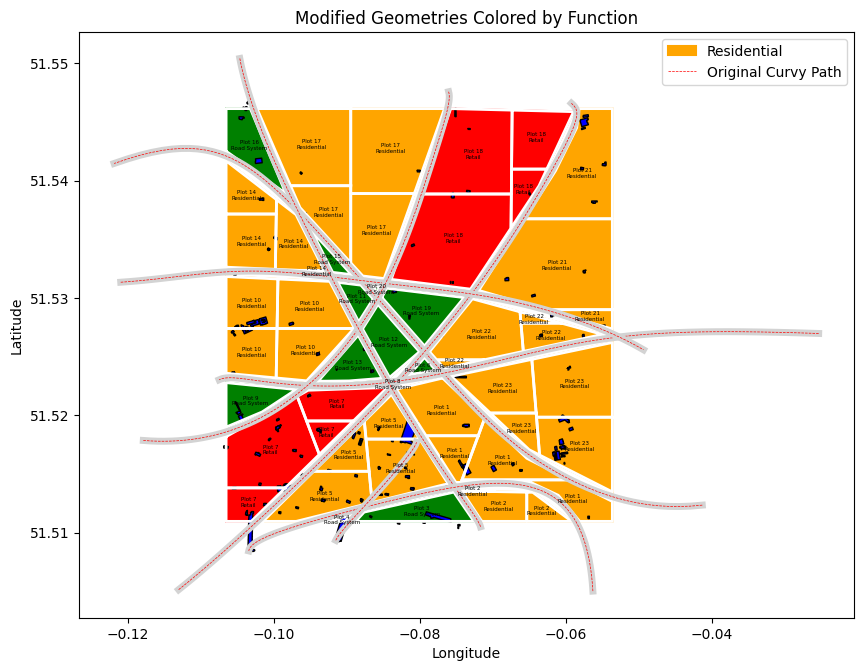

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Define a color mapping for functions
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'Other': 'green'  # Add more as needed for other functions
}

# Create a background polygon (bounding box or specific area)
# Assuming bounding_box is already defined as a Polygon
# Fill the bounding box with a light color
bounding_box_color = 'lightblue'  # Choose your desired fill color
# ax.add_patch(plt.Polygon(list(bounding_box.exterior.coords), 
#                           color=bounding_box_color, alpha=1, edgecolor='red', linewidth=0.01))

# Plot the original region (optional if needed)
for i, region in third_offset_geometries_df.iterrows():
    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
            ha='center', va='center', fontsize=4, color='black', 
            bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the second geometries and plot them
for i, region in third_offset_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=1, edgecolor='lightgrey', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
        centroid = region.geometry.centroid

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='lightgrey', linewidth=5, alpha=1, label='Original Curvy Path')
        ax.plot(x, y, color='red', linewidth=0.5, alpha=1, linestyle = '--', label='Original Curvy Path')
    
    

# Plot df_building at the top
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=1, label="Landmark Buildings")

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [108]:
# import matplotlib.pyplot as plt
# from shapely.geometry import Polygon

# # Initialize a new plot
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Define a color mapping for functions
# color_mapping = {
#     'Retail': 'red',
#     'Residential': 'orange',
#     'Road System': 'green',
#     'Other': 'green'  # Add more as needed for other functions
# }

# for i, region in third_offset_geometries_df.iterrows():
#     # Plot the original region
#    #  ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.7, edgecolor='blue', label='Original Geometry' if i == 0 else ""))


#     # Calculate the centroid for labeling
#     centroid = region.geometry.centroid
#     # Label the function and area at the centroid
#     ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
#             ha='center', va='center', fontsize=4, color='black', 
#             bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# # Loop through the second geometries and plot them
# for i, region in third_offset_geometries_df.iterrows():
#     geometry = region['geometry']
#     function = region['function']

#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         # Extract exterior coordinates and create a polygon for plotting
#         exterior_coords = np.array(geometry.exterior.coords)
#         color = color_mapping.get(function, 'black')  # Default to black if function not found
#         ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=1, edgecolor='white', linewidth=1.5, label=function if i == 0 else ""))
#         ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
#         centroid = region.geometry.centroid

# # Plot the connected paths using Bézier curves
# for path in connected_paths:
#     smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
#     smooth_paths.append(smooth_path)
#     if isinstance(smooth_path, np.ndarray):
#         smooth_path_line = LineString(smooth_path)  # Convert to LineString
#         x, y = smooth_path_line.xy
#         ax.plot(x, y, color='grey', linewidth=7, alpha=1, label='Original Curvy Path')

# # Optionally, set axis limits if the geometries are small or spread out
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# plt.title("Modified Geometries Colored by Function")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Add a legend to the plot
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()


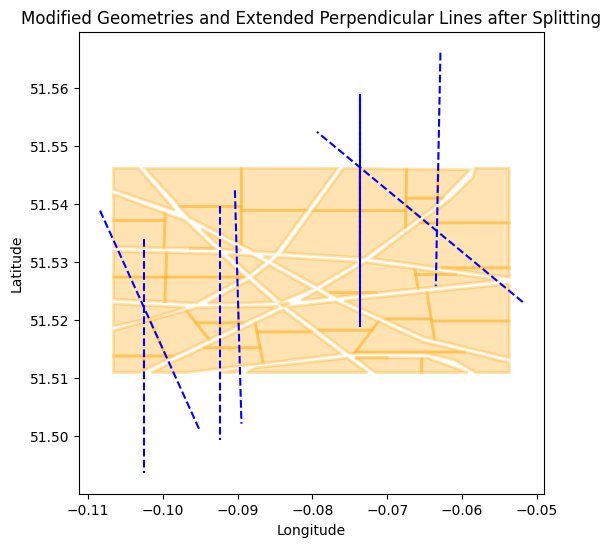

geometry plot_name     function  \
0   POLYGON ((-0.0769115276807572 51.5231605375742...    Plot 1  Residential   
1   POLYGON ((-0.0720355228516256 51.5182460692254...    Plot 1  Residential   
2   POLYGON ((-0.07114811181968 51.519742324226854...    Plot 1  Residential   
3   POLYGON ((-0.0595253479792998 51.5144861932725...    Plot 1  Residential   
4   POLYGON ((-0.0742901517590928 51.5135434783172...    Plot 2  Residential   
..                                                ...       ...          ...   
57  POLYGON ((-0.0606634877129231 51.5278439138580...   Plot 22  Residential   
58  POLYGON ((-0.075727907229174 51.52331200447471...   Plot 23  Residential   
59  POLYGON ((-0.0640998535318077 51.5201825854960...   Plot 23  Residential   
60  POLYGON ((-0.0646969536145875 51.5247531058747...   Plot 23  Residential   
61  POLYGON ((-0.053666 51.51982812649642, -0.0536...   Plot 23  Residential   

            area original_plot_name  
0   3.791439e-05             Plot 1  
1   1.560923e-05             Plot 1  
2   3.402007e-05             Plot 1  
3   2.233907e-05             Plot 1  
4   1.212125e-07             Plot 2  
..           ...                ...  
57  1.592840e-05            Plot 22  
58  3.548362e-05            Plot 23  
59  1.228557e-05            Plot 23  
60  6.069120e-05            Plot 23  
61  4.846620e-05            Plot 23  

[62 rows x 5 columns]

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point

# Initialize a new list to store further modified geometries after the new splitting logic
modified_geometries_data = []
perpendicular_lines = []  # Store perpendicular lines for plotting

# Function to process and split geometries based on longest edge conditions
def process_geometry_based_on_function(geometry, function, plot_name, original_plot_number):
    # Simplify the geometry first
    geometry = simplify_geometry(geometry)

    # Calculate the longest edge, midpoint, and edge length for the geometry
    longest_edge, mid_point, edge_length = find_longest_edge(geometry)

    # Determine the splitting criteria based on the function
    if function == 'Retail' and edge_length > 0.001:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name)
    elif function == 'Residential' and edge_length > 0.05:
        return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name)
    else:
        # If no splitting is required, store the geometry as is
        return [{
            'geometry': geometry,
            'plot_name': plot_name,
            'function': function,
            'area': geometry.area,
            'original_plot_name': original_plot_name
        }]

# Function to perform the actual geometry splitting and store the results
def split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_name):
    split_results = []

    # Perform the splitting only if the midpoint exists
    if mid_point:
        perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
        perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, geometry)

        # Set lengths for extending the perpendicular lines
        extension_length = 0.0001  # Length to extend the line outside the boundary
        perp_length = 0.02  # Length of the perpendicular line itself (adjust if necessary)

        # Calculate end points of the perpendicular line
        end_point_interior = np.array(mid_point) + perp_length * perp_vector
        end_point_exterior = np.array(mid_point) - perp_length * perp_vector

        # Create the initial combined line
        combined_line = LineString([end_point_exterior, end_point_interior])

        # Check if the combined line intersects with the geometry
        if geometry.intersects(combined_line):
            # Adjust the line to fit within the geometry's boundaries
            intersection = geometry.intersection(combined_line)

            if intersection.is_empty:
                # If there is no intersection, adjust the end points to be on the boundary of the geometry
                end_point_exterior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_exterior)))
                end_point_interior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_interior)))
                combined_line = LineString([end_point_exterior, end_point_interior])
            else:
                # If there is an intersection, we can use that as our new line
                combined_line = intersection

            # Extend the perpendicular line at both ends by 0.0001
            perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize the vector

            extended_line = LineString([
                Point(end_point_exterior[0] - extension_length * perp_vector[0], 
                      end_point_exterior[1] - extension_length * perp_vector[1]),
                Point(end_point_interior[0] + extension_length * perp_vector[0], 
                      end_point_interior[1] + extension_length * perp_vector[1])
            ])

            # Ensure the extended line is within the geometry's boundary
            if geometry.intersects(extended_line):
                # Store the extended line for plotting
                perpendicular_lines.append(extended_line)  # Add line for plotting

                # Split the geometry
                new_geometries = split(geometry, extended_line)

                if new_geometries.geom_type == 'GeometryCollection':
                    for geom in new_geometries.geoms:
                        if isinstance(geom, Polygon):
                            split_results.append({
                                'geometry': geom,
                                'plot_name': plot_name,
                                'function': function,
                                'area': geom.area,
                                'original_plot_name': original_plot_name
                            })

    return split_results

# Iterate over the new_geometries_df and apply the splitting logic
for i, row in third_offset_geometries_df.iterrows():
    geometry = row['geometry']
    function = row['function']
    plot_name = row['plot_name']
    original_plot_name = row['original_plot_name']

    # Apply the splitting logic for retail and residential plots
    new_geometries = process_geometry_based_on_function(geometry, function, plot_name, original_plot_name)

    # Append the results to the modified_geometries_data
    modified_geometries_data.extend(new_geometries)

# Convert the modified geometries into a new DataFrame
modified_geometries_df = pd.DataFrame(modified_geometries_data)

# Initialize a new plot
fig, ax = plt.subplots(figsize=(6, 6))

# Loop through the modified geometries and plot them
for i, region in modified_geometries_df.iterrows():
    geometry = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        ax.add_patch(plt.Polygon(exterior_coords, color='orange', alpha=0.3, edgecolor='black', linewidth=2))

# Plot the perpendicular lines on top of the geometries
for line in perpendicular_lines:
    line_coords = np.array(line.coords)
    ax.plot(line_coords[:, 0], line_coords[:, 1], color='blue', linewidth=1.5, linestyle='--', label='Perpendicular Line')

# Optionally, set axis limits if the geometries are small or spread out
ax.autoscale()
plt.title("Modified Geometries and Extended Perpendicular Lines after Splitting")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Initialize a list to store second geometries' information
second_geometries_data = []

# Iterate through the modified geometries and gather the required data
for region in modified_geometries_data:
    second_geometries_data.append({
        'geometry': region['geometry'],
        'plot_name': region['plot_name'],
        'function': region['function'],
        'area': region['area'],
        'original_plot_name': region['original_plot_name']
    })

# Create a DataFrame for the second geometries
fourth_offset_geometries_df = pd.DataFrame(second_geometries_data)

# Display the second_geometries DataFrame
fourth_offset_geometries_df

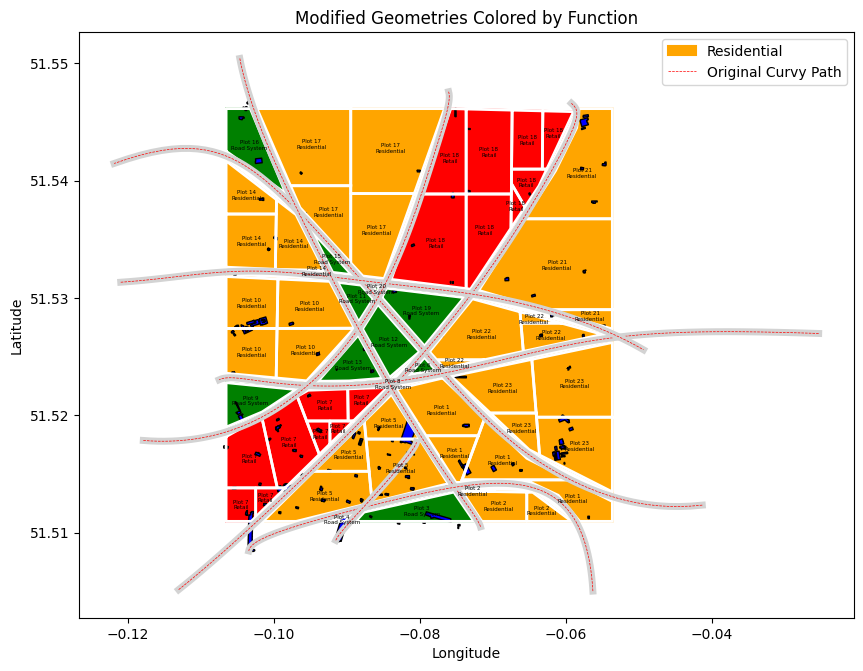

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Define a color mapping for functions
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'Other': 'green'  # Add more as needed for other functions
}

# Create a background polygon (bounding box or specific area)
# Assuming bounding_box is already defined as a Polygon
# Fill the bounding box with a light color
bounding_box_color = 'lightblue'  # Choose your desired fill color
# ax.add_patch(plt.Polygon(list(bounding_box.exterior.coords), 
#                           color=bounding_box_color, alpha=1, edgecolor='red', linewidth=0.01))

# Plot the original region (optional if needed)
for i, region in fourth_offset_geometries_df.iterrows():
    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
            ha='center', va='center', fontsize=4, color='black', 
            bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the second geometries and plot them
for i, region in fourth_offset_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=1, edgecolor='lightgrey', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
        centroid = region.geometry.centroid

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='lightgrey', linewidth=5, alpha=1, label='Original Curvy Path')
        ax.plot(x, y, color='red', linewidth=0.5, alpha=1, linestyle = '--', label='Original Curvy Path')
    
    

# Plot df_building at the top
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=1, label="Landmark Buildings")

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [111]:
from shapely.geometry import Point
from sklearn.cluster import KMeans

# Step 1: Extract centroids of residential plots
residential_centroids = []

# Filter for residential plots and calculate their centroids
for region in fourth_offset_geometries_df.itertuples():
    if region.function == 'Residential':
        centroid = region.geometry.centroid
        residential_centroids.append((centroid.x, centroid.y))

# Convert the centroids list to a NumPy array for clustering
residential_centroids_array = np.array(residential_centroids)

# Step 2: Perform K-Means clustering with n_clusters=2
if residential_centroids_array.size > 0:
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(residential_centroids_array)

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    print(f"Cluster Centroids: {cluster_centers}")

    # Step 3: Find the closest residential plots to each cluster centroid
    closest_plots_indices = []
    
    for center in cluster_centers:
        distances = []
        for idx, region in enumerate(fourth_offset_geometries_df.itertuples()):
            if region.function == 'Residential':
                plot_centroid = region.geometry.centroid
                distance = plot_centroid.distance(Point(center))
                distances.append((distance, idx))

        # Find the plot with the minimum distance to the cluster centroid
        closest_plot_index = min(distances, key=lambda x: x[0])[1]
        closest_plots_indices.append(closest_plot_index)

        # Output the closest plot details
        closest_region = fourth_offset_geometries_df.iloc[closest_plot_index]
        print(f"Closest Plot for School: {closest_region.plot_name}, Function: {closest_region.function}, Area: {closest_region.area}")

        # Step 4: Change the function of the closest plots to "Community Center"
        fourth_offset_geometries_df.at[closest_plot_index, 'function'] = 'School'  # Update the function

        # Optionally print the updated plot details
        print(f"Updated Plot: {fourth_offset_geometries_df.loc[closest_plot_index]}")

# Step 5: Display the updated DataFrame
print("\nUpdated Modified Geometries DataFrame:")
fourth_offset_geometries_df


Cluster Centroids: [[-0.09466778 51.53055317]
 [-0.06678924 51.52152692]]
Closest Plot for School: Plot 10, Function: Residential, Area: 3.609894685346165e-05
Updated Plot: geometry              POLYGON ((-0.0994770959948172 51.5316073287110...
plot_name                                                       Plot 10
function                                                         School
area                                                           0.000036
original_plot_name                                              Plot 10
Name: 26, dtype: object
Closest Plot for School: Plot 23, Function: Residential, Area: 3.548361959870688e-05
Updated Plot: geometry              POLYGON ((-0.075727907229174 51.52331200447471...
plot_name                                                       Plot 23
function                                                         School
area                                                           0.000035
original_plot_name                                      

geometry plot_name     function  \
0   POLYGON ((-0.0769115276807572 51.5231605375742...    Plot 1  Residential   
1   POLYGON ((-0.0720355228516256 51.5182460692254...    Plot 1  Residential   
2   POLYGON ((-0.07114811181968 51.519742324226854...    Plot 1  Residential   
3   POLYGON ((-0.0595253479792998 51.5144861932725...    Plot 1  Residential   
4   POLYGON ((-0.0742901517590928 51.5135434783172...    Plot 2  Residential   
..                                                ...       ...          ...   
57  POLYGON ((-0.0606634877129231 51.5278439138580...   Plot 22  Residential   
58  POLYGON ((-0.075727907229174 51.52331200447471...   Plot 23       School   
59  POLYGON ((-0.0640998535318077 51.5201825854960...   Plot 23  Residential   
60  POLYGON ((-0.0646969536145875 51.5247531058747...   Plot 23  Residential   
61  POLYGON ((-0.053666 51.51982812649642, -0.0536...   Plot 23  Residential   

            area original_plot_name  
0   3.791439e-05             Plot 1  
1   1.560923e-05             Plot 1  
2   3.402007e-05             Plot 1  
3   2.233907e-05             Plot 1  
4   1.212125e-07             Plot 2  
..           ...                ...  
57  1.592840e-05            Plot 22  
58  3.548362e-05            Plot 23  
59  1.228557e-05            Plot 23  
60  6.069120e-05            Plot 23  
61  4.846620e-05            Plot 23  

[62 rows x 5 columns]

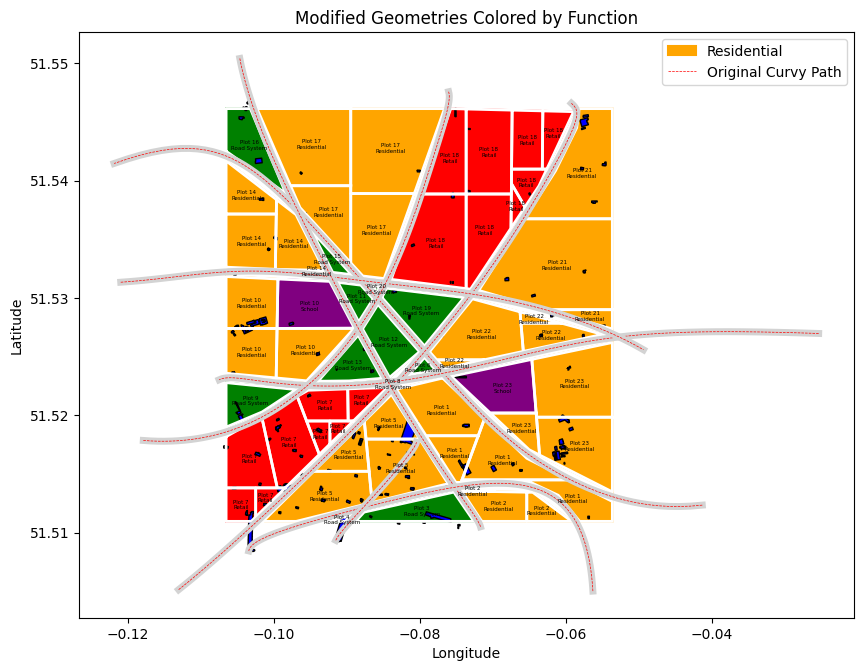

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Define a color mapping for functions
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'School': 'purple',
    'Other': 'green'  # Add more as needed for other functions
}

# Create a background polygon (bounding box or specific area)
# Assuming bounding_box is already defined as a Polygon
# Fill the bounding box with a light color
bounding_box_color = 'lightblue'  # Choose your desired fill color
# ax.add_patch(plt.Polygon(list(bounding_box.exterior.coords), 
#                           color=bounding_box_color, alpha=1, edgecolor='red', linewidth=0.01))

# Plot the original region (optional if needed)
for i, region in fourth_offset_geometries_df.iterrows():
    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
            ha='center', va='center', fontsize=4, color='black', 
            bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the second geometries and plot them
for i, region in fourth_offset_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=1, edgecolor='lightgrey', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
        centroid = region.geometry.centroid

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='lightgrey', linewidth=5, alpha=1, label='Original Curvy Path')
        ax.plot(x, y, color='red', linewidth=0.5, alpha=1, linestyle = '--', label='Original Curvy Path')
    
    

# Plot df_building at the top
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=1, label="Landmark Buildings")

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [113]:
from shapely.geometry import Point
from sklearn.cluster import KMeans

# Step 1: Extract centroids of residential plots
residential_centroids = []

# Filter for residential plots and calculate their centroids
for region in fourth_offset_geometries_df.itertuples():
    if region.function == 'Residential':
        centroid = region.geometry.centroid
        residential_centroids.append((centroid.x, centroid.y))

# Convert the centroids list to a NumPy array for clustering
residential_centroids_array = np.array(residential_centroids)

# Step 2: Perform K-Means clustering with n_clusters=2
if residential_centroids_array.size > 0:
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(residential_centroids_array)

    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    print(f"Cluster Centroids: {cluster_centers}")

    # Step 3: Find the closest residential plots to each cluster centroid
    closest_plots_indices = []
    
    for center in cluster_centers:
        distances = []
        for idx, region in enumerate(fourth_offset_geometries_df.itertuples()):
            if region.function == 'Residential':
                plot_centroid = region.geometry.centroid
                distance = plot_centroid.distance(Point(center))
                distances.append((distance, idx))

        # Find the plot with the minimum distance to the cluster centroid
        closest_plot_index = min(distances, key=lambda x: x[0])[1]
        closest_plots_indices.append(closest_plot_index)

        # Output the closest plot details
        closest_region = fourth_offset_geometries_df.iloc[closest_plot_index]
        print(f"Closest Plot for Community Center: {closest_region.plot_name}, Function: {closest_region.function}, Area: {closest_region.area}")

        # Step 4: Change the function of the closest plots to "Community Center"
        fourth_offset_geometries_df.at[closest_plot_index, 'function'] = 'Community Center'  # Update the function

        # Optionally print the updated plot details
        print(f"Updated Plot: {fourth_offset_geometries_df.loc[closest_plot_index]}")

# Step 5: Display the updated DataFrame
print("\nUpdated Modified Geometries DataFrame:")
fourth_offset_geometries_df


Cluster Centroids: [[-0.0938387  51.52963087]
 [-0.06574233 51.52183543]]
Closest Plot for Community Center: Plot 14, Function: Residential, Area: 1.4834914826245258e-07
Updated Plot: geometry              POLYGON ((-0.0931550432055955 51.5323442766543...
plot_name                                                       Plot 14
function                                               Community Center
area                                                                0.0
original_plot_name                                              Plot 14
Name: 34, dtype: object
Closest Plot for Community Center: Plot 23, Function: Residential, Area: 1.2285566082493433e-05
Updated Plot: geometry              POLYGON ((-0.0640998535318077 51.5201825854960...
plot_name                                                       Plot 23
function                                               Community Center
area                                                           0.000012
original_plot_name                

geometry plot_name  \
0   POLYGON ((-0.0769115276807572 51.5231605375742...    Plot 1   
1   POLYGON ((-0.0720355228516256 51.5182460692254...    Plot 1   
2   POLYGON ((-0.07114811181968 51.519742324226854...    Plot 1   
3   POLYGON ((-0.0595253479792998 51.5144861932725...    Plot 1   
4   POLYGON ((-0.0742901517590928 51.5135434783172...    Plot 2   
..                                                ...       ...   
57  POLYGON ((-0.0606634877129231 51.5278439138580...   Plot 22   
58  POLYGON ((-0.075727907229174 51.52331200447471...   Plot 23   
59  POLYGON ((-0.0640998535318077 51.5201825854960...   Plot 23   
60  POLYGON ((-0.0646969536145875 51.5247531058747...   Plot 23   
61  POLYGON ((-0.053666 51.51982812649642, -0.0536...   Plot 23   

            function          area original_plot_name  
0        Residential  3.791439e-05             Plot 1  
1        Residential  1.560923e-05             Plot 1  
2        Residential  3.402007e-05             Plot 1  
3        Residential  2.233907e-05             Plot 1  
4        Residential  1.212125e-07             Plot 2  
..               ...           ...                ...  
57       Residential  1.592840e-05            Plot 22  
58            School  3.548362e-05            Plot 23  
59  Community Center  1.228557e-05            Plot 23  
60       Residential  6.069120e-05            Plot 23  
61       Residential  4.846620e-05            Plot 23  

[62 rows x 5 columns]

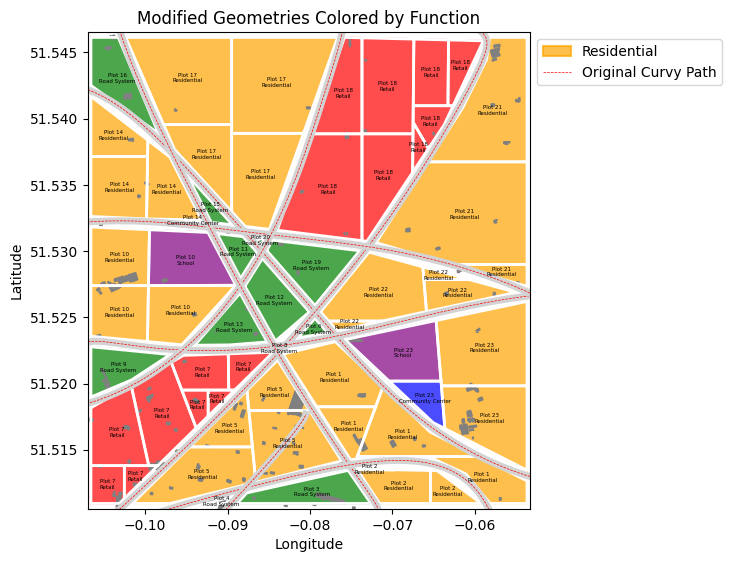

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString

# Define the bounding box (min_x, min_y, max_x, max_y)


# Initialize a new plot
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figure size as needed

# Define a color mapping for functions, including School and Community Center
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'School': 'purple',
    'Community Center': 'blue',  # New color for Community Center
    'Other': 'green'  # Add more as needed for other functions
}

# Set axis limits based on the bounding box
min_x, min_y, max_x, max_y = bounding_box.bounds
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Plot the original region (optional if needed)
for i, region in fourth_offset_geometries_df.iterrows():
    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    if bounding_box.contains(centroid):  # Check if the centroid is within the bounding box
        # Label the function and area at the centroid
        ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
                ha='center', va='center', fontsize=4, color='black', 
                bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the modified geometries and plot them
for i, region in fourth_offset_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon and check if it's within the bounding box
    if isinstance(geometry, Polygon) and bounding_box.intersects(geometry):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=0.7, edgecolor='lightgrey', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer

# Plot df_building at the top (if within the bounding box)
if not df_building.empty:
    df_building_within = df_building[df_building.geometry.intersects(bounding_box)]
    df_building_within.plot(ax=ax, color='grey', edgecolor='grey', alpha=1, label="Landmark Buildings")

# Plot the connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='lightgrey', linewidth=5, alpha=1, label='Original Curvy Path')
        ax.plot(x, y, color='red', linewidth=0.5, alpha=1, linestyle='--', label='Original Curvy Path')

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend outside the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Ensure everything fits well
plt.show()


In [115]:
import geopandas as gpd

# Assuming 'residential_plots_df' contains the geometry of the residential plots
# Convert the DataFrame to a GeoDataFrame
residential_plots_gdf = gpd.GeoDataFrame(residential_plots_df, geometry='geometry')

# Create a GeoDataFrame for the centroids
centroids_gdf = gpd.GeoDataFrame(centroids_df, geometry=gpd.points_from_xy(centroids_df['longitude'], centroids_df['latitude']))

# Ensure both GeoDataFrames are in the same coordinate reference system (CRS)
residential_plots_gdf.crs = 'EPSG:4326'  # Example CRS; adjust as necessary
centroids_gdf.crs = 'EPSG:4326'           # Ensure it matches the plots GeoDataFrame

# Find which plots contain each centroid
centroids_with_plots = []

for idx, centroid in centroids_gdf.iterrows():
    containing_plots = residential_plots_gdf[residential_plots_gdf.contains(centroid.geometry)]
    centroids_with_plots.append({
        'centroid_index': idx,
        'centroid_coordinates': centroid.geometry,
        'containing_plots': containing_plots['plot_name'].tolist()  # Extract the names of containing plots
    })

# Convert the results into a DataFrame for easier viewing
centroids_with_plots_df = pd.DataFrame(centroids_with_plots)

# Display the results
print("Centroids and their containing plots:")
centroids_with_plots_df


NameError: name 'residential_plots_df' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString
from shapely.ops import split

# Initialize a new plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Define a color mapping for functions
color_mapping = {
    'Retail': 'red',
    'Residential': 'orange',
    'Road System': 'green',
    'Other': 'green'  # Add more as needed for other functions
}

# Step 1: Filter for Residential plots
residential_plots = fourth_offset_geometries_df[fourth_offset_geometries_df['function'] == 'Residential']

# Step 2: Ensure residential_plots is a GeoDataFrame
if not isinstance(residential_plots, gpd.GeoDataFrame):
    residential_plots = gpd.GeoDataFrame(residential_plots, geometry='geometry')

# Step 3: Calculate area and find the three largest plots
residential_plots['area'] = residential_plots.geometry.area  # Ensure this is a GeoSeries
largest_residential_plots = residential_plots.nlargest(3, 'area')

# Step 4: Plot other regions
for i, region in fourth_offset_geometries_df.iterrows():
    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    # Label the function and area at the centroid
    ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
            ha='center', va='center', fontsize=4, color='black', 
            bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# Loop through the second geometries and plot them
for i, region in fourth_offset_geometries_df.iterrows():
    geometry = region['geometry']
    function = region['function']

    # Ensure the geometry is a Polygon
    if isinstance(geometry, Polygon):
        # Extract exterior coordinates and create a polygon for plotting
        exterior_coords = np.array(geometry.exterior.coords)
        color = color_mapping.get(function, 'black')  # Default to black if function not found
        ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=1, edgecolor='lightgrey', linewidth=1.5, label=function if i == 0 else ""))
        ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer

# Step 5: Process largest residential plots
for _, row in largest_residential_plots.iterrows():
    geometry = row.geometry
    
    # Calculate the mid-point of the geometry's exterior
    mid_point_index = len(geometry.exterior.coords) // 2
    mid_point = geometry.exterior.coords[mid_point_index]
    
    # Create a vertical line that splits the geometry
    split_line = LineString([mid_point, (mid_point[0], mid_point[1] + 0.01)])  # Slightly adjust y-coordinate

    # Step 6: Split the geometry
    split_geometries = split(geometry, split_line)

    # Plot the original residential plot in orange
    ax.add_patch(plt.Polygon(np.array(geometry.exterior.coords), color='orange', alpha=0.5, edgecolor='lightgrey', linewidth=1.5))

    # Plot the split geometries
    for geom in split_geometries.geoms:
        if geom.area > 0:  # Ensure the geometry is valid
            # Color one piece green and label it as Community
            if geom.area < geometry.area / 2:
                ax.add_patch(plt.Polygon(np.array(geom.exterior.coords), color='green', alpha=0.5, edgecolor='black', linewidth=1.5))
                # Label the green area
                centroid = geom.centroid
                ax.text(centroid.x, centroid.y, 'Community', ha='center', va='center', fontsize=8, color='white')
            else:
                ax.add_patch(plt.Polygon(np.array(geom.exterior.coords), color='lightgray', alpha=0.5, edgecolor='black', linewidth=1.5))

# Plot connected paths using Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='lightgrey', linewidth=5, alpha=1, label='Original Curvy Path')
        ax.plot(x, y, color='red', linewidth=0.5, alpha=1, linestyle='--', label='Original Curvy Path')

# Plot df_building at the top
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=1, label="Landmark Buildings")

plt.title("Modified Geometries Colored by Function")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Assuming `second_geometries_df` is your DataFrame with geometries and function types
# Extract all retail plots
retail_polygons = second_geometries_df[second_geometries_df['function'] == 'Retail']

# Loop through each retail polygon
for i, region in retail_polygons.iterrows():
    retail_polygon = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(retail_polygon, Polygon):
        exterior_coords = np.array(retail_polygon.exterior.coords)

        # Create a closed curve if necessary (Polygon is already closed, but we can enforce it)
        if not np.array_equal(exterior_coords[0], exterior_coords[-1]):
            exterior_coords = np.vstack([exterior_coords, exterior_coords[0]])  # Close the loop

        # Create a new polygon from these exterior coordinates
        closed_curve = Polygon(exterior_coords)

        # Offset inward by 0.01 units
        offset_curve = closed_curve.buffer(-0.0005)  # Negative buffer shrinks the polygon

        if offset_curve.is_empty:
            print(f"Offset polygon for region {i} is empty. Offset might be too large.")
        else:
            # Plot the original retail polygon
            ax.add_patch(plt.Polygon(np.array(closed_curve.exterior.coords), color='orange', alpha=0.1, edgecolor='blue', label='Original Retail Plot' if i == 0 else ""))

            # Plot the offset polygon if it's valid and non-empty
            if offset_curve.is_valid and not offset_curve.is_empty:
                ax.add_patch(plt.Polygon(np.array(offset_curve.exterior.coords), color='red', alpha=0.5, edgecolor='green', label='Offset Retail Plot' if i == 0 else ""))

# Adjust axis limits to fit the polygons
all_bounds = np.array([poly.bounds for poly in retail_polygons['geometry']])
minx, miny = np.min(all_bounds[:, [0, 1]], axis=0)
maxx, maxy = np.max(all_bounds[:, [2, 3]], axis=0)
ax.set_xlim(minx - 0.01, maxx + 0.01)
ax.set_ylim(miny - 0.01, maxy + 0.01)

# Set axis labels and plot details
plt.title("Retail Plots with Offset Inward by 0.01")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Simplification tolerance
simplification_tolerance = 0.001  # Adjust this value to control the degree of simplification

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Assuming `second_geometries_df` is your DataFrame with geometries and function types
# Extract all retail plots
retail_polygons = second_geometries_df[second_geometries_df['function'] == 'Retail']

# Loop through each retail polygon
for i, region in retail_polygons.iterrows():
    retail_polygon = region['geometry']

    # Ensure the geometry is a Polygon
    if isinstance(retail_polygon, Polygon):
        exterior_coords = np.array(retail_polygon.exterior.coords)

        # Create a closed curve if necessary (Polygon is already closed, but we can enforce it)
        if not np.array_equal(exterior_coords[0], exterior_coords[-1]):
            exterior_coords = np.vstack([exterior_coords, exterior_coords[0]])  # Close the loop

        # Create a new polygon from these exterior coordinates
        closed_curve = Polygon(exterior_coords)

        # Offset inward by 0.01 units
        offset_curve = closed_curve.buffer(-0.0003)  # Negative buffer shrinks the polygon

        # Simplify the offsetted polygon
        simplified_offset_curve = offset_curve.simplify(simplification_tolerance)

        if simplified_offset_curve.is_empty:
            print(f"Simplified offset polygon for region {i} is empty. Offset or simplification might be too aggressive.")
        else:
            # Plot the original retail polygon
            ax.add_patch(plt.Polygon(np.array(closed_curve.exterior.coords), color='red', alpha=0.7, edgecolor='blue', label='Original Retail Plot' if i == 0 else ""))

            # Plot the simplified offset polygon if it's valid and non-empty
            if simplified_offset_curve.is_valid and not simplified_offset_curve.is_empty:
                ax.add_patch(plt.Polygon(np.array(simplified_offset_curve.exterior.coords), color='orange', alpha=0.5, edgecolor='green', label='Simplified Offset Retail Plot' if i == 0 else ""))

# Adjust axis limits to fit the polygons
all_bounds = np.array([poly.bounds for poly in retail_polygons['geometry']])
minx, miny = np.min(all_bounds[:, [0, 1]], axis=0)
maxx, maxy = np.max(all_bounds[:, [2, 3]], axis=0)
ax.set_xlim(minx - 0.01, maxx + 0.01)
ax.set_ylim(miny - 0.01, maxy + 0.01)

# Set axis labels and plot details
plt.title("Simplified Retail Plots with Offset Inward by 0.01")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a legend to the plot
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [571]:
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import Polygon
# from scipy.spatial import Voronoi, voronoi_plot_2d
# from sklearn.cluster import DBSCAN

# # Simulated example data for landmark nodes
# # Replace this with actual data
# # Assume df_building is a DataFrame containing geometries of buildings
# # Here we simulate some example landmark nodes as centroids of buildings
# landmark_nodes = [(row.geometry.centroid.x, row.geometry.centroid.y) for _, row in df_building.iterrows()]
# landmark_coords = np.array(landmark_nodes)

# # Step 1: Use DBSCAN to cluster close landmark points
# epsilon = 0.001  # Adjust based on your coordinate scale
# min_samples = 2

# # Create and fit the DBSCAN model
# db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(landmark_coords)
# labels = db.labels_

# # Step 2: Calculate centroids of clusters
# unique_labels = set(labels)
# centroids = []

# for label in unique_labels:
#     if label != -1:  # Skip noise points
#         cluster_points = landmark_coords[labels == label]
#         centroid = np.mean(cluster_points, axis=0)  # Calculate centroid
#         centroids.append(centroid)

# centroids = np.array(centroids)

# # Check number of centroids before creating Voronoi
# if len(centroids) >= 4:
#     # Step 3: Create Voronoi diagram using centroids
#     vor = Voronoi(centroids)
# else:
#     print("Not enough distinct clusters to create Voronoi diagram.")
#     vor = None  # Set vor to None to avoid further errors

# # Initialize a new plot
# fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size as needed

# # Define a color mapping for functions (example mapping)
# color_mapping = {
#     'Retail': 'red',
#     'Residential': 'orange',
#     'Road System': 'green',
#     'Other': 'green'  # Add more as needed for other functions
# }


# # Plot regions
# for i, region in enumerate(second_geometries_df['geometry']):
#     geometry = region
#     function = second_geometries_df['function'][i]

#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         exterior_coords = np.array(geometry.exterior.coords)
#         color = color_mapping.get(function, 'black')  # Default to black if function not found
#         ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=0.5, edgecolor='white', linewidth=1.5, label=function if i == 0 else ""))
#         ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer

#         # Calculate and label centroid
#         centroid = geometry.centroid

# # Step 4: Plot the clustered landmark centroids
# for centroid in centroids:
#     ax.plot(centroid[0], centroid[1], 'o', color='blue', markersize=8, label='Centroid' if centroid.tolist() == centroids[0].tolist() else "")  # Plot centroid of clusters

# # Plot the Voronoi diagram if it's created
# if vor is not None:
#     voronoi_plot = voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1, line_alpha=0.5)

# # Replace this with the actual DataFrame plot if available
# # df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# plt.title("Voronoi Diagram with Clustered Landmark Nodes")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Add a legend to the plot
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()


In [572]:
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import Polygon
# from scipy.spatial import Voronoi, voronoi_plot_2d
# from sklearn.cluster import DBSCAN

# # Simulated example data for landmark nodes
# # Replace this with actual data
# # Assume df_building is a DataFrame containing geometries of buildings
# # Here we simulate some example landmark nodes as centroids of buildings
# landmark_nodes = [(row.geometry.centroid.x, row.geometry.centroid.y) for _, row in df_building.iterrows()]
# landmark_coords = np.array(landmark_nodes)

# # Step 1: Use DBSCAN to cluster close landmark points
# epsilon = 0.001  # Adjust based on your coordinate scale
# min_samples = 2

# # Create and fit the DBSCAN model
# db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(landmark_coords)
# labels = db.labels_

# # Step 2: Calculate centroids of clusters
# unique_labels = set(labels)
# centroids = []

# for label in unique_labels:
#     if label != -1:  # Skip noise points
#         cluster_points = landmark_coords[labels == label]
#         centroid = np.mean(cluster_points, axis=0)  # Calculate centroid
#         centroids.append(centroid)

# centroids = np.array(centroids)

# # Filter the geometries for 'Retail' function
# retail_geometries = second_geometries_df[second_geometries_df['function'] == 'Retail']

# # Check number of centroids before creating Voronoi
# if len(centroids) >= 4:
#     # Step 3: Create Voronoi diagram using centroids
#     vor = Voronoi(centroids)
# else:
#     print("Not enough distinct clusters to create Voronoi diagram.")
#     vor = None  # Set vor to None to avoid further errors

# # Initialize a new plot
# fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size as needed

# # Define a color mapping for functions (example mapping)
# color_mapping = {
#     'Retail': 'red',
#     'Residential': 'orange',
#     'Road System': 'green',
#     'Other': 'green'  # Add more as needed for other functions
# }

# # Plot regions only for Retail function
# for i, region in retail_geometries.iterrows():
#     geometry = region['geometry']
#     function = region['function']

#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         exterior_coords = np.array(geometry.exterior.coords)
#         color = color_mapping.get(function, 'black')  # Default to black if function not found
#         ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=0.5, edgecolor='white', linewidth=1.5, label=function if i == 0 else ""))
#         ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer

#         # Calculate and label centroid (optional)
#         centroid = geometry.centroid
#         ax.plot(centroid.x, centroid.y, 'x', color='black')  # Plot the centroid of the Retail region

# # Step 4: Plot the clustered landmark centroids
# for centroid in centroids:
#     ax.plot(centroid[0], centroid[1], 'o', color='blue', markersize=8, label='Centroid' if centroid.tolist() == centroids[0].tolist() else "")  # Plot centroid of clusters

# # Plot the Voronoi diagram if it's created
# if vor is not None:
#     voronoi_plot = voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1, line_alpha=0.5)

# # Replace this with the actual DataFrame plot if available
# # df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# plt.title("Voronoi Diagram with Clustered Landmark Nodes (Retail Only)")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Add a legend to the plot
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()


In [573]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from shapely.geometry import Polygon, LineString, Point

# # Function to simplify geometry and print the number of vertices
# def simplify_geometry(geometry, tolerance=0.0001):
#     simplified_geom = geometry.simplify(tolerance, preserve_topology=True)
#     return simplified_geom

# # Initialize a new list to store further modified geometries after the new splitting logic
# modified_geometries_data = []
# perpendicular_lines = []  # Store perpendicular lines for plotting

# # Function to process and split geometries based on longest edge conditions
# def process_geometry_based_on_function(geometry, function, plot_name, original_plot_number):
#     # Simplify the geometry first
#     geometry = simplify_geometry(geometry)

#     # Calculate the longest edge, midpoint, and edge length for the geometry
#     longest_edge, mid_point, edge_length = find_shortest_edge(geometry)

#     # Determine the splitting criteria based on the function
#     if function == 'Retail' and edge_length > 0.002:
#         return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number)
#     elif function == 'Residential' and edge_length > 0.004:
#         return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number)
#     else:
#         # If no splitting is required, store the geometry as is
#         return [{
#             'geometry': geometry,
#             'plot_name': plot_name,
#             'function': function,
#             'area': geometry.area,
#             'original_plot_number': original_plot_number
#         }]

# # Function to perform the actual geometry splitting and store the results
# def split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number):
#     split_results = []

#     # Perform the splitting only if the midpoint exists
#     if mid_point:
#         perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
#         perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, geometry)

#         # Set lengths for extending the perpendicular lines
#         extension_length = 0.001  # Length to extend the line outside the boundary
#         perp_length = 0.1  # Length of the perpendicular line itself (adjust if necessary)

#         # Calculate end points of the perpendicular line
#         end_point_interior = np.array(mid_point) + perp_length * perp_vector
#         end_point_exterior = np.array(mid_point) - perp_length * perp_vector

#         # Create the initial combined line
#         combined_line = LineString([end_point_exterior, end_point_interior])

#         # Check if the combined line intersects with the geometry
#         if geometry.intersects(combined_line):
#             # Adjust the line to fit within the geometry's boundaries
#             intersection = geometry.intersection(combined_line)

#             if intersection.is_empty:
#                 # If there is no intersection, adjust the end points to be on the boundary of the geometry
#                 end_point_exterior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_exterior)))
#                 end_point_interior = geometry.boundary.interpolate(geometry.boundary.project(Point(end_point_interior)))
#                 combined_line = LineString([end_point_exterior, end_point_interior])
#             else:
#                 # If there is an intersection, we can use that as our new line
#                 combined_line = intersection

#             # Extend the perpendicular line at both ends by 0.0001
#             perp_vector = perp_vector / np.linalg.norm(perp_vector)  # Normalize the vector

#             extended_line = LineString([
#                 Point(end_point_exterior[0] - extension_length * perp_vector[0], 
#                       end_point_exterior[1] - extension_length * perp_vector[1]),
#                 Point(end_point_interior[0] + extension_length * perp_vector[0], 
#                       end_point_interior[1] + extension_length * perp_vector[1])
#             ])

#             extended_line = combined_line

#             # Ensure the extended line is within the geometry's boundary
#             if geometry.intersects(extended_line):
#                 # Store the extended line for plotting
#                 perpendicular_lines.append(extended_line)  # Add line for plotting

#                 # Split the geometry
#                 new_geometries = split(geometry, extended_line)

#                 if new_geometries.geom_type == 'GeometryCollection':
#                     for geom in new_geometries.geoms:
#                         if isinstance(geom, Polygon):
#                             split_results.append({
#                                 'geometry': geom,
#                                 'plot_name': plot_name,
#                                 'function': function,
#                                 'area': geom.area,
#                                 'original_plot_number': original_plot_number
#                             })

#     return split_results

# # Iterate over the second_modified_geometries_df and apply the splitting logic
# for i, row in second_geometries_df.iterrows():
#     geometry = row['geometry']
#     function = row['function']
#     plot_name = row['plot_name']
#     original_plot_number = row['original_plot_number']

#     # Apply the splitting logic again for retail and residential plots
#     third_new_geometries = process_geometry_based_on_function(geometry, function, plot_name, original_plot_number)
    
#     # Append the results to the third_modified_geometries_data
#     modified_geometries_data.extend(third_new_geometries)

# # Convert the third modified geometries into a new DataFrame
# third_modified_geometries_df = pd.DataFrame(modified_geometries_data)

# # Display the third modified geometries DataFrame
# print(third_modified_geometries_df)

# # Initialize a new plot for the third round of subdivisions
# fig, ax = plt.subplots(figsize=(6, 6))

# # Loop through the third modified geometries and plot them
# for i, region in third_modified_geometries_df.iterrows():
#     geometry = region['geometry']
    
#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         # Extract exterior coordinates and create a polygon for plotting
#         exterior_coords = np.array(geometry.exterior.coords)
#         ax.add_patch(plt.Polygon(exterior_coords, color='purple', alpha=0.3, edgecolor='black', linewidth=2))

# # Plot the perpendicular lines from the third split
# for line in perpendicular_lines:
#     line_coords = np.array(line.coords)
#     ax.plot(line_coords[:, 0], line_coords[:, 1], color='blue', linewidth=1.5, linestyle='--', label='Perpendicular Line')

# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")
# # Set axis limits and labels
# ax.autoscale()
# plt.title("Further Modified Geometries after Third Subdivision")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# # Collect the third modified geometries data for further analysis
# third_modified_geometries_data_final = []

# # Iterate through the third modified geometries and gather required data
# for region in modified_geometries_data:
#     third_modified_geometries_data_final.append({
#         'geometry': region['geometry'],
#         'plot_name': region['plot_name'],
#         'function': region['function'],
#         'area': region['area'],
#         'original_plot_number': region['original_plot_number']
#     })

# # Create a DataFrame for the third round of modified geometries
# third_geometries_df = pd.DataFrame(third_modified_geometries_data_final)

# # Display the final DataFrame after the third round of subdivision
# third_geometries_df


In [574]:

# # Initialize a new plot
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Define a color mapping for functions
# color_mapping = {
#     'Retail': 'red',
#     'Residential': 'orange',
#     'Road System': 'green',
#     'Other': 'green'  # Add more as needed for other functions
# }


# # Loop through the second geometries and plot them
# for i, region in third_geometries_df.iterrows():
#     # Calculate the centroid for labeling
#     centroid = region.geometry.centroid
#     # Label the function and area at the centroid
#     ax.text(centroid.x, centroid.y, f'{region["function"]}', 
#             ha='center', va='center', fontsize=4, color='black', 
#             bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

#     geometry = region['geometry']
#     function = region['function']

#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         # Extract exterior coordinates and create a polygon for plotting
#         exterior_coords = np.array(geometry.exterior.coords)
#         color = color_mapping.get(function, 'black')  # Default to black if function not found
#         ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=0.5, edgecolor='white', linewidth=1.5, label=function if i == 0 else ""))
#         ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer
#         centroid = region.geometry.centroid

# # Plot the connected paths using Bézier curves
# for path in connected_paths:
#     smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
#     smooth_paths.append(smooth_path)
#     if isinstance(smooth_path, np.ndarray):
#         smooth_path_line = LineString(smooth_path)  # Convert to LineString
#         x, y = smooth_path_line.xy
#         ax.plot(x, y, color='white', linewidth=7, alpha=1, label='Original Curvy Path')

# # Optionally, set axis limits if the geometries are small or spread out
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# plt.title("Modified Geometries Colored by Function")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Add a legend to the plot
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()


In [575]:
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import Polygon, Point, LineString
# from shapely.ops import nearest_points

# # Initialize a new plot
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Define a color mapping for functions
# color_mapping = {
#     'Retail': 'red',
#     'Residential': 'orange',
#     'Road System': 'green',
#     'Other': 'green'  # Add more as needed for other functions
# }

# # Plot regions
# for i, region in third_geometries_df.iterrows():
#     geometry = region['geometry']
#     function = region['function']

#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         exterior_coords = np.array(geometry.exterior.coords)
#         color = color_mapping.get(function, 'black')  # Default to black if function not found
#         ax.add_patch(plt.Polygon(exterior_coords, color=color, alpha=0.5, edgecolor='white', linewidth=1.5, label=function if i == 0 else ""))
#         ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color='white', linewidth=2)  # Edge layer

#         # Calculate and label centroid
#         centroid = geometry.centroid
#         ax.text(centroid.x, centroid.y, f'{region["plot_name"]}\n{region.function}', 
#                 ha='center', va='center', fontsize=4, color='black', 
#                 bbox=dict(facecolor='white', alpha=0, edgecolor='none', boxstyle='round,pad=0.2'))

# # Loop through each landmark node
# for _, row in df_building.iterrows():
#     landmark_point = row.geometry.centroid  # Assuming landmark_point is a Point
#     # ax.plot(landmark_point.x, landmark_point.y, 'o', color='blue', markersize=5)  # Plot landmark

#     # Find the region that contains the landmark point
#     found_region = None
#     for i, region in third_geometries_df.iterrows():
#         if region.geometry.contains(landmark_point):  # Check if the landmark point is inside the region
#             found_region = region
#             break

#     # If a region is found, calculate the nearest edge
#     if found_region is not None:
#         # Get the nearest edge of the region
#         nearest_edge = nearest_points(landmark_point, found_region.geometry.exterior)[1]

#         # Create a line between the landmark point and the nearest edge point
#         connection_path = LineString([landmark_point, nearest_edge])
#         x, y = connection_path.xy
#         ax.plot(x, y, color='white', linewidth=2, alpha=1)  # Plot the connection path

# # Optionally, set axis limits if the geometries are small or spread out
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# plt.title("Landmark Nodes Connected to Regions")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Add a legend to the plot
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# plt.show()


In [576]:
# # Function to simplify geometry and print the number of vertices
# def simplify_geometry(geometry, tolerance=0.0001):
#     simplified_geom = geometry.simplify(tolerance, preserve_topology=True)
#     # print(f"Simplified geometry has {len(simplified_geom.exterior.coords)} vertices.")
#     return simplified_geom

# # Initialize a new list to store further modified geometries after the new splitting logic
# modified_geometries_data = []
# perpendicular_lines = []  # Store perpendicular lines for plotting

# # Function to process and split geometries based on longest edge conditions
# def process_geometry_based_on_function(geometry, function, plot_name, original_plot_number):
#     # Simplify the geometry first
#     geometry = simplify_geometry(geometry)

#     # Calculate the longest edge, midpoint, and edge length for the geometry
#     longest_edge, mid_point, edge_length = find_longest_edge(geometry)
    
#     # Print the longest edge length for the plot
#     # print(f"{plot_name} - Function: {function}, Longest Edge Length: {edge_length:.5f}")

#     # Determine the splitting criteria based on the function
#     if function == 'Retail' and edge_length > 0.0025:
#         # print(f"Splitting retail plot {plot_name}, longest edge: {edge_length:.5f}")
#         return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number)
#     elif function == 'Residential' and edge_length > 0.005:
#         # print(f"Splitting residential plot {plot_name}, longest edge: {edge_length:.5f}")
#         return split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number)
#     else:
#         # If no splitting is required, store the geometry as is
#         return [{
#             'geometry': geometry,
#             'plot_name': plot_name,
#             'function': function,
#             'area': geometry.area,
#             'original_plot_number': original_plot_number
#         }]

# # Function to perform the actual geometry splitting and store the results
# def split_geometry(geometry, longest_edge, mid_point, plot_name, function, original_plot_number):
#     split_results = []

#     # Perform the splitting only if the midpoint exists
#     if mid_point:
#         perp_vector = perpendicular_vector(longest_edge[0], longest_edge[1])
#         perp_vector = ensure_direction_to_interior(np.array(mid_point), perp_vector, geometry)

#         perp_length_exterior = 0.005  # Exterior length
#         perp_length_interior = 0.015  # Interior length
#         end_point_interior = np.array(mid_point) + perp_length_interior * perp_vector
#         end_point_exterior = np.array(mid_point) - perp_length_exterior * perp_vector

#         # Create a perpendicular line and store it for plotting
#         combined_line = LineString([end_point_exterior, end_point_interior])
#         perpendicular_lines.append(combined_line)  # Add line for plotting

#         # Split the geometry
#         if geometry.intersects(combined_line):
#             new_geometries = split(geometry, combined_line)

#             if new_geometries.geom_type == 'GeometryCollection':
#                 for geom in new_geometries.geoms:
#                     if isinstance(geom, Polygon):
#                         split_results.append({
#                             'geometry': geom,
#                             'plot_name': plot_name,
#                             'function': function,
#                             'area': geom.area,
#                             'original_plot_number': original_plot_number
#                         })
#     # else:
#     #     print(f"No valid midpoint found for {plot_name}, skipping split.")

#     return split_results

# # Iterate over the new_geometries_df and apply the splitting logic
# for i, row in new_geometries_df.iterrows():
#     geometry = row['geometry']
#     function = row['function']
#     plot_name = row['plot_name']
#     original_plot_number = row['original_plot_number']

#     # Apply the splitting logic for retail and residential plots
#     new_geometries = process_geometry_based_on_function(geometry, function, plot_name, original_plot_number)
    
#     # Append the results to the modified_geometries_data
#     modified_geometries_data.extend(new_geometries)

# # Convert the modified geometries into a new DataFrame
# modified_geometries_df = pd.DataFrame(modified_geometries_data)

# # Display the modified geometries DataFrame
# modified_geometries_df

# # Initialize a new plot
# fig, ax = plt.subplots(figsize=(6, 6))

# # Loop through the modified geometries and plot them
# for i, region in modified_geometries_df.iterrows():
#     geometry = region['geometry']
    
#     # Ensure the geometry is a Polygon
#     if isinstance(geometry, Polygon):
#         # Extract exterior coordinates and create a polygon for plotting
#         exterior_coords = np.array(geometry.exterior.coords)
#         ax.add_patch(plt.Polygon(exterior_coords, color='orange', alpha=0.3, edgecolor='black', linewidth=2))
#     # else:
#     #     print(f"Skipping non-polygon geometry: {region['plot_name']}, Type: {geometry.geom_type}")

# # Plot the perpendicular lines on top of the geometries
# # for line in perpendicular_lines:
# #     line_coords = np.array(line.coords)
# #     ax.plot(line_coords[:, 0], line_coords[:, 1], color='blue',  linewidth=1.5, linestyle = '--',label='Perpendicular Line')

# # Optionally, set axis limits if the geometries are small or spread out
# ax.autoscale()
# plt.title("Modified Geometries and Perpendicular Lines after Splitting")
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# # Initialize a list to store second geometries' information
# second_geometries_data = []

# # Iterate through the modified geometries and gather the required data
# for region in modified_geometries_data:
#     second_geometries_data.append({
#         'geometry': region['geometry'],
#         'plot_name': region['plot_name'],
#         'function': region['function'],
#         'area': region['area'],
#         'original_plot_number': region['original_plot_number']
#     })

# # Create a DataFrame for the second geometries
# second_geometries_df = pd.DataFrame(second_geometries_data)

# # Display the second geometries DataFrame
# second_geometries_df



In [577]:
# from shapely.geometry import Polygon
# import numpy as np

# print(regions_df.columns)

# # Function to fit quadrilateral based on convex hull
# def fit_to_quadrilateral_using_convex_hull(region):
#     """Fit a quadrilateral to the original region using its convex hull."""
#     if region.is_empty or region.geom_type != 'Polygon':
#         return region  # Return original if empty or not a polygon

#     # Get the convex hull of the region
#     convex_hull = region.convex_hull

#     # Check if the convex hull is a polygon
#     if convex_hull.geom_type == 'Polygon':
#         # Get the exterior coordinates of the convex hull
#         corners = np.array(convex_hull.exterior.coords)
        
#         # If there are more than four corners, select the four most significant ones
#         if len(corners) > 4:
#             # For simplicity, select four corners. You could improve by selecting extremal points.
#             selected_corners = corners[:4]
#         else:
#             selected_corners = corners
            
#         # Create a quadrilateral from the selected corners
#         quadrilateral = Polygon(selected_corners)
        
#         # Return the quadrilateral
#         return quadrilateral

#     return region  # If convex hull is not a polygon, return original region

# # Create fitted quadrilaterals for each region (excluding road systems)
# fitted_regions_convex_gdf = []
# for region in regions_df.itertuples():
#     if region.Function != 'Road System':
#         fitted_region = fit_to_quadrilateral_using_convex_hull(region.geometry)
#         fitted_regions_convex_gdf.append(fitted_region)

# # Create GeoDataFrame for the fitted quadrilaterals
# fitted_regions_convex_gdf = gpd.GeoDataFrame({'geometry': fitted_regions_convex_gdf}, crs=final_regions_gdf.crs)

# # Plot the fitted quadrilaterals
# fig, ax = plt.subplots(figsize=(10, 10))
# final_regions_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5, label='Original Regions')
# fitted_regions_convex_gdf.plot(ax=ax, color='cyan', edgecolor='black', alpha=0.7, label='Fitted Quadrilaterals')

# # Add a legend and title
# ax.set_title('Original Regions and Fitted Quadrilaterals using Convex Hull')
# ax.legend()
# plt.show()


In [578]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = regions_df[regions_df['Function'] != 'Road System']

# # Plotting setup
# fig, ax = plt.subplots(figsize=(5, 5))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)
    
#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Initialize best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             # Update best fit if this combination is better
#             if area_diff < abs(best_area - original_area):
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Plot original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f'Original Region {idx + 1}')

#     # Plot fitted polygon
#     x_fit, y_fit = fitted_polygon.exterior.xy
#     ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label=f'Fitted Polygon {idx + 1}')

#     # Annotate area details for each region
#     ax.text(plot_region.centroid.x, plot_region.centroid.y,
#             f'Original Area: {original_area:.7f} km²',
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#     ax.text(fitted_polygon.centroid.x, fitted_polygon.centroid.y,
#             f'Fitted Area: {best_area:.7f} km²',
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Fitted Quadrilaterals for Multiple Regions')
# plt.grid()
# plt.show()


In [579]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Plotting setup
# fig, ax = plt.subplots(figsize=(10, 10))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)
    
#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Initialize best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             # Update best fit if this combination is better
#             if area_diff < abs(best_area - original_area):
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Plot original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f'Original Region {idx + 1}')

#     # Plot fitted polygon
#     x_fit, y_fit = fitted_polygon.exterior.xy
#     ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label=f'Fitted Polygon {idx + 1}')

#     # Annotate area details for each region
#     ax.text(plot_region.centroid.x, plot_region.centroid.y,
#             f'Original Area: {original_area:.7f} km²',
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#     ax.text(fitted_polygon.centroid.x, fitted_polygon.centroid.y,
#             f'Fitted Area: {best_area:.7f} km²',
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Fitted Quadrilaterals for Multiple Regions')
# plt.grid()
# plt.show()


In [580]:
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import LineString, Polygon, box
# from shapely.ops import split
# import geopandas as gpd
# import matplotlib.cm as cm
# import pandas as pd  # Ensure you import pandas

# # Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# # Get the bounds from df_E01004736
# min_longitude = df_E01004736['Longitude'].min()
# max_longitude = df_E01004736['Longitude'].max()
# min_latitude = df_E01004736['Latitude'].min()
# max_latitude = df_E01004736['Latitude'].max()

# # Create a bounding box for the area of interest
# bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# # Create a GeoDataFrame for the bounding box
# bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# # Create a plot to visualize the connections
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Plot the bounding box as a red line region
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Convert connected_paths to LineString objects for splitting
# line_strings = [LineString(np.array(path)) for path in connected_paths]

# # Initialize a list for split regions
# split_regions = [bounding_box]

# # Split the bounding box by the straight paths
# for line in line_strings:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the path
#             result = split(region, line)
#             if result.geom_type == 'GeometryCollection':
#                 for geom in result.geoms:
#                     if isinstance(geom, Polygon) and geom.is_valid:
#                         new_split_regions.append(geom)
#             else:
#                 new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep the original region if splitting fails
#     split_regions = new_split_regions  # Update the list of regions

# # Create a GeoDataFrame for the final regions
# final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# # Create a new DataFrame to store areas, functions, and plot numbers
# road_system_df = pd.DataFrame(columns=['Plot Number', 'Area (km²)', 'Function'])

# # Define a color map for functions
# color_map = {
#     'Road System': 'black',
#     'Other': 'lightblue',  # Default color for other functions
# }

# # Plot each region with colors based on their function
# for i, region in final_regions_gdf.iterrows():
#     # Calculate the area in km²
#     area_km2 = region.geometry.area * 111.32 * 111.32  # Area in square kilometers
#     centroid = region.geometry.centroid

#     # Check if area is smaller than 0.15 km²
#     if area_km2 < 0.15:
#         function = 'Road System'
#         color = color_map[function]  # Get color from color map
        
#         # Create a DataFrame for the new row
#         new_row = pd.DataFrame({'Plot Number': [i], 'Area (km²)': [area_km2], 'Function': [function]})
        
#         # Concatenate to the road_system_df
#         road_system_df = pd.concat([road_system_df, new_row], ignore_index=True)
#     else:
#         function = 'Other'
#         color = color_map[function]  # Default color for larger areas

#     # Print to debug color assignment
#     print(f"Region {i}: Area = {area_km2:.7f}, Function = {function}, Color = {color}")

#     # Plot the region with an edgecolor for better visibility
#     ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=color, alpha=1, edgecolor='black'))

#     # Label the area and function at the centroid with 7 decimal places
# # Label the area, function, and plot number at the centroid with 7 decimal places
#     ax.text(centroid.x, centroid.y, f'Plot: {i}\nArea: {area_km2:.7f}\nFunction: {function}', 
#             ha='center', va='center', fontsize=8, color='black', 
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))


# # Plot the connected paths
# for i, path in enumerate(connected_paths):
#     path_coords = np.array(path)
#     if path_coords.ndim == 2 and path_coords.shape[1] == 2:
#         ax.plot(path_coords[:, 0], path_coords[:, 1], color='black', linewidth=2, label=f'Path {i + 1}')

# # Plot buildings
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# # Show the plot with legend
# plt.legend()
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions with Area Labels and Connected Paths')
# plt.grid()
# plt.show()

# # Output the road system DataFrame
# print(road_system_df)


In [581]:
# # Create a plot to visualize the connections
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Plot the bounding box as a red line region
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Convert connected_paths to LineString objects for splitting
# line_strings = [LineString(np.array(path)) for path in connected_paths]

# # Initialize a list for split regions
# split_regions = [bounding_box]

# # Split the bounding box by the straight paths
# for line in line_strings:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the path
#             result = split(region, line)
#             if result.geom_type == 'GeometryCollection':
#                 for geom in result.geoms:
#                     if isinstance(geom, Polygon) and geom.is_valid:
#                         new_split_regions.append(geom)
#             else:
#                 new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep the original region if splitting fails
#     split_regions = new_split_regions  # Update the list of regions

# # Create a GeoDataFrame for the final regions
# final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# # Define a list of plot numbers that should be categorized as 'Retail'
# retail_plots = [3, 4, 6, 8]

# # Create a new DataFrame to store areas, functions, and plot numbers
# road_system_df = pd.DataFrame(columns=['Plot Number', 'Area (km²)', 'Function'])

# # Define a color map for functions
# color_map = {
#     'Road System': 'black',
#     'Retail': 'red',  # Color for Retail areas
#     'Residential': 'yellow',  # Color for Residential areas
#     'Other': 'lightgray'  # Default color for other functions
# }

# # Create a list to accumulate new region data
# new_region_data = []

# # Plot each region with colors based on their function
# for i, region in final_regions_gdf.iterrows():
#     # Calculate the area in km²
#     area_km2 = region.geometry.area * 111.32 * 111.32  # Area in square kilometers
#     centroid = region.geometry.centroid

#     # Determine function and color based on area and plot number
#     if area_km2 < 0.15:
#         function = 'Road System'
#     elif i in retail_plots:
#         function = 'Retail'
#     else:
#         function = 'Residential'

#     # Get the color based on the assigned function
#     color = color_map[function]

#     # Create a new row for the region
#     new_row = {'Plot Number': i, 'Area (km²)': area_km2, 'Function': function}
#     new_region_data.append(new_row)  # Accumulate the new row data

#     # Print to debug color assignment
#     # print(f"Region {i}: Area = {area_km2:.7f}, Function = {function}, Color = {color}")

#     # Plot the region with an edgecolor for better visibility
#     ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=color, alpha=0.7, edgecolor='black'))

#     # Label the plot number, area, and function at the centroid with 7 decimal places
#     ax.text(centroid.x, centroid.y, f'Plot: {i}\nArea: {area_km2:.7f}\nFunction: {function}', 
#             ha='center', va='center', fontsize=8, color='black', 
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

# # Plot the connected paths
# for i, path in enumerate(connected_paths):
#     path_coords = np.array(path)
#     if path_coords.ndim == 2 and path_coords.shape[1] == 2:
#         ax.plot(path_coords[:, 0], path_coords[:, 1], color='black', linewidth=2, label=f'Path {i + 1}')

# # Plot buildings
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# # Show the plot with legend
# plt.legend()
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions with Area Labels and Connected Paths')
# plt.grid()
# plt.show()

# # Convert the accumulated new region data to a DataFrame and print it
# new_region_df = pd.DataFrame(new_region_data)
# print(new_region_df)


In [582]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon, Point, LineString
# from shapely.ops import split
# from itertools import combinations
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm

# # Assuming final_regions_gdf is available, this grabs plot 6 and its original vertices
# plot_6_region = final_regions_gdf.geometry.iloc[6]  # Indexing starts at 0
# original_vertices = np.array(plot_6_region.exterior.coords)

# # Calculate the original area of plot 6 (in km²)
# original_area = plot_6_region.area * 111.32 * 111.32  # 1 degree ≈ 111.32 km

# # Function to calculate area of polygon given vertices
# def calculate_area(vertices):
#     if len(vertices) < 3:  # Not a polygon
#         return 0
#     return Polygon(vertices).area * 111.32 * 111.32  # Area in km²

# # Store best fit results (finding a quadrilateral close to the original shape)
# best_area = float('inf')
# best_vertices = None

# # Check combinations of 4 vertices
# for vertex_combination in combinations(original_vertices, 4):
#     fitted_polygon = Polygon(vertex_combination)
    
#     if fitted_polygon.is_valid:  # Ensure the polygon is valid
#         fitted_area = calculate_area(vertex_combination)
#         area_diff = abs(fitted_area - original_area)  # Calculate area difference
        
#         if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#             best_area = fitted_area
#             best_vertices = vertex_combination

# # Create fitted polygon using the best vertices
# fitted_polygon = Polygon(best_vertices)

# # Function to extend a path (line) by a specified distance
# extension_distance = 0.001  # Extend paths by 0.001 degrees (~0.1 km)
# def extend_line(line, distance):
#     p1, p2 = line.coords[0], line.coords[-1]  # Start and end points
#     direction = np.array(p2) - np.array(p1)
#     direction_length = np.linalg.norm(direction)

#     if direction_length == 0:
#         return line  # No extension if the line is a point

#     # Normalize the direction vector
#     direction /= direction_length

#     # Extend both ends of the line
#     new_p1 = Point(p1[0] - direction[0] * distance, p1[1] - direction[1] * distance)
#     new_p2 = Point(p2[0] + direction[0] * distance, p2[1] + direction[1] * distance)

#     return LineString([new_p1, new_p2])

# # Assuming shortest_paths are available (List of LineStrings)
# extended_paths = [extend_line(path, extension_distance) for path in shortest_paths]

# # Initialize a list for split regions, starting with the original plot
# split_regions = [plot_6_region]

# # Split the original plot by each extended path
# for extended_path in extended_paths:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the extended path
#             result = split(region, extended_path)
#             # Collect valid polygons from the result
#             for geom in result.geoms:
#                 if isinstance(geom, Polygon) and geom.is_valid:
#                     new_split_regions.append(geom)
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep original region if split fails
#     split_regions = new_split_regions  # Update the regions with newly split ones

# # Number of divided regions
# num_regions = len(split_regions)
# print(f"Number of divided regions: {num_regions}")

# # Divide the longest two edges of the fitted polygon
# def divide_longest_edges(polygon, divide_nodes_per_5):
#     edges = list(polygon.exterior.coords)
#     edge_lengths = [LineString([edges[i], edges[i+1]]).length for i in range(len(edges)-1)]
    
#     # Get the indices of the longest two edges
#     longest_indices = np.argsort(edge_lengths)[-2:]

#     new_points = []
#     for index in longest_indices:
#         start = edges[index]
#         end = edges[index + 1]
        
#         # Divide this edge into `divide_nodes_per_5` segments
#         line = LineString([start, end])
#         segment_length = line.length / divide_nodes_per_5
        
#         for i in range(1, divide_nodes_per_5 + 1):
#             # Create points along the edge
#             new_point = line.interpolate(i * segment_length)
#             new_points.append(new_point)

#     return new_points

# # Specify how many segments to divide by
# divide_nodes_per_5 = 4
# divided_points = divide_longest_edges(fitted_polygon, divide_nodes_per_5)

# # Connect the new points in order from left to right
# def connect_points(points):
#     connected_lines = []
#     for i in range(len(points) - 1):
#         # Create a line segment between consecutive points
#         connected_lines.append(LineString([points[i], points[i + 1]]))
#     return connected_lines

# connected_lines = connect_points(divided_points)

# # Plotting the results
# fig, ax = plt.subplots(figsize=(10, 10))
# colors = cm.get_cmap('tab10', num_regions)  # Get a colormap with different colors

# # Plot the divided regions with different colors
# for i, region in enumerate(split_regions):
#     x, y = region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc=colors(i), edgecolor='black', linewidth=2, label=f'Region {i + 1}')

# # Plot extended paths
# for extended_path in extended_paths:
#     x_ext_path, y_ext_path = extended_path.xy
#     ax.plot(x_ext_path, y_ext_path, color='orange', linestyle='-', linewidth=2, label='Extended Path')

# # Plot the original fitted quadrilateral
# x_fit, y_fit = fitted_polygon.exterior.xy
# ax.fill(x_fit, y_fit, alpha=0.5, fc='blue', edgecolor='black', label='Fitted Quadrilateral')

# # Plot the new connection lines
# for line in connected_lines:
#     x_line, y_line = line.xy
#     ax.plot(x_line, y_line, color='red', linestyle='--', linewidth=2, label='Connected Points')

# # Annotate area details
# ax.text(plot_6_region.centroid.x, plot_6_region.centroid.y,
#         f'Original Area: {original_area:.7f} km²', 
#         ha='center', va='center', fontsize=10, color='black',
#         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# ax.text(fitted_polygon.centroid.x, fitted_polygon.centroid.y,
#         f'Fitted Area: {best_area:.7f} km²', 
#         ha='center', va='center', fontsize=10, color='black',
#         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions, Fitted Quadrilateral, and Connected Points for Plot 6')
# plt.legend()
# plt.grid()
# plt.show()

# # Output fitted polygon and area
# print(f"Best Fitted Vertices: {best_vertices}")
# print(f"Fitted Area: {best_area:.7f} km²")

# # Output each divided region
# for i, region in enumerate(split_regions):
#     print(f"Region {i+1}: {region}")

# # Output the divided points and connected lines
# print(f"Divided Points: {divided_points}")
# for i, line in enumerate(connected_lines):
#     print(f"Connected Line {i + 1}: {line}")


In [583]:
# import random
# random.seed(7)  # Set the random seed for consistency

# # Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# # Get the bounds from df_E01004736
# min_longitude = df_E01004736['Longitude'].min()
# max_longitude = df_E01004736['Longitude'].max()
# min_latitude = df_E01004736['Latitude'].min()
# max_latitude = df_E01004736['Latitude'].max()

# # Create a bounding box for the area of interest
# bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# # Create a GeoDataFrame for the bounding box
# bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# # Define a list of connected paths (assumed to be provided)
# # connected_paths = [...] 

# # Create a plot to visualize the connections
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Plot the bounding box as a red line region
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Convert connected_paths to LineString objects for splitting
# line_strings = [LineString(np.array(path)) for path in connected_paths]

# # Initialize a list for split regions
# split_regions = [bounding_box]

# # Split the bounding box by the straight paths
# for line in line_strings:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the path
#             result = split(region, line)
#             if result.geom_type == 'GeometryCollection':
#                 for geom in result.geoms:
#                     if isinstance(geom, Polygon) and geom.is_valid:
#                         new_split_regions.append(geom)
#             else:
#                 new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep the original region if splitting fails
#     split_regions = new_split_regions  # Update the list of regions

# # Create a GeoDataFrame for the final regions
# final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# # Define a list of plot numbers that should be categorized as 'Retail'
# retail_plots = [3, 4, 6, 8]

# # Create a new DataFrame to store areas, functions, plot numbers, and geometries
# road_system_df = pd.DataFrame(columns=['Plot Number', 'Area (km²)', 'Function', 'Geometry'])

# # Define a color map for functions
# color_map = {
#     'Road System': 'black',
#     'Retail': 'red',  # Color for Retail areas
#     'Residential': 'yellow',  # Color for Residential areas
#     'Other': 'lightgray'  # Default color for other functions
# }

# # Store subdivisions for retail regions
# subdivisions = []

# # Plot each region with colors based on their function
# for i, region in final_regions_gdf.iterrows():
#     # Calculate the area in km²
#     area_km2 = region.geometry.area * 111.32 * 111.32  # Area in square kilometers
#     centroid = region.geometry.centroid

#     # Determine function and color based on area and plot number
#     if area_km2 < 0.15:
#         function = 'Road System'
#     elif i in retail_plots:
#         function = 'Retail'
#     else:
#         function = 'Residential'

#     # Get the color based on the assigned function
#     color = color_map[function]

#     # Create a new row for the region
#     new_row = pd.DataFrame({
#         'Plot Number': [i], 
#         'Area (km²)': [area_km2], 
#         'Function': [function], 
#         'Geometry': [region.geometry]  # Add geometry here
#     })
    
#     road_system_df = pd.concat([road_system_df, new_row], ignore_index=True)

#     # Plot the region with an edgecolor for better visibility
#     ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=color, alpha=0.7, edgecolor='black'))

#     # Label the plot number, area, and function at the centroid with 7 decimal places
#     ax.text(centroid.x, centroid.y, f'Plot: {i}\nArea: {area_km2:.7f}\nFunction: {function}', 
#             ha='center', va='center', fontsize=8, color='black', 
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

# # Plot the connected paths
# for i, path in enumerate(connected_paths):
#     path_coords = np.array(path)
#     if path_coords.ndim == 2 and path_coords.shape[1] == 2:
#         ax.plot(path_coords[:, 0], path_coords[:, 1], color='black', linewidth=2, label=f'Path {i + 1}')

# # Plot buildings
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# # Show the plot with legend
# plt.legend()
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions with Area Labels and Connected Paths')
# plt.grid()
# plt.show()

# # Output the road system DataFrame
# road_system_df


In [584]:
# import random
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import LineString, Polygon, box
# from shapely.ops import split
# import geopandas as gpd
# import matplotlib.cm as cm
# from scipy.special import comb

# # Set the random seed for consistency
# random.seed(7)  

# # Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# # Get the bounds from df_E01004736
# min_longitude = df_E01004736['Longitude'].min()
# max_longitude = df_E01004736['Longitude'].max()
# min_latitude = df_E01004736['Latitude'].min()
# max_latitude = df_E01004736['Latitude'].max()

# # Create a bounding box for the area of interest
# bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# # Create a GeoDataFrame for the bounding box
# bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# # Define a function to create Bézier curves
# def bezier_curve(points, num_points=100):
#     n = len(points) - 1
#     t = np.linspace(0, 1, num_points)
#     curve = np.zeros((num_points, 2))

#     for i in range(n + 1):
#         binom = comb(n, i)
#         curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

#     return curve

# # Create a plot to visualize the connections
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# # Plot the bounding box as a red line region
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Convert connected_paths to LineString objects for splitting
# line_strings = [LineString(np.array(path)) for path in connected_paths]

# # Initialize a list for split regions
# split_regions = [bounding_box]

# # Split the bounding box by the straight paths
# for line in line_strings:
#     new_split_regions = []
#     for region in split_regions:
#         try:
#             # Split the region by the path
#             result = split(region, line)
#             if result.geom_type == 'GeometryCollection':
#                 for geom in result.geoms:
#                     if isinstance(geom, Polygon) and geom.is_valid:
#                         new_split_regions.append(geom)
#             else:
#                 new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])
#         except Exception as e:
#             print(f"Error splitting region: {e}")
#             new_split_regions.append(region)  # Keep the original region if splitting fails
#     split_regions = new_split_regions  # Update the list of regions

# # Create a GeoDataFrame for the final regions
# final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# # Define a list of plot numbers that should be categorized as 'Retail'
# retail_plots = [3, 4, 6, 8]

# # Create a new DataFrame to store areas, functions, plot numbers, and geometries
# road_system_df = pd.DataFrame(columns=['Plot Number', 'Area (km²)', 'Function', 'Geometry'])

# # Define a color map for functions
# color_map = {
#     'Road System': 'black',
#     'Retail': 'red',  # Color for Retail areas
#     'Residential': 'yellow',  # Color for Residential areas
#     'Other': 'lightgray'  # Default color for other functions
# }

# # Plot each region with colors based on their function
# for i, region in final_regions_gdf.iterrows():
#     # Calculate the area in km²
#     area_km2 = region.geometry.area * 111.32 * 111.32  # Area in square kilometers
#     centroid = region.geometry.centroid

#     # Determine function and color based on area and plot number
#     if area_km2 < 0.15:
#         function = 'Road System'
#     elif i in retail_plots:
#         function = 'Retail'
#     else:
#         function = 'Residential'

#     # Get the color based on the assigned function
#     color = color_map[function]

#     # Create a new row for the region
#     new_row = pd.DataFrame({
#         'Plot Number': [i], 
#         'Area (km²)': [area_km2], 
#         'Function': [function], 
#         'Geometry': [region.geometry]  # Add geometry here
#     })
    
#     road_system_df = pd.concat([road_system_df, new_row], ignore_index=True)

#     smoothed_geometry = region.geometry.simplify(tolerance=0.001, preserve_topology=False)  # Adjust tolerance as needed

#     # Plot the region with an edgecolor for better visibility
#     ax.add_patch(plt.Polygon(np.array(smoothed_geometry.exterior.coords), color=color, alpha=0.7, edgecolor='black'))

#     # Label the plot number, area, and function at the centroid with 7 decimal places
#     ax.text(centroid.x, centroid.y, f'Plot: {i}\nArea: {area_km2:.7f}\nFunction: {function}', 
#             ha='center', va='center', fontsize=8, color='black', 
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

# # Plot the connected paths using Bézier curves
# for i, path in enumerate(connected_paths):
#     curve = bezier_curve(np.array(path))  # Create the Bézier curve for smoothing
#     path_coords = np.array(curve)
    
#     # Plot the smoothed path
#     if path_coords.ndim == 2 and path_coords.shape[1] == 2:
#         ax.plot(path_coords[:, 0], path_coords[:, 1], color='black', linewidth=2, label=f'Smooth Path {i + 1}')

# # Plot buildings
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# # Show the plot with legend
# plt.legend()
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions with Area Labels and Connected Smooth Paths')
# plt.grid()
# plt.show()

# # Output the road system DataFrame
# road_system_df


In [585]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Plotting setup
# fig, ax = plt.subplots(figsize=(6, 10))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)

#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Store best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Plot original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f'Original Region {idx+1}')

#     # Plot fitted polygon
#     x_fit, y_fit = fitted_polygon.exterior.xy
#     ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label=f'Fitted Quadrilateral {idx+1}')

#     # Annotate area details for each region (optional)
#     ax.text(plot_region.centroid.x, plot_region.centroid.y,
#             f'Original Area: {original_area:.7f} km²', 
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#     ax.text(fitted_polygon.centroid.x, fitted_polygon.centroid.y,
#             f'Fitted Area: {best_area:.7f} km²', 
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#     # Print output for each region (optional)
#     # print(f"Region {idx+1}:")
#     # print(f"Best Fitted Vertices: {best_vertices}")
#     # print(f"Fitted Area: {best_area:.7f} km²")
#     # print()

# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Fitted Quadrilateral for Multiple Regions')
# # plt.legend()
# plt.grid()
# plt.show()


In [586]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon, LineString
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Assuming road_system_df and bbox_gdf are already defined and contain necessary data

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Plotting setup
# fig, ax = plt.subplots(figsize=(10, 10))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     # Plotting setup for each region
#     fig, ax = plt.subplots(figsize=(10, 10))
#     bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)

#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Store best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Identify edges and their lengths
#     edges = list(fitted_polygon.exterior.coords)
#     line_edges = [LineString([edges[i], edges[i + 1]]) for i in range(len(edges) - 1)]
    
#     # Find the longest edge
#     longest_edge = max(line_edges, key=lambda edge: edge.length)
    
#     # Find the other edge that does not share vertices with the longest edge
#     other_edges = [edge for edge in line_edges if not (set(longest_edge.coords) & set(edge.coords))]
    
#     if not other_edges:
#         print(f"No valid other edges found for region {idx + 1}.")
#         plt.title(f"Region {idx + 1}: No Valid Other Edges")
#         plt.show()
#         continue

#     second_edge = other_edges[0]

#     # Divide the longest edge into segments of 0.005 meters
#     longest_edge_length = longest_edge.length
#     divide_distance = 0.005  # in meters
#     divide_nodes_per_5 = int(longest_edge_length / divide_distance) + 1

#     # Generate divided points along the longest edge
#     longest_edge_points = [longest_edge.interpolate(i * divide_distance) for i in range(divide_nodes_per_5)]

#     # Divide the second edge based on divide_nodes_per_5 - 1
#     if divide_nodes_per_5 > 1:
#         second_edge_length = second_edge.length
#         second_divide_distance = second_edge_length / (divide_nodes_per_5 - 1)
#         second_edge_points = [second_edge.interpolate(i * second_divide_distance) for i in range(divide_nodes_per_5)]

#     # Plot original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f'Original Region {idx + 1}')

#     # Plot fitted polygon
#     x_fit, y_fit = fitted_polygon.exterior.xy
#     ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label=f'Fitted Quadrilateral {idx + 1}')

#     # Plot divided points for longest edge
#     longest_edge_x, longest_edge_y = zip(*[(point.x, point.y) for point in longest_edge_points])
#     ax.scatter(longest_edge_x, longest_edge_y, color='green', label='Divided Longest Edge', s=10)

#     # Plot divided points for second edge
#     second_edge_x, second_edge_y = zip(*[(point.x, point.y) for point in second_edge_points])
#     ax.scatter(second_edge_x, second_edge_y, color='purple', label='Divided Second Edge', s=10)

#     # Annotate area details for each region
#     ax.text(plot_region.centroid.x, plot_region.centroid.y,
#             f'Original Area: {original_area:.7f} km²', 
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#     ax.text(fitted_polygon.centroid.x, fitted_polygon.centroid.y,
#             f'Fitted Area: {best_area:.7f} km²', 
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

#     # Finalize the plot for this region
#     plt.xlabel('Longitude (degrees)')
#     plt.ylabel('Latitude (degrees)')
#     plt.title(f'Fitted Quadrilateral with Divided Edges for Region {idx + 1}')
#     plt.legend()
#     plt.grid()
    
#     # Show the plot for the current region and wait for user to close
#     plt.show()


In [587]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon, LineString
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Assuming road_system_df and bbox_gdf are already defined and contain necessary data

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Plotting setup for all regions
# fig, ax = plt.subplots(figsize=(10, 10))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)

#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Store best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Identify edges and their lengths
#     edges = list(fitted_polygon.exterior.coords)
#     line_edges = [LineString([edges[i], edges[i + 1]]) for i in range(len(edges) - 1)]
    
#     # Find the longest edge
#     longest_edge = max(line_edges, key=lambda edge: edge.length)
    
#     # Find the other edge that does not share vertices with the longest edge
#     other_edges = [edge for edge in line_edges if not (set(longest_edge.coords) & set(edge.coords))]
    
#     if not other_edges:
#         continue

#     second_edge = other_edges[0]

#     # Divide the longest edge into segments of 0.005 meters
#     longest_edge_length = longest_edge.length
#     divide_distance = 0.005  # in meters
#     divide_nodes_per_5 = int(longest_edge_length / divide_distance) + 1

#     # Generate divided points along the longest edge
#     longest_edge_points = [longest_edge.interpolate(i * divide_distance) for i in range(divide_nodes_per_5)]

#     # Divide the second edge based on divide_nodes_per_5 - 1
#     if divide_nodes_per_5 > 1:
#         second_edge_length = second_edge.length
#         second_divide_distance = second_edge_length / (divide_nodes_per_5 - 1)
#         second_edge_points = [second_edge.interpolate(i * second_divide_distance) for i in range(divide_nodes_per_5)]

#     # Ensure both edges are in the same direction
#     longest_edge_start = longest_edge.xy[0][0], longest_edge.xy[1][0]
#     longest_edge_end = longest_edge.xy[0][-1], longest_edge.xy[1][-1]

#     second_edge_start = second_edge.xy[0][0], second_edge.xy[1][0]
#     second_edge_end = second_edge.xy[0][-1], second_edge.xy[1][-1]

#     # Check orientation and reverse the second edge points if needed
#     if (longest_edge_start[0] < longest_edge_end[0]) and (second_edge_start[0] > second_edge_end[0]):
#         second_edge_points.reverse()  # Reverse the second edge points to match direction

#     elif (longest_edge_start[0] > longest_edge_end[0]) and (second_edge_start[0] < second_edge_end[0]):
#         second_edge_points.reverse()  # Reverse the second edge points to match direction

#     # Connect corresponding points from both edges
#     connection_lines = []
#     for i in range(divide_nodes_per_5):
#         connection_lines.append(LineString([longest_edge_points[i], second_edge_points[i]]))

#     # Plot original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f'Original Region {idx + 1}' if idx == 0 else "")

#     # Plot fitted polygon
#     x_fit, y_fit = fitted_polygon.exterior.xy
#     ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label=f'Fitted Quadrilateral {idx + 1}' if idx == 0 else "")

#     # Plot divided points for longest edge
#     longest_edge_x, longest_edge_y = zip(*[(point.x, point.y) for point in longest_edge_points])
#     ax.scatter(longest_edge_x, longest_edge_y, color='green', label='Divided Longest Edge' if idx == 0 else "", s=10)

#     # Plot divided points for second edge
#     second_edge_x, second_edge_y = zip(*[(point.x, point.y) for point in second_edge_points])
#     ax.scatter(second_edge_x, second_edge_y, color='purple', label='Divided Second Edge' if idx == 0 else "", s=10)

#     # Plot connection lines
#     for line in connection_lines:
#         x_conn, y_conn = line.xy
#         ax.plot(x_conn, y_conn, color='orange', linewidth=1)

# # Annotate area details for each region (optional)
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Annotate area details
#     ax.text(plot_region.centroid.x, plot_region.centroid.y,
#             f'Original Area: {original_area:.7f} km²', 
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# # Finalize the plot for all regions
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Fitted Quadrilaterals with Divided Edges for All Regions')
# plt.legend()
# plt.grid()
# plt.show()


In [588]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon, LineString
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Assuming road_system_df and bbox_gdf are already defined and contain necessary data

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Plotting setup for all regions
# fig, ax = plt.subplots(figsize=(10, 10))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)

#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Store best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Identify edges and their lengths
#     edges = list(fitted_polygon.exterior.coords)
#     line_edges = [LineString([edges[i], edges[i + 1]]) for i in range(len(edges) - 1)]
    
#     # Find the longest edge
#     longest_edge = max(line_edges, key=lambda edge: edge.length)
    
#     # Find the other edge that does not share vertices with the longest edge
#     other_edges = [edge for edge in line_edges if not (set(longest_edge.coords) & set(edge.coords))]
    
#     if not other_edges:
#         continue

#     second_edge = other_edges[0]

#     # Divide the longest edge into segments of 0.005 meters
#     longest_edge_length = longest_edge.length
#     divide_distance = 0.005  # in meters
#     divide_nodes_per_5 = int(longest_edge_length / divide_distance) + 1

#     # Generate divided points along the longest edge
#     longest_edge_points = [longest_edge.interpolate(i * divide_distance) for i in range(divide_nodes_per_5)]

#     # Divide the second edge based on divide_nodes_per_5 - 1
#     if divide_nodes_per_5 > 1:
#         second_edge_length = second_edge.length
#         second_divide_distance = second_edge_length / (divide_nodes_per_5 - 1)
#         second_edge_points = [second_edge.interpolate(i * second_divide_distance) for i in range(divide_nodes_per_5)]

#     # Ensure both edges are in the same direction
#     longest_edge_start = longest_edge.xy[0][0], longest_edge.xy[1][0]
#     longest_edge_end = longest_edge.xy[0][-1], longest_edge.xy[1][-1]

#     second_edge_start = second_edge.xy[0][0], second_edge.xy[1][0]
#     second_edge_end = second_edge.xy[0][-1], second_edge.xy[1][-1]

#     # Check orientation and reverse the second edge points if needed
#     if (longest_edge_start[0] < longest_edge_end[0]) and (second_edge_start[0] > second_edge_end[0]):
#         second_edge_points.reverse()  # Reverse the second edge points to match direction
#     elif (longest_edge_start[0] > longest_edge_end[0]) and (second_edge_start[0] < second_edge_end[0]):
#         second_edge_points.reverse()  # Reverse the second edge points to match direction

#     # Extend connection lines by 0.001 meters at both points
#     extension_distance = 0.002  # in meters
#     connection_lines = []
    
#     # Connect corresponding points from both edges with extensions
#     for i in range(divide_nodes_per_5):
#         # Create the connection line between points
#         line = LineString([longest_edge_points[i], second_edge_points[i]])

#         # Calculate the direction vector
#         direction = np.array(line.coords[1]) - np.array(line.coords[0])
#         length = np.linalg.norm(direction)

#         if length == 0:  # Avoid division by zero
#             continue

#         # Normalize the direction vector
#         unit_direction = direction / length

#         # Calculate the extended start and end points
#         extended_start = line.coords[0] - unit_direction * extension_distance
#         extended_end = line.coords[1] + unit_direction * extension_distance

#         # Create a new extended line
#         extended_line = LineString([extended_start, extended_end])
#         connection_lines.append(extended_line)

#     # Plot original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label=f'Original Region {idx + 1}' if idx == 0 else "")

#     # Plot fitted polygon
#     x_fit, y_fit = fitted_polygon.exterior.xy
#     ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label=f'Fitted Quadrilateral {idx + 1}' if idx == 0 else "")

#     # Plot divided points for longest edge
#     longest_edge_x, longest_edge_y = zip(*[(point.x, point.y) for point in longest_edge_points])
#     ax.scatter(longest_edge_x, longest_edge_y, color='green', label='Divided Longest Edge' if idx == 0 else "", s=10)

#     # Plot divided points for second edge
#     second_edge_x, second_edge_y = zip(*[(point.x, point.y) for point in second_edge_points])
#     ax.scatter(second_edge_x, second_edge_y, color='purple', label='Divided Second Edge' if idx == 0 else "", s=10)

#     # Plot connection lines
#     for line in connection_lines:
#         x_conn, y_conn = line.xy
#         ax.plot(x_conn, y_conn, color='orange', linewidth=1)

# # Annotate area details for each region (optional)
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Annotate area details
#     ax.text(plot_region.centroid.x, plot_region.centroid.y,
#             f'Original Area: {original_area:.7f} km²', 
#             ha='center', va='center', fontsize=10, color='black',
#             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# print(connection_lines)
# # Finalize the plot for all regions
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Fitted Quadrilaterals with Divided Edges for All Regions')
# plt.legend()
# plt.grid()
# plt.show()


In [589]:
# import matplotlib.pyplot as plt
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon, LineString
# from itertools import combinations
# import random
# import pandas as pd

# # Assuming road_system_df, bbox_gdf, and df_building are already defined and contain necessary data

# # Create a plotting setup
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the road system areas first to ensure they are in the background
# road_system_regions = road_system_df[road_system_df['Function'] == 'Road System']
# for idx, region in road_system_regions.iterrows():
#     x, y = region['Geometry'].exterior.xy
#     ax.fill(x, y, color='black', alpha=1, edgecolor='black', label='Road System' if idx == 0 else "")

# # Plot the bounding box
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Define a color map for different functions
# function_color_map = {
#     'Retail': 'red',           # Color for Retail
#     'Residential': 'yellow',   # Color for Residential
#     'Other': 'lightgray'       # Default color for Other
# }

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Initialize a list to store subdivided polygons and their details
# subdivided_polygons = []
# subregion_details = []

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']  # Access the geometry column directly
#     original_vertices = np.array(plot_region.exterior.coords)

#     # Calculate the original area of the region
#     original_area = plot_region.area * 111.32 * 111.32  # Area in square kilometers

#     # Store best fit results
#     best_area = float('inf')
#     best_vertices = None

#     # Check combinations of 4 vertices
#     for vertex_combination in combinations(original_vertices, 4):
#         fitted_polygon = Polygon(vertex_combination)

#         if fitted_polygon.is_valid:  # Ensure the polygon is valid
#             fitted_area = fitted_polygon.area * 111.32 * 111.32  # Calculate area in km²
#             area_diff = abs(fitted_area - original_area)  # Calculate area difference

#             if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create fitted polygon using the best vertices
#     fitted_polygon = Polygon(best_vertices)

#     # Identify edges and their lengths
#     edges = list(fitted_polygon.exterior.coords)
#     line_edges = [LineString([edges[i], edges[i + 1]]) for i in range(len(edges) - 1)]
    
#     # Find the longest edge
#     longest_edge = max(line_edges, key=lambda edge: edge.length)
    
#     # Find the other edge that does not share vertices with the longest edge
#     other_edges = [edge for edge in line_edges if not (set(longest_edge.coords) & set(edge.coords))]
    
#     if not other_edges:
#         continue

#     second_edge = other_edges[0]

#     # Divide the longest edge into segments of 0.005 meters
#     longest_edge_length = longest_edge.length
#     divide_distance = 0.005  # in meters
#     divide_nodes_per_5 = int(longest_edge_length / divide_distance) + 1

#     # Generate divided points along the longest edge
#     longest_edge_points = [longest_edge.interpolate(i * divide_distance) for i in range(divide_nodes_per_5)]

#     # Divide the second edge based on divide_nodes_per_5 - 1
#     if divide_nodes_per_5 > 1:
#         second_edge_length = second_edge.length
#         second_divide_distance = second_edge_length / (divide_nodes_per_5 - 1)
#         second_edge_points = [second_edge.interpolate(i * second_divide_distance) for i in range(divide_nodes_per_5)]

#     # Ensure both edges are in the same direction
#     longest_edge_start = longest_edge.xy[0][0], longest_edge.xy[1][0]
#     longest_edge_end = longest_edge.xy[0][-1], longest_edge.xy[1][-1]

#     second_edge_start = second_edge.xy[0][0], second_edge.xy[1][0]
#     second_edge_end = second_edge.xy[0][-1], second_edge.xy[1][-1]

#     # Check orientation and reverse the second edge points if needed
#     if (longest_edge_start[0] < longest_edge_end[0]) and (second_edge_start[0] > second_edge_end[0]):
#         second_edge_points.reverse()  # Reverse the second edge points to match direction
#     elif (longest_edge_start[0] > longest_edge_end[0]) and (second_edge_start[0] < second_edge_end[0]):
#         second_edge_points.reverse()  # Reverse the second edge points to match direction

#     # Extend connection lines by 0.001 meters at both points
#     extension_distance = 0.002  # in meters
#     connection_lines = []
    
#     # Connect corresponding points from both edges with extensions
#     for i in range(divide_nodes_per_5):
#         # Create the connection line between points
#         line = LineString([longest_edge_points[i], second_edge_points[i]])

#         # Calculate the direction vector
#         direction = np.array(line.coords[1]) - np.array(line.coords[0])
#         length = np.linalg.norm(direction)

#         if length == 0:  # Avoid division by zero
#             continue

#         # Normalize the direction vector
#         unit_direction = direction / length

#         # Calculate the extended start and end points
#         extended_start = line.coords[0] - unit_direction * extension_distance
#         extended_end = line.coords[1] + unit_direction * extension_distance

#         # Create a new extended line
#         extended_line = LineString([extended_start, extended_end])
#         connection_lines.append(extended_line)

#     # Subdivide the region into polygons based on connection lines
#     for i in range(len(connection_lines) - 1):
#         new_polygon = Polygon([longest_edge_points[i],
#                                longest_edge_points[i + 1],
#                                second_edge_points[i + 1],
#                                second_edge_points[i]])
#         subdivided_polygons.append(new_polygon)

#         # Calculate the area of the new polygon
#         subdivided_area = new_polygon.area * 111.32 * 111.32  # Area in square kilometers

#         # Determine function for the new polygon (assuming same as original region)
#         function = region['Function']

#         # Append the details to the list
#         subregion_details.append({
#             'Function': function,
#             'Area (sq km)': subdivided_area
#         })

#     # Determine function and color for the original region
#     function = region['Function']
#     color = function_color_map.get(function, 'black')  # Default to 'lightgray' if function not found

#     # Plot the original region with color based on function
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=1, fc='green', ec='black', linewidth=1, label=f'{function} Region' if idx == 0 else "")

# # Plot the subdivided polygons with specific colors based on function
# for i, poly in enumerate(subdivided_polygons):
#     x_sub, y_sub = poly.exterior.xy
#     # Get the function for the subdivided polygon from the details
#     function = subregion_details[i]['Function']
#     color = function_color_map.get(function, 'lightgray')  # Default to 'lightgray' if function not found
#     ax.fill(x_sub, y_sub, alpha=1, fc=color, ec='darkgrey', linewidth=1)

# # Plot the landmark buildings on top
# df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# # Plot connected paths if they exist
# for i, path in enumerate(connected_paths):
#     path_coords = np.array(path)
#     if path_coords.ndim == 2 and path_coords.shape[1] == 2:
#         ax.plot(path_coords[:, 0], path_coords[:, 1], color='darkgrey', linewidth=4, label=f'Path {i + 1}')

# # Finalize the plot for all regions
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions with Subdivisions Based on Function and Road System')
# plt.legend()
# plt.grid()
# plt.show()

# # Convert subregion details to a DataFrame and print it
# subregion_df = pd.DataFrame(subregion_details)
# print(subregion_df)


In [590]:
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon, LineString
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Assume road_system_df and bbox_gdf are already defined and contain necessary data

# # Filter out regions with function 'Road System'
# filtered_regions_gdf = road_system_df[road_system_df['Function'] != 'Road System']

# # Define a color map for different functions
# function_colors = {
#     'Function A': 'blue',
#     'Function B': 'orange',
#     'Function C': 'green',
#     'Function D': 'purple',
#     'Function E': 'yellow',
#     # Add more functions as needed
# }

# # Plotting setup
# fig, ax = plt.subplots(figsize=(12, 12))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Loop through each region in filtered_regions_gdf
# for idx, region in filtered_regions_gdf.iterrows():
#     plot_region = region['Geometry']
#     function = region['Function']
#     color = function_colors.get(function, 'grey')  # Default to grey if not defined

#     # Calculate original area in km²
#     original_area = plot_region.area * 111.32 * 111.32 

#     # Fit a quadrilateral using best vertex combinations
#     best_area = float('inf')
#     for vertex_combination in combinations(np.array(plot_region.exterior.coords), 4):
#         fitted_polygon = Polygon(vertex_combination)
#         if fitted_polygon.is_valid:
#             fitted_area = fitted_polygon.area * 111.32 * 111.32 
#             if abs(fitted_area - original_area) < abs(best_area - original_area):
#                 best_area = fitted_area
#                 best_vertices = vertex_combination

#     # Create the fitted polygon
#     fitted_polygon = Polygon(best_vertices)

#     # Identify edges
#     edges = list(fitted_polygon.exterior.coords)
#     longest_edge = max([LineString([edges[i], edges[i + 1]]) for i in range(len(edges) - 1)], key=lambda edge: edge.length)
#     second_edge = [edge for edge in edges if edge != longest_edge][0]

#     # Generate division points
#     divide_nodes_per_5 = int(longest_edge.length / 0.005) + 1
#     longest_edge_points = [longest_edge.interpolate(i * (longest_edge.length / (divide_nodes_per_5 - 1))) for i in range(divide_nodes_per_5)]
#     second_edge_points = [second_edge.interpolate(i * (second_edge.length / (divide_nodes_per_5 - 1))) for i in range(divide_nodes_per_5)]

#     # Create and plot connection lines
#     for start, end in zip(longest_edge_points, second_edge_points):
#         connection_line = LineString([start, end])
#         ax.plot(*connection_line.xy, color='orange', linewidth=1)

#     # Plot the original region
#     x, y = plot_region.exterior.xy
#     ax.fill(x, y, alpha=0.5, fc=color, ec='black', label=f'{function} Region {idx + 1}' if idx == 0 else "")
    
# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions Colored by Function')
# plt.legend()
# plt.grid()
# plt.show()


In [591]:
# import numpy as np
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Polygon
# from itertools import combinations

# # Assuming final_regions_gdf is available and plot 6 exists in it
# plot_6_region = final_regions_gdf.geometry.iloc[6]  # Indexing starts at 0
# original_vertices = np.array(plot_6_region.exterior.coords)

# # Calculate the original area of plot 6
# original_area = plot_6_region.area * 111.32 * 111.32  # Area in square kilometers

# # Function to calculate area of polygon given vertices
# def calculate_area(vertices):
#     if len(vertices) < 3:  # Not a polygon
#         return 0
#     return Polygon(vertices).area * 111.32 * 111.32  # Area in square kilometers

# # Store best fit results
# best_area = float('inf')
# best_vertices = None

# # Check combinations of 4 vertices
# for vertex_combination in combinations(original_vertices, 4):
#     fitted_polygon = Polygon(vertex_combination)
    
#     if fitted_polygon.is_valid:  # Ensure the polygon is valid
#         fitted_area = calculate_area(vertex_combination)
#         area_diff = abs(fitted_area - original_area)  # Calculate area difference
        
#         if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#             best_area = fitted_area
#             best_vertices = vertex_combination

# # Create fitted polygon using the best vertices
# fitted_polygon = Polygon(best_vertices)

# # Plotting the results
# fig, ax = plt.subplots(figsize=(10, 10))
# bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# # Plot original plot 6 region
# x, y = plot_6_region.exterior.xy
# ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label='Original Plot 6')

# # Plot fitted polygon
# x_fit, y_fit = fitted_polygon.exterior.xy
# ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label='Fitted Quadrilateral')

# # Annotate area details
# ax.text(plot_6_region.centroid.x, plot_6_region.centroid.y,
#         f'Original Area: {original_area:.7f} km²', 
#         ha='center', va='center', fontsize=10, color='black',
#         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# ax.text(fitted_polygon.centroid.x, fitted_polygon.centroid.y,
#         f'Fitted Area: {best_area:.7f} km²', 
#         ha='center', va='center', fontsize=10, color='black',
#         bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Fitted Quadrilateral for Plot 6')
# plt.legend()
# plt.grid()
# plt.show()

# # Output fitted polygon and area
# print(f"Best Fitted Vertices: {best_vertices}")
# print(f"Fitted Area: {best_area:.7f} km²")


In [592]:
# import numpy as np
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import Polygon, Point, LineString, MultiLineString
# from itertools import combinations
# import matplotlib.pyplot as plt

# # Assuming final_regions_gdf is available and plot 6 exists in it
# plot_6_region = final_regions_gdf.geometry.iloc[6]  # Indexing starts at 0
# original_vertices = np.array(plot_6_region.exterior.coords)

# # Calculate the original area of plot 6
# original_area = plot_6_region.area * 111.32 * 111.32  # Area in square kilometers

# # Function to calculate area of polygon given vertices
# def calculate_area(vertices):
#     if len(vertices) < 3:  # Not a polygon
#         return 0
#     return Polygon(vertices).area * 111.32 * 111.32  # Area in square kilometers

# # Store best fit results
# best_area = float('inf')
# best_vertices = None

# # Check combinations of 4 vertices
# for vertex_combination in combinations(original_vertices, 4):
#     fitted_polygon = Polygon(vertex_combination)
    
#     if fitted_polygon.is_valid:  # Ensure the polygon is valid
#         fitted_area = calculate_area(vertex_combination)
#         area_diff = abs(fitted_area - original_area)  # Calculate area difference
        
#         if area_diff < abs(best_area - original_area):  # Check if it's a better fit
#             best_area = fitted_area
#             best_vertices = vertex_combination

# # Create fitted polygon using the best vertices
# fitted_polygon = Polygon(best_vertices)

# # Function to find the longest edges
# def find_longest_edges(polygon, n=2):
#     lengths = []
#     for i in range(len(polygon.exterior.coords) - 1):
#         p1 = Point(polygon.exterior.coords[i])
#         p2 = Point(polygon.exterior.coords[i + 1])
#         length = p1.distance(p2)
#         lengths.append((length, (p1, p2)))

#     # Sort by length and return the n longest edges
#     longest_edges = sorted(lengths, key=lambda x: x[0], reverse=True)[:n]
#     return [edge[1] for edge in longest_edges]

# # Get the longest two edges
# longest_edges = find_longest_edges(fitted_polygon, n=2)

# # Divide the longest edges into `divide_nodes_per_5` segments
# divide_nodes_per_5 = 4  # Example value
# points_on_edges = []

# # Create points along the longest edges
# for edge in longest_edges:
#     line = LineString([edge[0], edge[1]])
#     points = []
#     for i in range(divide_nodes_per_5 + 1):  # Include the endpoint
#         point = line.interpolate(i * (line.length / divide_nodes_per_5))  # Interpolating point along the line
#         points.append(point)
#     points_on_edges.append(points)

# # Reorder points based on their x-coordinates for both edges to ensure left-to-right connection
# points_on_edges[0].sort(key=lambda p: p.x)
# points_on_edges[1].sort(key=lambda p: p.x)

# # Create connections in order from left to right
# shortest_paths = []
# for point1, point2 in zip(points_on_edges[0], points_on_edges[1]):
#     path = LineString([point1, point2])  # Connect the two points with a line
#     shortest_paths.append(path)

# # Extend the shortest paths by 0.01 at both vertices
# extension_distance = 0.01  # Distance to extend the paths in kilometers
# extended_paths = []

# # Function to extend a path
# def extend_line(line, distance):
#     # Calculate the direction vector
#     p1, p2 = line.coords[0], line.coords[1]
#     direction = np.array(p2) - np.array(p1)
#     direction_length = np.linalg.norm(direction)

#     if direction_length == 0:
#         return line  # No extension if the line is zero-length

#     # Normalize the direction vector
#     direction /= direction_length

#     # Extend the line in both directions
#     new_p1 = Point(p1[0] - direction[0] * distance, p1[1] - direction[1] * distance)
#     new_p2 = Point(p2[0] + direction[0] * distance, p2[1] + direction[1] * distance)

#     return LineString([new_p1, new_p2])

# # Create extended paths
# for path in shortest_paths:
#     extended_path = extend_line(path, extension_distance)
#     extended_paths.append(extended_path)

# # Create a MultiLineString from the extended paths for intersection
# multi_lines = MultiLineString(extended_paths)

# # Convert the original polygon and the extended lines to GeoDataFrames
# gdf_original = gpd.GeoDataFrame(geometry=[plot_6_region], crs="EPSG:4326")
# gdf_extended_lines = gpd.GeoDataFrame(geometry=[multi_lines], crs="EPSG:4326")

# # Use the original polygon and extended paths to create smaller regions
# divided_regions = gpd.overlay(gdf_original, gdf_extended_lines, how='intersection')

# # Plotting the divided regions
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot original plot 6 region
# x, y = plot_6_region.exterior.xy
# ax.fill(x, y, alpha=0.5, fc='blue', ec='black', label='Original Plot 6')

# # Plot fitted polygon
# x_fit, y_fit = fitted_polygon.exterior.xy
# ax.fill(x_fit, y_fit, alpha=0.5, fc='orange', ec='black', label='Fitted Quadrilateral')

# # Highlight the longest edges
# for edge in longest_edges:
#     ax.plot([edge[0].x, edge[1].x],
#             [edge[0].y, edge[1].y], 
#             color='green', linewidth=3, label='Longest Edge')

# # Plot the extended paths
# for extended_path in extended_paths:
#     x_ext_path, y_ext_path = extended_path.xy
#     ax.plot(x_ext_path, y_ext_path, color='orange', linestyle='-', linewidth=2, label='Extended Path')

# # Plot the divided regions with different colors
# for i, region in enumerate(divided_regions.geometry):
#     x_region, y_region = region.exterior.xy
#     ax.fill(x_region, y_region, alpha=0.5, ec='none', label=f'Divided Region {i+1}')

# # Finalize the plot
# plt.xlabel('Longitude (degrees)')
# plt.ylabel('Latitude (degrees)')
# plt.title('Divided Regions of Original Plot 6')
# plt.legend()
# plt.grid()
# plt.axis('equal')
# plt.show()

# # Output details of divided regions
# for i, region in enumerate(divided_regions.geometry):
#     print(f"Divided Region {i+1}: {region}")


In [593]:
# import geopandas as gpd
# from shapely.geometry import Point

# # Create geometry from latitude and longitude
# df_E01004736['geometry'] = df_E01004736.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# # Convert to a GeoDataFrame
# gdf_accidents = gpd.GeoDataFrame(df_E01004736, geometry='geometry')

# gdf_accidents.head(5)

In [594]:
# from shapely.geometry import Point

# # Create a GeoDataFrame for the network nodes
# gdf_nodes = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in simplified_graph.nodes()], crs="EPSG:4326")a
# # Spatial join to find nearest nodes for each accident
# accidents_with_nodes = gpd.sjoin_nearest(gdf_accidents, gdf_nodes, how='inner', max_distance=0.01)  # Adjust max_distance as necessary



## simplyfy network(optional)

In [595]:
# def style_function_water(feature):
#    return {
#       'fillColor': 'skyblue',
#       'color': 'transparent',
#       'weight': 0,
#       'fillOpacity': 0.5
#    }

In [596]:
# # Define a style function for land use features
# def style_function_landuse(feature):
#     land_use_type = feature['properties']['fclass']
    
#     # Define colors based on land use type
#     colors = {
#         'park': 'green',
#         'recreation_ground': 'green',
#         'nature_reserve': 'darkgreen',
#         'forest': 'green',
#         'residential': 'yellow',
#         'commercial': 'red',
#         'industrial': 'purple',
#         'retail': 'orange'
#     }
    
#     # Set dark gray for any other land use types
#     return {
#         'fillColor': colors.get(land_use_type, 'darkgray'),  # Default to dark gray if not specified
#         'color': 'transparent',
#         'weight': 0,
#         'fillOpacity': 0.6
#     }



## Prediction

In [597]:
# def EDA_cause(df,cause, resample):
#    df_cause = df.groupby('Date', as_index=False)[cause].sum()
#    df_cause['Date'] = pd.to_datetime(df_cause['Date'], dayfirst=True)  # dayfirst=True if your dates are in DD/MM/YYYY format

#    # Sort by 'Date'
#    df_cause = df_cause.sort_values(by='Date')

#    # Set the DateTime column as the index
#    df_cause.set_index('Date', inplace=True)

#    # Resample the data by day, taking the mean number of vehicles
#    df_cause_daily = df_cause.resample(resample).mean()

#    # Plot the number of vehicles over time
#    plt.figure(figsize=(12, 4))
#    plt.plot(df_cause_daily.index, df_cause_daily, label=cause)
#    plt.title(f"{cause} Over Time")
#    plt.xlabel('Date')
#    plt.ylabel('cause')
#    plt.legend()
#    plt.show()

In [598]:
# EDA_cause(df_E01004736,'Number_of_Vehicles','d')

In [599]:
# EDA_cause(df_E01004736,'Accident_Severity','d')

In [600]:
# EDA_cause(df_E01004736,'Number_of_Casualties','d')